<div style="text-align: right"><img src="https://datascientest.com/wp-content/uploads/2020/10/logo-text-right-768x130.png"/></div>

<div style="text-align: right"><i>Elise SOYEUX<br/>
Johan TAING<br/>
Toussaint ILBOUDO<br/>
Pierre-Yves ESNAULT</i></div>

<br/>
<div style="text-align: center"><b><font size="36">Visualisations</font></div>

# 0- Données communes

## 1. Bibliothèques

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from scipy.stats.kde import gaussian_kde
import math
from math import *
from datetime import *

import warnings
warnings.filterwarnings('ignore')

## 2. Dataset

In [2]:
df = pd.read_csv('eco2mix-regional-cons-def.csv', sep=';')
#temp = pd.read_csv('temperature-quotidienne-regionale.csv', sep = ';')
meteo = pd.read_csv('donnees-synop-essentielles-omm.csv', sep = ';')
#dyn=pd.read_csv('cession-departement-secteur-activite.csv',sep='\t')

df.info()
#temp.info()
meteo.info()
#dyn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875456 entries, 0 to 1875455
Data columns (total 28 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Code INSEE région    int64  
 1   Région               object 
 2   Nature               object 
 3   Date                 object 
 4   Heure                object 
 5   Date - Heure         object 
 6   Consommation (MW)    float64
 7   Thermique (MW)       float64
 8   Nucléaire (MW)       float64
 9   Eolien (MW)          float64
 10  Solaire (MW)         float64
 11  Hydraulique (MW)     float64
 12  Pompage (MW)         float64
 13  Bioénergies (MW)     float64
 14  Ech. physiques (MW)  float64
 15  TCO Thermique (%)    float64
 16  TCH Thermique (%)    float64
 17  TCO Nucléaire (%)    float64
 18  TCH Nucléaire (%)    float64
 19  TCO Eolien (%)       float64
 20  TCH Eolien (%)       float64
 21  TCO Solaire (%)      float64
 22  TCH Solaire (%)      float64
 23  TCO Hydraulique (%)  float64
 24

## 3. Opérations communes

In [3]:
# Liste des régions
regions = ['Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire', 'Grand Est', 'Hauts-de-France', 'Normandie', 'Nouvelle-Aquitaine', 'Occitanie', 'Pays de la Loire', "Provence-Alpes-Côte d'Azur", 'Île-de-France']

# Création d'une liste de couleurs
couleurs_filieres = ['r', 'm', 'c', 'y', 'b', 'g']
couleurs_regions = [(0.5, 0.25, 0.75), (0.25, 0.5, 0.75), (0.5, 0.0, 1.0), (0.75, 0.25, 0.5),
                    (0.25, 0.75, 0.5), (0.5, 1.0, 0.0), (0.0, 0.5, 1.0), (0.5, 0.75, 0.25), (0.75, 0.25, 1.0), (0.75, 0.5, 0.25), (0.0, 1.0, 0.5), (0.5, 0.5, 0.5)]

# Création de listes temporelles
saisons = ['Hiver', 'Printemps', 'Eté', 'Automne', 'Hiver']
mois = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre']
jours = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']

# Suppression des colonnes "Code INSEE région", "Nature" et "Column 26", sans intérêt pour notre étude
df.drop(['Code INSEE région', 'Nature', 'Column 26'], axis=1, inplace=True, errors='ignore')

# Ajout de colonnes temporelles dans le Dataframe principal
df['Datetime'] = (df['Date']+' '+df['Heure']).apply(lambda date: datetime.strptime(date, "%Y-%m-%d %H:%M"))
df.drop(['Année', 'Saison', 'Mois', 'Jour'], axis=1, inplace=True, errors='ignore') # Pour réactualisation du Kernel
df.insert(1, 'Jour',df['Datetime'].dt.weekday) # Jours de la semaine de 0 (Lundi) à 6 (Dimanche)
df.insert(1, 'Mois',df['Datetime'].dt.month) # Mois de l'année de 1 (Janvier) à 12 (Décembre)
df.insert(1, 'Saison',df['Datetime'].dt.dayofyear) # Jours de l'année servant comme base aux saisons
df['Saison'].replace([range(0, 80), range(80, 172), range(172, 264), range(264, 355), range(355, 367)], [0, 1, 2, 3, 0], inplace=True) # Saisons de 0 (Hiver) à 3 (Automne)
df.insert(1,'Année',df['Datetime'].dt.year) # Années

# Suppression de la colonne "Date - Heure", redondante avec les manipulations temporelles plus utiles
df.drop('Date - Heure', axis=1, inplace=True, errors='ignore')

# Suppression des valeurs manquantes de consommation et production
df = df.dropna(subset = df.columns[7:-1], how='all')

df.head()


Région  Année  Saison  Mois  Jour        Date  Heure  \
12       Nouvelle-Aquitaine   2013       0     1     1  2013-01-01  00:30   
13         Pays de la Loire   2013       0     1     1  2013-01-01  00:30   
14  Bourgogne-Franche-Comté   2013       0     1     1  2013-01-01  00:30   
15                Grand Est   2013       0     1     1  2013-01-01  00:30   
16                Occitanie   2013       0     1     1  2013-01-01  00:30   

    Consommation (MW)  Thermique (MW)  Nucléaire (MW)  ...  TCH Nucléaire (%)  \
12             5464.0           240.0          4993.0  ...                NaN   
13             3595.0           127.0             NaN  ...                NaN   
14             2357.0           236.0             NaN  ...                NaN   
15             4943.0           319.0          9137.0  ...                NaN   
16             5228.0            78.0          2497.0  ...                NaN   

    TCO Eolien (%)  TCH Eolien (%)  TCO Solaire (%)  TCH Solaire (%)  \
12             NaN             NaN              NaN              NaN   
13             NaN             NaN              NaN              NaN   
14             NaN             NaN              NaN              NaN   
15             NaN             NaN              NaN              NaN   
16             NaN             NaN              NaN              NaN   

    TCO Hydraulique (%)  TCH Hydraulique (%)  TCO Bioénergies (%)  \
12                  NaN                  NaN                  NaN   
13                  NaN                  NaN                  NaN   
14                  NaN                  NaN                  NaN   
15                  NaN                  NaN                  NaN   
16                  NaN                  NaN                  NaN   

    TCH Bioénergies (%)            Datetime  
12                  NaN 2013-01-01 00:30:00  
13                  NaN 2013-01-01 00:30:00  
14                  NaN 2013-01-01 00:30:00  
15                  NaN 2013-01-01 00:30:00  
16                  NaN 2013-01-01 00:30:00  

[5 rows x 29 columns]

In [4]:
# Datetime en tant qu'index
df.set_index('Datetime', inplace=True)

# Affichage des 5 premières lignes du Dataframe commun
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1875444 entries, 2013-01-01 00:30:00 to 2021-11-30 23:30:00
Data columns (total 28 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Région               object 
 1   Année                int64  
 2   Saison               int64  
 3   Mois                 int64  
 4   Jour                 int64  
 5   Date                 object 
 6   Heure                object 
 7   Consommation (MW)    float64
 8   Thermique (MW)       float64
 9   Nucléaire (MW)       float64
 10  Eolien (MW)          float64
 11  Solaire (MW)         float64
 12  Hydraulique (MW)     float64
 13  Pompage (MW)         float64
 14  Bioénergies (MW)     float64
 15  Ech. physiques (MW)  float64
 16  TCO Thermique (%)    float64
 17  TCH Thermique (%)    float64
 18  TCO Nucléaire (%)    float64
 19  TCH Nucléaire (%)    float64
 20  TCO Eolien (%)       float64
 21  TCH Eolien (%)       float64
 22  TCO Solaire (%)      float64
 23 

Région  Année  Saison  Mois  Jour  \
Datetime                                                             
2013-01-01 00:30:00  Nouvelle-Aquitaine   2013       0     1     1   
2013-01-01 00:30:00    Pays de la Loire   2013       0     1     1   
2013-01-01 00:30:00       Île-de-France   2013       0     1     1   
2013-01-01 00:30:00           Grand Est   2013       0     1     1   
2013-01-01 00:30:00           Occitanie   2013       0     1     1   

                           Date  Heure  Consommation (MW)  Thermique (MW)  \
Datetime                                                                    
2013-01-01 00:30:00  2013-01-01  00:30             5464.0           240.0   
2013-01-01 00:30:00  2013-01-01  00:30             3595.0           127.0   
2013-01-01 00:30:00  2013-01-01  00:30             9134.0           685.0   
2013-01-01 00:30:00  2013-01-01  00:30             4943.0           319.0   
2013-01-01 00:30:00  2013-01-01  00:30             5228.0            78.0   

                     Nucléaire (MW)  ...  TCO Nucléaire (%)  \
Datetime                             ...                      
2013-01-01 00:30:00          4993.0  ...                NaN   
2013-01-01 00:30:00             NaN  ...                NaN   
2013-01-01 00:30:00             NaN  ...                NaN   
2013-01-01 00:30:00          9137.0  ...                NaN   
2013-01-01 00:30:00          2497.0  ...                NaN   

                     TCH Nucléaire (%)  TCO Eolien (%)  TCH Eolien (%)  \
Datetime                                                                 
2013-01-01 00:30:00                NaN             NaN             NaN   
2013-01-01 00:30:00                NaN             NaN             NaN   
2013-01-01 00:30:00                NaN             NaN             NaN   
2013-01-01 00:30:00                NaN             NaN             NaN   
2013-01-01 00:30:00                NaN             NaN             NaN   

                     TCO Solaire (%)  TCH Solaire (%)  TCO Hydraulique (%)  \
Datetime                                                                     
2013-01-01 00:30:00              NaN              NaN                  NaN   
2013-01-01 00:30:00              NaN              NaN                  NaN   
2013-01-01 00:30:00              NaN              NaN                  NaN   
2013-01-01 00:30:00              NaN              NaN                  NaN   
2013-01-01 00:30:00              NaN              NaN                  NaN   

                     TCH Hydraulique (%)  TCO Bioénergies (%)  \
Datetime                                                        
2013-01-01 00:30:00                  NaN                  NaN   
2013-01-01 00:30:00                  NaN                  NaN   
2013-01-01 00:30:00                  NaN                  NaN   
2013-01-01 00:30:00                  NaN                  NaN   
2013-01-01 00:30:00                  NaN                  NaN   

                     TCH Bioénergies (%)  
Datetime                                  
2013-01-01 00:30:00                  NaN  
2013-01-01 00:30:00                  NaN  
2013-01-01 00:30:00                  NaN  
2013-01-01 00:30:00                  NaN  
2013-01-01 00:30:00                  NaN  

[5 rows x 28 columns]

# I- Introduction

<p>Ce Notebook servira de base de visualisations et d'analyses en vue d'orienter les modélisations futures.
<p>L'objectif est de présenter les éléments les plus pertinents dans le cadre de notre étude.

# II- Consommations extrêmes annuelles

## 1. DataViz'

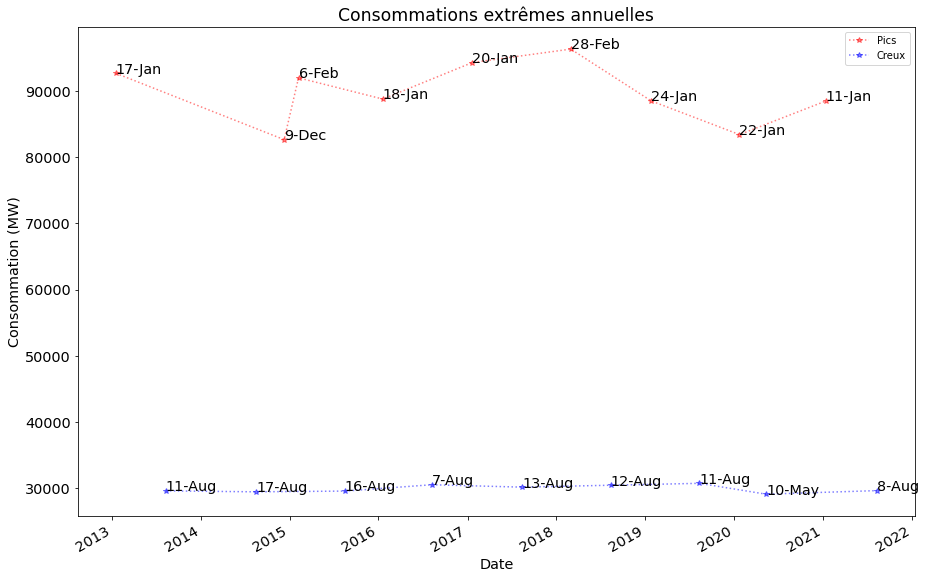

In [66]:
# Suppression des valeurs manquantes de consommation
conso = df.dropna(subset = ['Consommation (MW)'])

# Regroupement des consommations par plage horaire : somme des consommations de chaque région pour en récupérer la valeur nationale
conso = conso.groupby('Datetime').sum()

# Ajout de "Jour" à partir de "Date" pour exploitation graphique
conso['Année'] = conso.index.year
conso['Date'] = conso.index
conso['Jour - Mois'] = conso['Date'].dt.day.astype('str')+'-'+conso['Date'].dt.month_name().apply(lambda mois: mois[:3],True)

# Dataframes des consommations extrêmes annuelles
conso_max_annee = conso.groupby('Année', as_index=False).max().iloc[:,[0,4]]
conso_min_annee = conso.groupby('Année', as_index=False).min().iloc[:,[0,4]]

# Récupération des différentes colonnes pour les consommations extrêmes annuelles
conso_max = conso_max_annee.merge(right=conso, on=['Année','Consommation (MW)'],how='inner')
conso_min = conso_min_annee.merge(right=conso, on=['Année','Consommation (MW)'],how='inner')

# Graphique associé
fig = plt.figure(figsize=(15,10))
plt.title('Consommations extrêmes annuelles',fontsize='xx-large')
pics = conso_max.set_index('Date')['Consommation (MW)'].plot(color='red', ls=':', marker='*', alpha=0.5, label='Pics', fontsize='x-large')
creux = conso_min.set_index('Date')['Consommation (MW)'].plot(color='blue', ls=':', marker='*', alpha=0.5, label='Creux', fontsize='x-large')
plt.legend()
plt.xlabel('Date',fontsize='x-large')
plt.ylabel('Consommation (MW)',fontsize='x-large');

# Fonction d'ajout de texte sur les points
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']), fontsize='x-large')
label_point(conso_max['Date'], conso_max['Consommation (MW)'], conso_max['Jour - Mois'], pics)
label_point(conso_min['Date'], conso_min['Consommation (MW)'], conso_min['Jour - Mois'], creux)

# Enregistrement du graphique
plt.savefig('consommations_extremes_annuelles.png')





<div style="text-align: justify"><p>La plupart des creux de consommation sont stables et se situent toujours autour de l’été, régulièrement au mois d’Août correspondant à une baisse d’activité de l’industrie. Seule exception : l'année 2020, où le creux se situe en Mai ; cette donnée est intéressante car cela correspond précisément à la période "Covid" associée à une baisse des activités qui sera exploitée plus tard.</p>
<p>À l’inverse, les pics sont en hiver et associés aux baisses de températures qui impliquent une plus grande utilisation du chauffage. Néanmoins, ce seul facteur n’explique pas totalement les légères variations entre les différentes années : l’hiver 2013/2014, particulièrement froid, est associé à un pic de consommation plus élevé que la moyenne mais pas sensiblement supérieur à celui de 2015/2016, pourtant beaucoup plus chaud.
<p>Cela nous amène à étudier plus en détail dans la suite les profils de consommation.</p></div>

# III- Profils de consommation au niveau régional et au niveau national

## 1. DataViz'

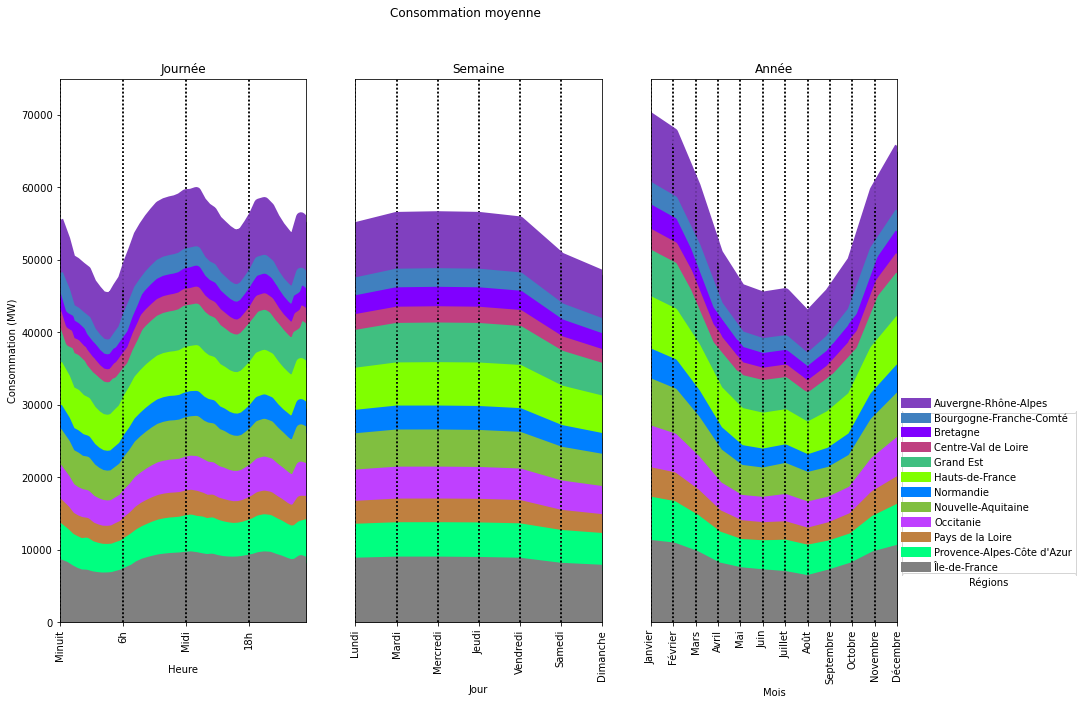

In [82]:
fig = plt.figure(figsize = (15,10))
plt.suptitle('Consommation moyenne') 

# Initialisation d'une liste de superposition des courbes de régions 
conso_heure = []  
conso_jour = []
conso_mois = []

for i in range(0, len(regions)): # Boucle par région
    conso_heure.append(df[df['Région']==regions[len(regions)-i-1]].groupby('Heure')['Consommation (MW)'].mean()+conso_heure[i-1] if i>0 else df[df['Région']==regions[len(regions)-i-1]].groupby('Heure')['Consommation (MW)'].mean())
    conso_jour.append(df[df['Région']==regions[len(regions)-i-1]].groupby('Jour')['Consommation (MW)'].mean()+conso_jour[i-1] if i>0 else df[df['Région']==regions[len(regions)-i-1]].groupby('Jour')['Consommation (MW)'].mean())
    conso_mois.append(df[df['Région']==regions[len(regions)-i-1]].groupby('Mois', group_keys=mois)['Consommation (MW)'].mean()+conso_mois[i-1] if i>0 else df[df['Région']==regions[len(regions)-i-1]].groupby('Mois')['Consommation (MW)'].mean())
    conso_max_heure, conso_max_jour, conso_max_mois = max(conso_heure[i]), max(conso_jour[i]), max(conso_mois[i])
    conso_max = max(conso_max_heure, conso_max_jour, conso_max_mois)
    conso_max_ordre_grandeur = 10**floor(log(conso_max,10))
    y_max = (floor((conso_max)/conso_max_ordre_grandeur)+1.5)*conso_max_ordre_grandeur
    
    plt.subplot(1,3,1)
    plt.plot(range(0,48), conso_heure[i], label=regions[len(regions)-i-1], color=couleurs_regions[len(regions)-i-1], linewidth=10)
    plt.fill_between(range(0, 48), conso_heure[i-1] if i>0 else 0, conso_heure[i], color=couleurs_regions[len(regions)-i-1])
    plt.xlim(0,47)
    plt.ylim(0,y_max)
    plt.title('Journée')
    plt.xlabel('Heure')
    position_heure = [0, 12, 24, 36]
    for heure in position_heure:
        plt.axvline(x=heure, color=(0,0,0,0.25), linestyle=':')
    plt.xticks(position_heure, ['Minuit', '6h', 'Midi', '18h'],rotation=90)
    plt.ylabel('Consommation (MW)');
    
    plt.subplot(1,3,2)
    plt.plot(range(0,7), conso_jour[i], label=regions[len(regions)-i-1], color=couleurs_regions[len(regions)-i-1], linewidth=10)
    plt.fill_between(range(0, 7), conso_jour[i-1] if i>0 else 0, conso_jour[i], color=couleurs_regions[len(regions)-i-1])
    plt.xlim(0,6)
    plt.ylim(0,y_max)
    plt.title('Semaine')
    plt.xlabel('Jour')
    plt.yticks([])
    position_jour = np.arange(7)
    for jour in position_jour-1:
        plt.axvline(x=jour, color=(0,0,0,0.25), linestyle=':')
    plt.xticks(np.arange(7), ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'], rotation=90);
    
    plt.subplot(1,3,3)
    plt.plot(range(0,12), conso_mois[i], label=regions[len(regions)-i-1], color=couleurs_regions[len(regions)-i-1], linewidth=10)
    plt.fill_between(range(0, 12), conso_mois[i-1] if i>0 else 0, conso_mois[i], color=couleurs_regions[len(regions)-i-1])
    plt.xlim(0,11)
    plt.ylim(0,y_max)
    plt.title('Année')
    plt.xlabel('Mois')
    plt.yticks([])
    position_mois = np.arange(12)
    for mois in position_mois-1:
        plt.axvline(x=mois, color=(0,0,0,0.25), linestyle=':')
    plt.xticks(position_mois, ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre'], rotation=90)
    
    plt.legend(title='Régions', bbox_to_anchor=(1, 0.1), labelspacing=-2.5);
        
# Enregistrement du graphique
plt.savefig('conso_heure.png', bbox_inches='tight')

## 2. Analyse

<p>La consommation varie en fonction de l’heure de la journée avec des variations plus ou moins importantes en fonction des régions. Le profil des régions semblent similaire en fonction des heures et les pics de consommations seraient liées à l’activité humaine. Le pic de 19h correspondrait à l'usage de type éclairage et cuisson des français chez eux le soir.</p> 
La consommation varie en fonction du jour de la semaine aussi de façon assez similaire avec une baisse le week-end notamment le dimanche qui peut correspondre à une baisse des activités industrielles et économiques.</p> 
De même, la consommation varie en fonction du mois de l’année avec une baisse en été sauf pour 2 régions : PACA et Nouvelle Aquitaine. Ces variations sont sans doute liées aux vacances d’été et donc une variation de la population dans la région. Les mois d’octobre à février sont des mois à forte consommation liée à la saison hivernale (températures basses, durée de la luminosité naturelle). Ce sont des facteurs que nous pourrons étudier par la suite.</p>
    
<p>Nous pouvons donc observer que la consommation varie en fonction de l'heure, du jour, du mois et de la saison quelles que soient les régions avec plus ou moins d'amplitude. Nous allons par la suite vérifier statistiquement que les variables 'Heure', 'Jour', 'Mois' et 'Saison' ont un effet statistique significatif sur la variable Consommation. Pour cela nous allons utiliser l'analyse de la variance ANOVA qui permet de conclure sur l'influence d'une variable explicative catégorielle (Heure, Jour, Mois, Saison) sur la loi d'une variable continue (Consommation).</p>
    
<p><b><i>H0_1 : "La Consommation régionale et l'heure de la journée sont indépendantes ?"</p>
    <p>H0_2 : "La Consommation régionale et le jour de la semaine sont indépendants ?"</p>
    <p>H0_3 : "La Consommation régionale et le mois de l'année sont indépendants ?"</p>
    <p>H0_4 : "La Consommation régionale et la saison de l'année sont indépendantes ?"</p>

In [83]:
#On importe le module statsmodels, un module Python, qui fournit des classes et des fonctions 
#pour l'estimation de nombreux modèles statistiques différents,
#ainsi que pour la réalisation de tests statistiques et l'exploration de données statistiques. 
import statsmodels.api

#On initialise un nouveau data frame dfe à partir de la data frame principal df
#et on renomme la variable 'Consommation (MW)' pour pouvoir appliquer ANOVA avec les variables catégorielles :
#Heure, Jour, Mois et Saison
dfe = df.rename(columns={'Consommation (MW)': 'Consommation'})

result = statsmodels.formula.api.ols('Consommation ~ Heure + Jour + Mois + Saison', data = dfe).fit()
table = statsmodels.api.stats.anova_lm(result)

table

df        sum_sq       mean_sq             F  PR(>F)
Heure          47.0  2.299045e+11  4.891585e+09   1109.193242     0.0
Jour            1.0  6.632038e+10  6.632038e+10  15038.503652     0.0
Mois            1.0  1.140442e+11  1.140442e+11  25860.148533     0.0
Saison          1.0  8.804143e+10  8.804143e+10  19963.869827     0.0
Residual  1875393.0  8.270555e+12  4.410038e+06           NaN     NaN

<p>H0_1 : La p-value (PR(>F)) est inférieure à 5% donc on rejette l'hypothèse selon laquelle l'heure n'influe pas sur la consommation.<p>
<p>H0_2 : La p-value (PR(>F)) est inférieure à 5% donc on rejette l'hypothèse selon laquelle le jour n'influe pas sur la consommation.<p>
<p>H0_3 : la p-value (PR(>F)) est inférieure à 5% donc on rejette l'hypothèse selon laquelle le mois n'influe pas sur la consommation.<p>
<p>H0_4 : la p-value (PR(>F)) est inférieure à 5% donc on rejette l'hypothèse selon laquelle la saison n'influe pas sur la consommation.<p>

<p>En conclusion, l'heure, le jour, le mois et la saison ont un effet statistique significatif sur la consommation.<p>
<p>En hiver, l’utilisation du chauffage électrique entraîne une consommation plus importante qu’en été. De même, l’activité économique engendre une consommation plus élevée en semaine que le week-end. Les usages domestiques font varier aussi la consommation en fonction de l'heure.<p>

<p>Les variations de consommation sont comparables en fonction des régions mais on peut aussi voir que la région Ile de France est la plus consommatrice et la région Centre-Val de Loire la moins consommatrice.
<p>D’après l’INSEE, la région Ile de France est d'ailleurs la plus peuplée et la région Centre-Val de Loire est la moins peuplée. On peut émettre l'hypothèse qu'il y a une corrélation avec un lien de cause à effet entre la consommation et la population et vérifier cette hypothèse.<p>
<p>Par contre, la région Auvergne-Rhône-Alpes a une consommation assez semblable à celle de l'Île-de-France alors qu'elle a 1/3 d'habitants de moins. 
<p> En effet, la consommation électrique se répartie sur 3 secteurs. En 2020, le secteur le plus consommateur reste le secteur des entreprises et des professionnels (47 %), suivi par le résidentiel avec près de 38 % de la consommation finale d’électricité et enfin la grande industrie qui représente 16 % du volume total (selon le Bilan Electrique 2020 de la RTE).<p>
<p>La consommation de la région Auvergne-Rhône-Alpes s'expliquerait par le fait que c'est un territoire avec un fort d’un tissu industriel dense, d’une agriculture dynamique, d’une population nombreuse et en augmentation, ainsi que d’infrastructures routières importantes, qui consomme 12,9% de l’énergie française (source des données nationales : SDES – Bilan énergétique de la France métropolitaine, 2018). La région Auvergne-Rhône-Alpes est l’une des plus productrices d’énergie, majoritairement électrique, avec notamment 4 centrales nucléaires et de nombreuses usines hydroélectriques mais aussi une importante production de chaleur issue du bois énergie. Les autres sources d’énergies renouvelables (photovoltaïque, solaire thermique, biogaz, éolien…) sont en constante progression.<p>

# IV- Consommation vs population, superficie et densité

## 1. DataViz'

In [89]:
#On va utiliser ici un data frame avec des données sur la population issue de l'INSEE
#avec des données sur la superficie et la densité.
region_data = pd.read_csv('régions_superficie.csv', sep=';')
region_data.info()
region_data.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   R�gions     18 non-null     object
 1   Population  18 non-null     int64 
 2   Superficie  18 non-null     int64 
 3   Densit�     18 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 704.0+ bytes


R�gions  Population  Superficie  Densit�
0         Auvergne-Rh�ne-Alpes     7948287       69711      114
1      Bourgogne-Franche-Comt�     2811423       47784       59
2                     Bretagne     3318904       27208      122
3          Centre-Val de Loire     2576252       39151       66
4                        Corse      334938        8680       39
5                    Grand Est     5549586       57433       97
6                   Guadeloupe      390253        1628       32
7                       Guyane      268700       83534        3
8              Hauts-de-France     6003815       31814      189
9                �le-de-France    12174880       12011     1014
10                  Martinique      372594        1128      330
11                     Mayotte      256518         376      682
12                   Normandie     3330478       29907      111
13          Nouvelle-Aquitaine     5956978       84036       71
14                   Occitanie     5845102       72724       80
15            Pays de la Loire     3757600       32082      117
16  Provence-Alpes-C�te d'Azur     5030890       31400      160
17                     R�union      853659        2504      341

In [90]:
#Comme dans les données importées, les lettres avec des accents ne se sont pas bien retranscrites,
#nous renommons les régions mal retranscrites ainsi que le nom de la colonne pour préparer la fusion.

region_data = region_data.rename(columns={'R�gions':'Région'})
region_data['Région'] = region_data['Région'].replace({"Auvergne-Rh�ne-Alpes":"Auvergne-Rhône-Alpes",
                                                       "Bourgogne-Franche-Comt�":"Bourgogne-Franche-Comté",
                                                       "Centre-Val-de-Loire":"Centre-Val de Loire",
                                                       "Provence-Alpes-C�te d'Azur":"Provence-Alpes-Côte d'Azur",
                                                       "�le-de-France":"Île-de-France", 
                                                       "R�union":"Réunion"})
region_data = region_data.rename(columns={'Densit�':'Densité'})

In [91]:
# Pour précision, les données sur la population du fichier 'régions_superficie.csv' sont celles de l'année 2017. 
# c'est pour cela que nous nous intéresserons à la consommation sur l'année 2017.

# Dataframe des consommations par région pour 2017
conso_2017 = pd.DataFrame(dfe[dfe['Année']== 2017].groupby('Région', group_keys=regions[i])['Consommation'].sum()*0.5)

conso_2017.head()

Consommation
Région                               
Auvergne-Rhône-Alpes       67696818.0
Bourgogne-Franche-Comté    21938679.5
Bretagne                   22289412.5
Centre-Val de Loire        18961067.5
Grand Est                  46439357.5

In [92]:
#Fusion du data frame sur la consommation 2017 avec le data frame sur la population, la superficie et la densité
conso_2017 = conso_2017.merge(region_data, on=['Région'])

conso_2017.head(15)

Région  Consommation  Population  Superficie  Densité
0         Auvergne-Rhône-Alpes    67696818.0     7948287       69711      114
1      Bourgogne-Franche-Comté    21938679.5     2811423       47784       59
2                     Bretagne    22289412.5     3318904       27208      122
3          Centre-Val de Loire    18961067.5     2576252       39151       66
4                    Grand Est    46439357.5     5549586       57433       97
5              Hauts-de-France    51298837.5     6003815       31814      189
6                    Normandie    28103298.5     3330478       29907      111
7           Nouvelle-Aquitaine    44062962.0     5956978       84036       71
8                    Occitanie    38296949.0     5845102       72724       80
9             Pays de la Loire    27404788.5     3757600       32082      117
10  Provence-Alpes-Côte d'Azur    41230539.5     5030890       31400      160
11               Île-de-France    71322013.0    12174880       12011     1014

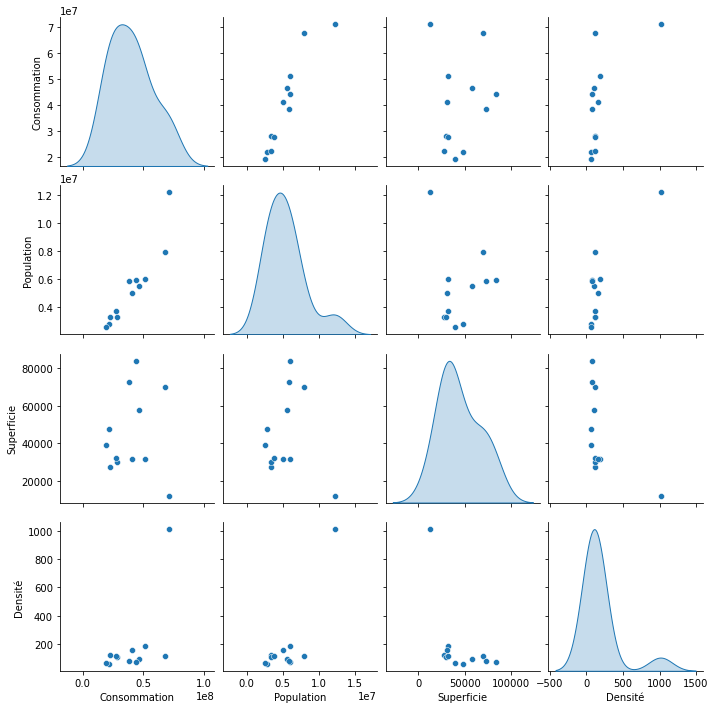

In [93]:
#Grâce à la fonction pairplot, on affiche les nuages de points entre chaque paire de variables quantitatives,
#ainsi que les densités estimées sur la diagonale du data frame conso_2017
sns.pairplot(conso_2017, diag_kind='kde');

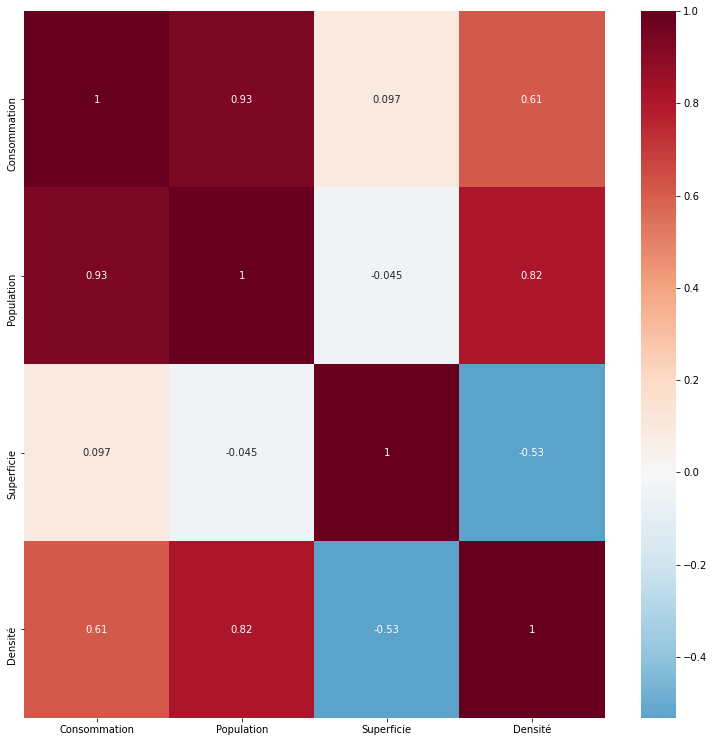

In [94]:
#Grâce à la fonction heatmap, on représente une matrice de corrélation du data frame conso_2017
plt.figure(figsize=(13, 13))
sns.heatmap(conso_2017.corr(), annot=True, cmap="RdBu_r", center=0);

<p>On constate bien que la consommation est fortement corrélée avec le nombre d'habitants par région (0.93), que la corrélation est forte avec la densité par population (0.61) et qu'elle a une corrélation faible avec la superficie(0.097).<p> 

Cependant, il est nécessaire d'utiliser le test de Pearson pour confirmer s'il y a effectivement ou non un lien de cause à effet entre les variables en regardant la valeur de la p-value. On vérifiera pour cela différentes hypothèses nulles.<p>

<p><b><i>H0 : "les variables 'Consommation' et 'Population' sont indépendantes ?"<p>

In [95]:
pd.DataFrame(pearsonr(conso_2017['Consommation'], conso_2017['Population']), index=['pearson_coff', 'p-value'], columns=['resultat_test'])

resultat_test
pearson_coff       0.934652
p-value            0.000008

<p><b><i>H0 : "les variables 'Consommation' et 'Superficie' sont indépendantes ?"

In [96]:
pd.DataFrame(pearsonr(conso_2017['Consommation'], conso_2017['Superficie']), index=['pearson_coff', 'p-value'], columns=['resultat_test'])

resultat_test
pearson_coff       0.097328
p-value            0.763481

<p><b><i>H0 : "les variables 'Consommation' et 'Densité' sont indépendantes ?"

In [97]:
pd.DataFrame(pearsonr(conso_2017['Consommation'], conso_2017['Densité']), index=['pearson_coff', 'p-value'], columns=['resultat_test'])

# p-value < 5% donc on rejette H0

resultat_test
pearson_coff       0.609447
p-value            0.035399

<p>Pour les modélisations ultérieures, il est intéressant aussi de vérifier la relation entre la consommation et la région :
<p><b><i>H0 : "les variables 'Consommation' et 'Région' sont indépendantes ?"

In [98]:
result = statsmodels.formula.api.ols('Consommation ~ Région', data = dfe).fit()
table = statsmodels.api.stats.anova_lm(result)

table

#la p-value (PR(>F)) est inférieure à 5% donc on rejette l'hypothèse selon laquelle la région n'influe pas sur la consommation

df        sum_sq       mean_sq              F  PR(>F)
Région         11.0  6.459091e+12  5.871901e+11  476771.645729     0.0
Residual  1875432.0  2.309775e+12  1.231596e+06            NaN     NaN

<p>La population, la densité, la région ont bien une relation cause-effet sur la consommation mais ce n'est pas le cas pour la superfie.
<p>Il est intéressant de regarder maintenant quelle est la consommation par habitant en fonction des régions puisque nous avions vu précédemment que le nombre d'habitant par région n'était pas le seul facteur impactant la consommation comme pour la région Auvergne-Rhône-Alpes.

In [99]:
#On ajoute dans le data frame conso_2017 une colonne avec le résultat de consommation par habitant
#en multipliant par 1000 pour avoir le résultat en kWh et par 38% pour la partie résidentielle
# et on fait un tri en fonction de la consommation par habitant la plus faible à la plus forte
conso_2017['conso_par_hab (kWh)'] = conso_2017['Consommation']*1000*0.38/conso_2017['Population']
conso_2017 = conso_2017.sort_values(by = 'conso_par_hab (kWh)')

conso_2017.describe()

Consommation    Population    Superficie      Densité  \
count  1.200000e+01  1.200000e+01     12.000000    12.000000   
mean   3.992039e+07  5.358683e+06  44605.083333   183.333333   
std    1.737512e+07  2.686489e+06  21859.189420   264.362125   
min    1.896107e+07  2.576252e+06  12011.000000    59.000000   
25%    2.612594e+07  3.327584e+06  31026.750000    77.750000   
50%    3.976374e+07  5.290238e+06  35616.500000   112.500000   
75%    4.765423e+07  5.968687e+06  60502.500000   131.500000   
max    7.132201e+07  1.217488e+07  84036.000000  1014.000000   

       conso_par_hab (kWh)  
count            12.000000  
mean           2883.018097  
std             334.561545  
min            2226.088876  
25%            2716.561469  
50%            2888.051785  
75%            3186.532348  
max            3246.861912

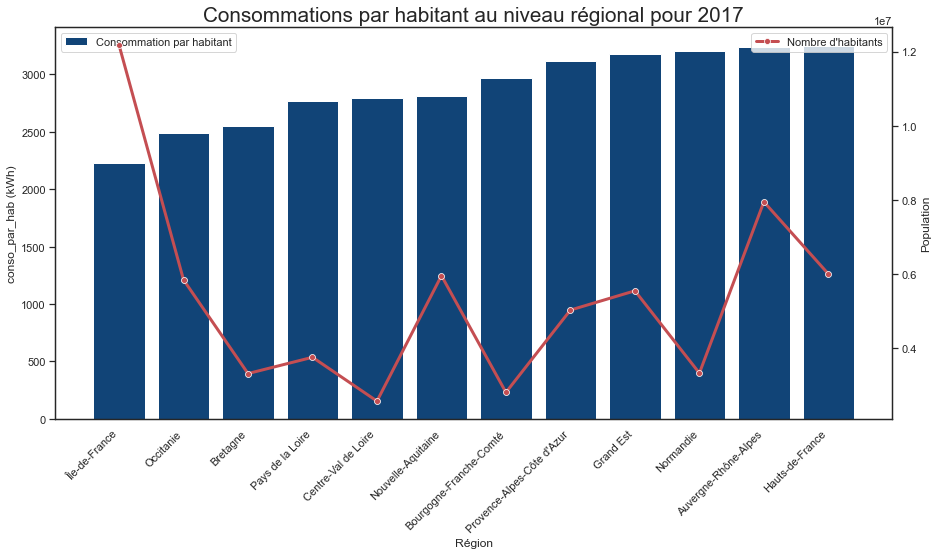

In [321]:
# On fait une représentation graphique pour mieux visualiser les données

sns.set(style="white", rc={"lines.linewidth": 3})
fig, ax1 = plt.subplots(figsize=(15,8))
ax2 = ax1.twinx()

chart = sns.barplot(x=conso_2017['Région'],
            y=conso_2017['conso_par_hab (kWh)'], 
            label='Consommation par habitant', 
            color='#004488',
            ax=ax1)


sns.lineplot(x=conso_2017['Région'], 
             y=conso_2017['Population'], 
             label="Nombre d'habitants",
             color='r',
             marker="o",
             ax=ax2)

plt.xlabel('Régions')
fig.autofmt_xdate(rotation=45)
plt.title("Consommations par habitant au niveau régional pour 2017", fontsize="xx-large")
chart.legend()
#plt.legend(labels=["Consommation par habitant","Nombre d'habitants"],bbox_to_anchor=(1.05, 1.0), loc='upper left');

## 2. Analyse

<p>On constate que même si l'Île-de-France est la plus peuplée et a la plus forte densité, la consommation par habitant est la plus faible. Les Hauts-de-France est la région qui consommme le plus avec une densité 5 fois moins importante que celle de l'Île-de-France. Il doit donc avoir d'autres facteurs qui impactent la consommation en plus de la population.<p>

# V- Consommation régionale en fonction de la température

## 1. DataViz'

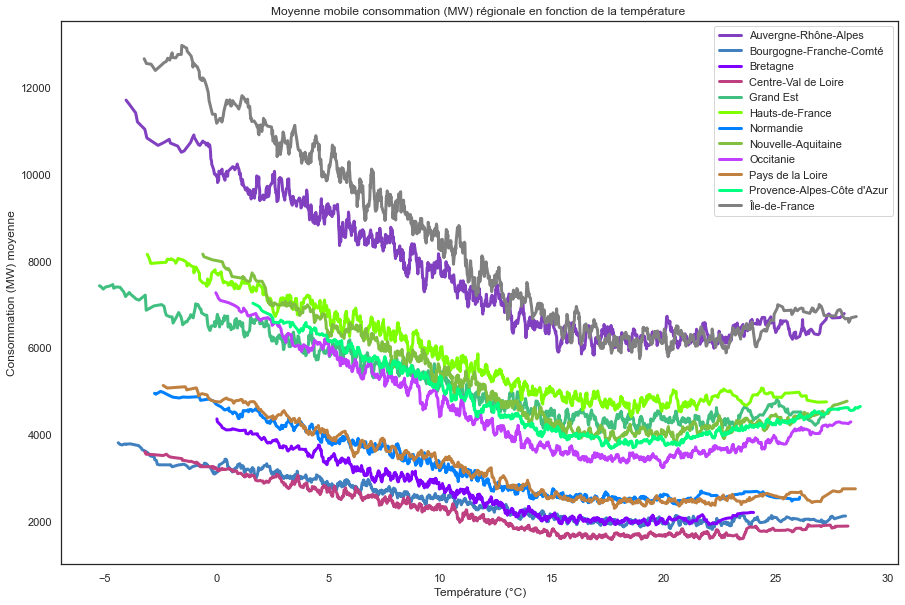

In [101]:
# Transformation de la colonne des dates au format date
df['Date'] = pd.to_datetime(df['Date'])
temp['Date']= pd.to_datetime(temp['Date'])

# Renommage colonne "Région" dans temp
temp = temp.rename(columns={"region (name)":"Région"})
 	
# Fusion de df et temp
data = df.merge(temp, on=['Date', 'Région'])

fig, ax = plt.subplots(figsize = (15,10))

for i in range(0, len(regions)): # Boucle par région
    region = data[data['Région']==regions[i]]
    grouping_region = data[data['Région']==regions[i]].groupby('TMoy (°C)')['Consommation (MW)'].mean()
    plt.plot(grouping_region.rolling(10).mean().shift(-5), label=regions[i], color =couleurs_regions[i])
    
plt.title("Moyenne mobile consommation (MW) régionale en fonction de la température ")
plt.xlabel('Température (°C)')
plt.ylabel('Consommation (MW) moyenne')
plt.legend();

## 2. Analyse

<p> Les courbes d'évolution de la consommation par région en fonction de la température représentent la moyenne mobile pour chaque région. Elles sont calculées sur l'année 2016 à titre d'exemple. Sur ce graphe, pour des basses températures (qui correspondent à l'hiver), la consommation est assez élevée, tandis que pour des hautes températures (qui correspondent à l'été), la consommation est assez faible. La consommation est assez stable à partir de 20°celsius pour toutes les régions.  
<p>La région qui enregistre une forte consommation énergétique est celle de l'Île de France. Celle qui enregistre le moins est la région Centre-val de Loire.    
<p>Trois grands groupes se distinguent sur ce graphique. Le groupe 1 constitué par la région île-de-France et celle d'Auvergne-Rhône-Alpes qui sont les plus grands consommateurs énergétiques. Ce sont les deux plus grandes régions en terme de population. Aussi la région île-de-France est une zone à fortes activités économique. La situation géographique de la région Auvergne-Rhône-Alpes qui est dans une zone assez montagneuse enregistre chaque année des pics de températures en été mais aussi de basses températures en hiver, ce qui entraine des hausses de consommation. Le groupe 2 qui se compose de l'Occitanie,la Provence-Alpes-Côte d'Azur,les Hauts-de-France,et la Nouvelle-Aquitaine qui de moyennes consommations.Le groupe 3 regroupe le Centre-val de Loire, la Bretagne, le Grand-Est, Pays de la Loire, la Normandie, la Bourgogne-Franche-Comte qui sont de faibles consommateurs en énergie. Ces deux groupes semblent être liés également à la démographie.</p>

## 3. Test de corrélation

resultat_test
pearson_coeff      -0.344959
p-value             0.000000

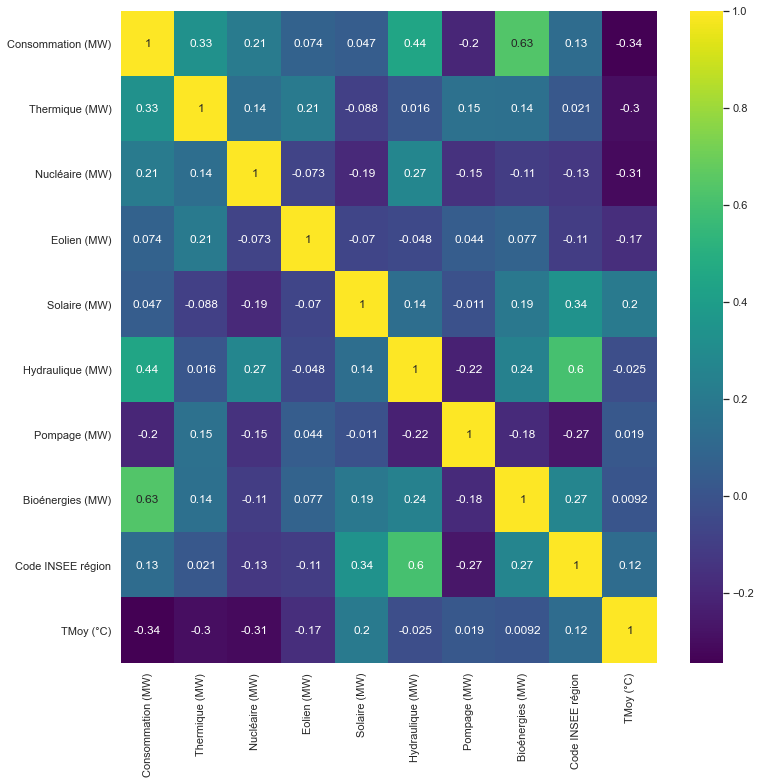

In [102]:
# Transformation de la colonne des dates au format date
df['Date'] = pd.to_datetime(df['Date'])
temp['Date']= pd.to_datetime(temp['Date'])

# Renommage colonne "Région" dans temp
temp = temp.rename(columns={"region (name)":"Région"})
 
# Fusion de df et temp
data = df.merge(temp, on=['Date', 'Région'])

#Test de corrélation:température correlée à la consommation?

#Suppression des colonnes
#data.drop('Code INSEE région_x', axis=1, inplace=True)
data.drop('Jour', axis=1, inplace=True)
data.drop('Mois', axis=1, inplace=True)
data.drop('Saison', axis=1, inplace=True)
data.drop('Région', axis=1, inplace=True)
data.drop('Année', axis=1, inplace=True)
data.drop('Ech. physiques (MW)', axis=1, inplace=True)
data.drop('TCO Thermique (%)', axis=1, inplace=True)
data.drop('TCH Thermique (%)', axis=1, inplace=True)
data.drop('TCO Nucléaire (%)', axis=1, inplace=True)
data.drop('TCH Nucléaire (%)', axis=1, inplace=True)
data.drop('TCO Eolien (%)', axis=1, inplace=True)
data.drop('TCH Eolien (%)', axis=1, inplace=True)
data.drop('TCO Solaire (%)', axis=1, inplace=True)
data.drop('TCH Solaire (%)', axis=1, inplace=True)
data.drop('TCO Hydraulique (%)', axis=1, inplace=True)
data.drop('TCH Hydraulique (%)', axis=1, inplace=True)
data.drop('TCO Bioénergies (%)', axis=1, inplace=True)
data.drop('TCH Bioénergies (%)', axis=1, inplace=True)
#data.drop('Column 26', axis=1, inplace=True)
#data.drop('Code INSEE région_y', axis=1, inplace=True)
data.drop('TMin (°C)', axis=1, inplace=True)
data.drop('TMax (°C)', axis=1, inplace=True)


plt.figure(figsize=(12, 12))  # Taille de la figure

sns.heatmap(data.corr(), annot=True, cmap='viridis');


#consommation régionale correlée à la température ? Méthode de Pearson

pd.DataFrame(pearsonr(data['Consommation (MW)'], data['TMoy (°C)']), index=['pearson_coeff','p-value'], columns=['resultat_test'])

## 4. Analyse

<p>Le test de corrélation basée sur la méthode de pearson donne une p-value inférieure à 5%, donc on rejette l'hypothèse selon laquelle la température n'a pas d'influence sur la consommation. Les variables dépendantes. on peut conclure que la température a une influence sur la consommation<p>
<p>Un coefficent de corrélation (pearson-coeff) égale à -0.35. Nous pouvons conclure que les variables(la température et la consommation) sont correlées négativement.<p>

# VI- Consommation et production superposées en fonction du jour de la semaine 

## 1. DataViz'

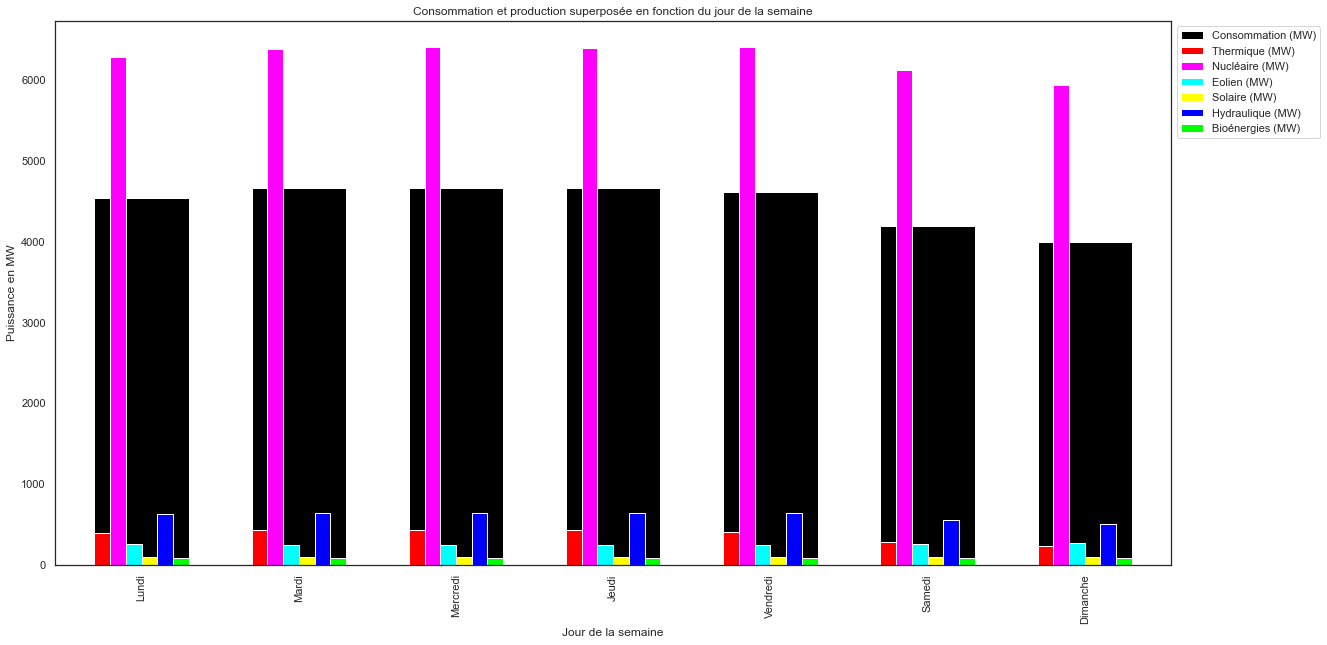

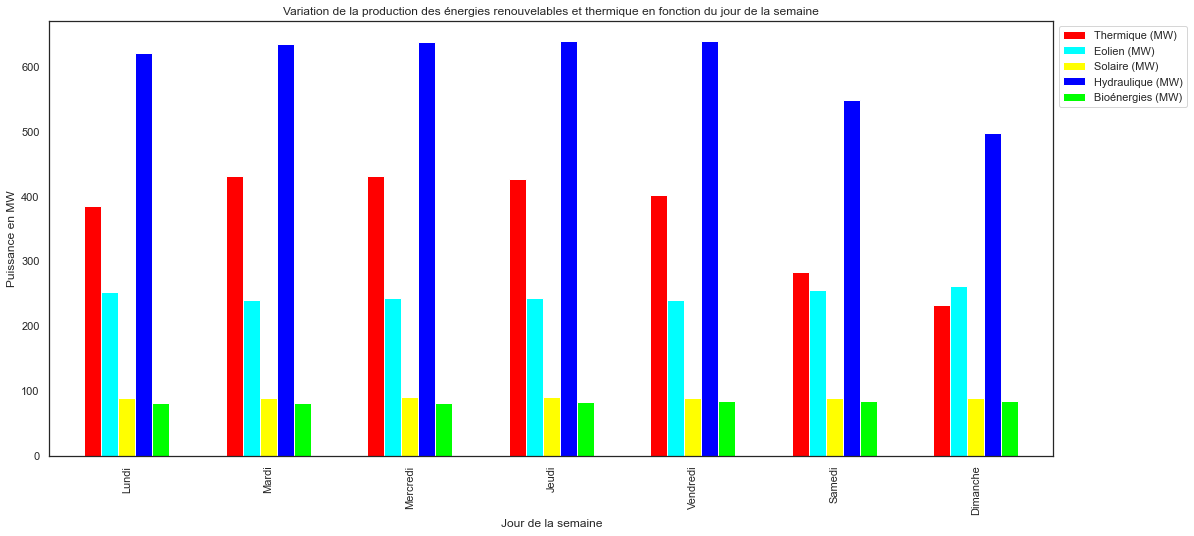

In [103]:
df['Date'] = pd.to_datetime(df['Date'])
df['weekday'] = df['Date'].dt.weekday
day = df.groupby("weekday").mean()
day = day.reset_index()
day.head(10)

fig, ax = plt.subplots(figsize = (20,10))

day.plot.bar(x='weekday', y='Consommation (MW)',width = 0.6, color=(0.0, 0.0, 0.0), ax = ax)
day.plot.bar(x='weekday', y=['Thermique (MW)', 'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)', 'Hydraulique (MW)', 'Bioénergies (MW)'],width = 0.6, color=[(1.0, 0.0, 0.0),(1.0, 0.0, 1.0),(0.0, 1.0, 1.0),(1.0, 1.0, 0.0),(0.0, 0.0, 1.0),(0.0, 1.0, 0.0)], ax = ax)
plt.xticks(np.arange(7), ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'])
plt.xlabel("Jour de la semaine")
plt.ylabel("Puissance en MW")
plt.legend(bbox_to_anchor=(1.0, 1.0),loc='upper left')
plt.title("Consommation et production superposée en fonction du jour de la semaine");


fig, ax = plt.subplots(figsize = (18,8))

day.plot.bar(x='weekday', y=['Thermique (MW)', 'Eolien (MW)', 'Solaire (MW)', 'Hydraulique (MW)', 'Bioénergies (MW)'],width = 0.6, color=[(1.0, 0.0, 0.0),(0.0, 1.0, 1.0),(1.0, 1.0, 0.0),(0.0, 0.0, 1.0),(0.0, 1.0, 0.0)], ax = ax)
plt.xticks(np.arange(7), ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'])
plt.xlabel("Jour de la semaine")
plt.ylabel("Puissance en MW")
plt.legend(bbox_to_anchor=(1.0, 1.0),loc='upper left')
plt.title("Variation de la production des énergies renouvelables et thermique en fonction du jour de la semaine");

## 2. Analyse

<p>Le graphique 1 représente la consommation et la production en fonction des jours de la semaine. Sur celui-ci, la consommation et la production varient assez peu par rapport au jour de la semaine. Une faible consommation et production sont enregistrées pendant les week-end, mais reste constante pour les autres jours de la semaine. Une baisse est enregistrée pour le nucléaire, le thermique et l'hydraulique.Cela pourrait s’expliquer par une baisse de l’activité  industrielle  pendant le week-end (Samedi et Dimanche étant des jours de repos).<p>
<p>Le graphique 2 montre les variations des énergies renouvelables et thermique pendant les jours de la semaine. La production bioénergétique, éolienne et solaire est constante durant toute la semaine. Ces production ne sont pas liés à l'activité indsutrielle.<p>

# VII- La consommation est-elle correlée au taux de cession de la région (dynamisme de la région) ?

## 1. Dataviz'

Année  Région                    
2014   Île-de-France                 8018.373002
       Auvergne-Rhône-Alpes          7318.271689
       Hauts-de-France               5806.260331
       Grand Est                     5123.240354
       Nouvelle-Aquitaine            4821.302283
       Provence-Alpes-Côte d'Azur    4640.669521
       Occitanie                     4025.831164
       Normandie                     3098.343379
       Pays de la Loire              3002.138527
       Bretagne                      2472.897432
       Bourgogne-Franche-Comté       2330.322774
       Centre-Val de Loire           2121.867580
Name: Consommation (MW), dtype: float64


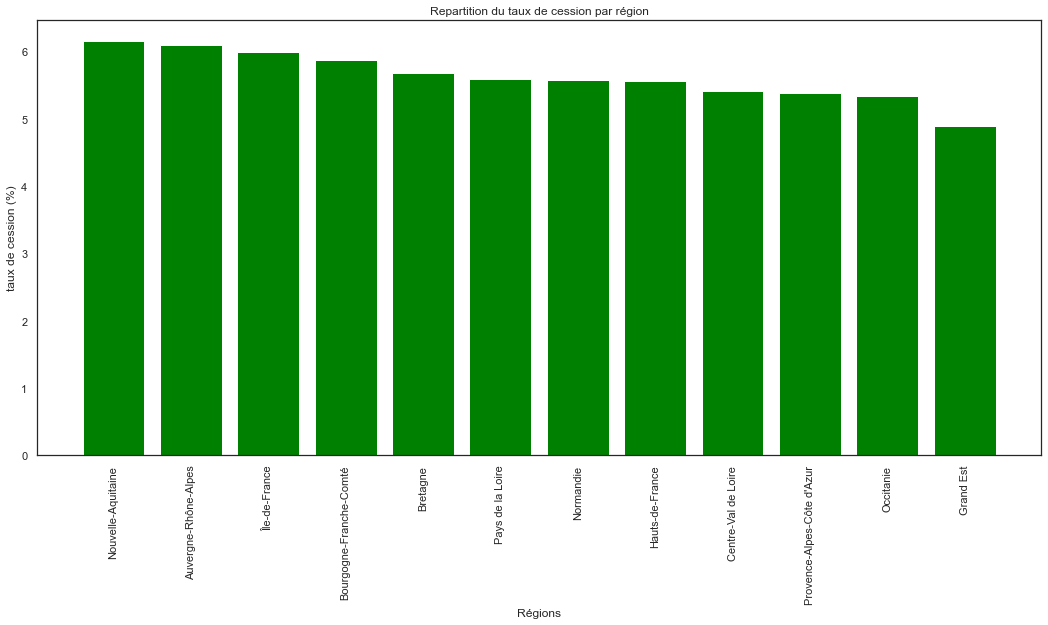

In [105]:
# Suppression des valeurs manquantes de consommation
conso=df.dropna(subset = ['Consommation (MW)'])

# Suppression des valeurs manquantes de régions
dyn_region=dyn.dropna(subset = ['Région'])

#Suppresion des colonnes pourcentage et dpt de dyn_region
dyn_region.drop('pourcentage', axis=1, inplace=True)
dyn_region.drop('dpt', axis=1, inplace=True)

# renommer colonne naf_niveau2 et pourcentage_1
dyn_region = dyn_region.rename(columns={"naf_niveau2":"secteur","pourcentage_1":"pourcentage (%)"})

#Classification des régions ayant le plus fort taux de cession (exemple sur l'année 2014)
act_moy = dyn_region[dyn_region['Année']==2014].groupby(['Année','Région']).mean()
act_moy=act_moy.sort_values(by = ['pourcentage (%)','Région'], ascending=False)
conso_moy = conso[conso['Année']==2014].groupby(['Année','Région']).mean()
conso_moy=conso_moy.sort_values(by = ['Consommation (MW)','Région'], ascending=False)
print(conso_moy['Consommation (MW)'])

#Représentation graphique du taux de cession par région
regions_ascending = ['Nouvelle-Aquitaine','Auvergne-Rhône-Alpes','Île-de-France','Bourgogne-Franche-Comté','Bretagne','Pays de la Loire','Normandie','Hauts-de-France','Centre-Val de Loire',"Provence-Alpes-Côte d'Azur",'Occitanie','Grand Est']

fig, ax = plt.subplots(figsize = (18,8))
plt.bar(range(len(act_moy)), act_moy['pourcentage (%)'],color='green');
plt.xticks(np.arange(12), regions_ascending,rotation=90)
plt.xlabel('Régions')
plt.ylabel('taux de cession (%)')
plt.title("Repartition du taux de cession par région");

## 2. Analyse

<p>Le graphique ci-dessus représente le taux de cession par région en pourcentage. Le taux de cession correspond au dynamisme pour chaque région. Il est calculé à partir de plusieurs secteurs (détaillés dans le graphe ci-dessous).</p>
<p>De ce graphique, et par ordre décroissant, la région Nouvelle-Aquitaine, Auvergne-Rhône-Alpes, l'Île de France, Bourgogne-Franche-Comté présentent un taux de cession élevé. Déterminons si le taux de cession a une influence sur la consommation des régions.</p>

## 3. Test de corrélation

resultat_test
pearson_coeff       0.300918
p-value             0.341891

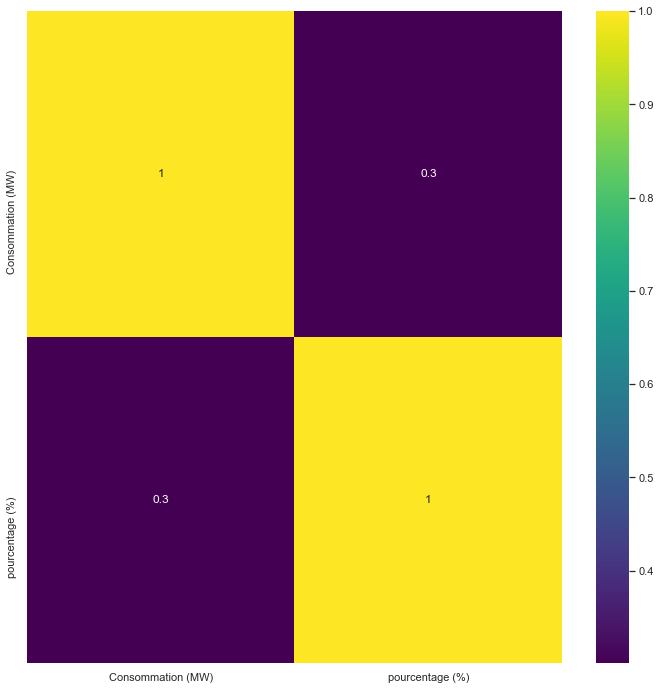

In [106]:
# Suppression des valeurs manquantes de consommation
conso=df.dropna(subset = ['Consommation (MW)'])

#déterminer la consommation moyenne annuel (exemple sur 2014) par région 
conso_moy = conso[conso['Année']==2014].groupby(['Année','Région']).mean()

#Classification des régions ayant le plus fort taux de cession (exemple sur l'année 2014)
act_moy = dyn_region[dyn_region['Année']==2014].groupby(['Année','Région']).mean()

#Fusion de la consommation moyenne et de l'activité moyenne
fusion = conso_moy.merge(act_moy, on=['Région'])

##Suppression des colonnes
fusion.drop('Thermique (MW)', axis=1, inplace=True)
fusion.drop('Nucléaire (MW)', axis=1, inplace=True)
fusion.drop('Solaire (MW)', axis=1, inplace=True)
fusion.drop('Hydraulique (MW)', axis=1, inplace=True)
fusion.drop('Pompage (MW)', axis=1, inplace=True)
fusion.drop('Eolien (MW)', axis=1, inplace=True)
fusion.drop('Bioénergies (MW)', axis=1, inplace=True)
fusion.drop('weekday', axis=1, inplace=True)
fusion.drop('Ech. physiques (MW)', axis=1, inplace=True)
fusion.drop('TCO Thermique (%)', axis=1, inplace=True)
fusion.drop('TCH Thermique (%)', axis=1, inplace=True)
fusion.drop('TCO Nucléaire (%)', axis=1, inplace=True)
fusion.drop('TCH Nucléaire (%)', axis=1, inplace=True)
fusion.drop('TCO Eolien (%)', axis=1, inplace=True)
fusion.drop('TCH Eolien (%)', axis=1, inplace=True)
fusion.drop('TCO Solaire (%)', axis=1, inplace=True)
fusion.drop('TCH Solaire (%)', axis=1, inplace=True)
fusion.drop('TCO Hydraulique (%)', axis=1, inplace=True)
fusion.drop('TCH Hydraulique (%)', axis=1, inplace=True)
fusion.drop('TCO Bioénergies (%)', axis=1, inplace=True)
fusion.drop('TCH Bioénergies (%)', axis=1, inplace=True)
#fusion.drop('Column 26', axis=1, inplace=True)
fusion.drop('Jour', axis=1, inplace=True)
fusion.drop('Mois', axis=1, inplace=True)
fusion.drop('Saison', axis=1, inplace=True)




plt.figure(figsize=(12, 12))  # Taille de la figure

sns.heatmap(fusion.corr(), annot=True, cmap='viridis');


pd.DataFrame(pearsonr(fusion['Consommation (MW)'], fusion['pourcentage (%)']), index=['pearson_coeff','p-value'], columns=['resultat_test'])

<p> Le test de corrélation basée sur la méthode de pearson donne une p-value supérieure à 5%. Nous ne rejettons pas Ho. Cela ne signifie pas du tout que la consommation est indépendant du taux de cession. Nous ne pouvons pas conclure sur l'hypothèse selon laquelle le taux de cession influe sur la consommation. </p>
<p> Le coefficent de corrélation (pearson-coeff) est d'environ 0,3. Les variables taux de cession et consommation sont faiblement correlées.</p>
<p>Vérifions si la consommation par région est en lien avec les secteurs d'activités.</p>

## 4. Repartition du taux de cession par secteur d'activité et par région

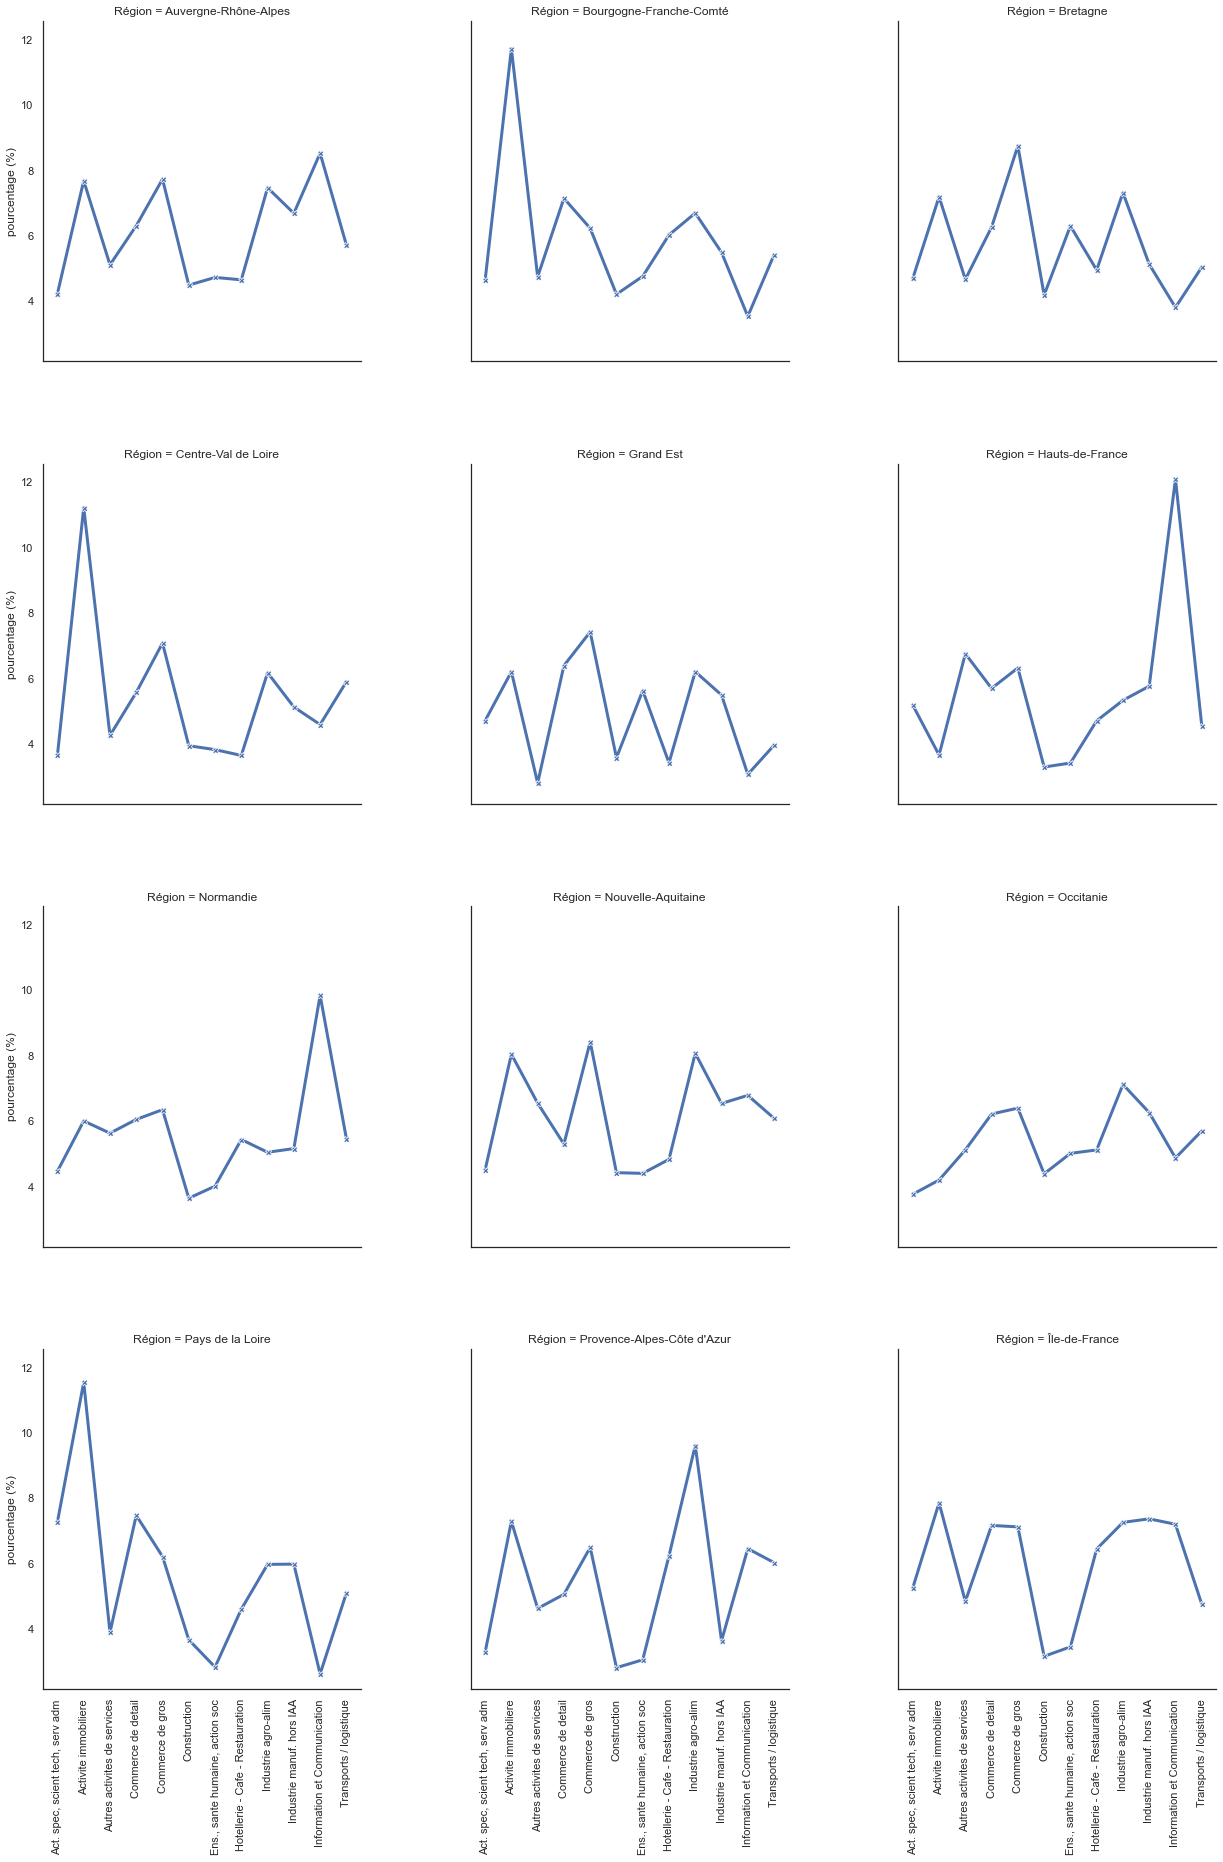

In [123]:
# Ajout d'une colonne "Année"
data['Année']=data['Date'].apply(lambda x: str(x)[:-15]).astype(str)

#Classification des régions ayant le plus fort taux de cession (exemple sur l'année 2014)
act_moy = dyn_region[dyn_region['Année']==2014].groupby(['Année','Région','secteur']).mean()

#Représentation graphique du taux de cession (par secteur d'activité) par région

g=sns.relplot(x='secteur', y='pourcentage (%)', col='Région', col_wrap=3, height=6, kind='line', marker='X', data=act_moy);
#g=sns.factorplot(x='secteur', y='pourcentage (%)', col='Région', col_wrap=3, height=6, data=act_moy);
#g=sns.barplot(x='Région',y='pourcentage (%)',hue='secteur', ci=None, data=act_moy)
g.set_xlabels('')
g.set_ylabels('pourcentage (%)')

for ax in g.axes:
    plt.setp(ax.get_xticklabels(), visible=True, rotation=90)

plt.subplots_adjust(hspace=0.3)

plt.show()

<p>Ces différents graphes montrent la répartition du taux de cession en fonction de la région et du secteur d'activité.</p>

<p>Dans le détail, et en fonction du secteur :
    
- Pour la Nouvelle-Aquitaine;les secteurs dominants sont l'activité immobilière, le commerce de gros et l'industrie agro-alimentaire.
- Pour la région Auvergne-Rhône-Alpes; les secteurs dominants sont l'activité immobilière, le commerce de gros, et le secteur de l'information et de la communication.
- Pour l'Île de France; les secteurs dominants sont l'activité immobilière, l'industrie manufacturée hors IAA,l'industrie agro-alimentaire.
- Pour la Bourgogne-Franche-Comté, les secteurs dominants sont l'activité immobilière, le commerce de détail et l'industrie agro-alimentaire.
- Pour la Bretagne,les secteurs dominants sont l'activité immobilière, le commerce de gros et l'industrie agro-alimentaire.</p>

<p>Nous remarquons que les taux de cession de ces différentes régions sont dominés par l'activité immobilière, le commerce de gro, et l'industrie agro-alimentaire. Vérifions si ces différents secteurs ont une influence sur la consommation énergétique.<p> 

## 5. L'activité immobilière a t-elle une influence sur la consommation ?

In [124]:
#Filtrage sur les régions à fortes activités immobilières (exemple sur l'année 2014)
act_moy = dyn_region[(dyn_region['Année']==2014) & (dyn_region['secteur']=="Activite immobiliere")]

#Regroupement en fonction de la Région
act_moy_1 = act_moy.groupby(['Région']).mean()

#Fusion de la consommation moyenne et de l'activité moyenne
fusion = act_moy_1.merge(conso_moy, on=['Région'])

#Test de pearsonr
pd.DataFrame(pearsonr(fusion['Consommation (MW)'], fusion['pourcentage (%)']), index=['pearson_coeff','p-value'], columns=['activité immobilière'])

activité immobilière
pearson_coeff             -0.413191
p-value                    0.181861

<p>Le test de corrélation basée sur la méthode de pearson donne une p-value supérieure à 5%. Nous ne rejettons pas H0. Cela ne signifie pas du tout que la consommation est indépendante du taux de l'activité immobilière. Nous ne pouvons pas conclure sur l'hypothèse selon laquelle l'activité immobilière influe sur la consommation.</p>
<p>Le coefficent de corrélation (pearson-coeff) vaut environ -0.41. Les variables taux de cession et consommation sont correlées négativement (corrélation inverse).</p>

## 6. L'industrie agro-alimentaire a t-elle une influence sur la consommation ?

In [125]:
#Filtrage sur les régions à fortes activités agro-alimentaires (exemple sur l'année 2014)
act_moy = dyn_region[(dyn_region['Année']==2014) & (dyn_region['secteur']=="Industrie agro-alim")]

#Regroupement en fonction de la Région
act_moy_1 = act_moy.groupby(['Région']).mean()

#Fusion de la consommation moyenne et de l'activité moyenne
fusion = act_moy_1.merge(conso_moy, on=['Région'])

#Test de pearsonr
pd.DataFrame(pearsonr(fusion['Consommation (MW)'], fusion['pourcentage (%)']), index=['pearson_coeff','p-value'], columns=['Industrie agro-alimentaire'])

Industrie agro-alimentaire
pearson_coeff                    0.236429
p-value                          0.459403

<p>Le test de corrélation basé sur la méthode de Pearson donne une p-value supérieure à 5%. Nous ne rejettons pas H0. Cela ne signifie pas du tout que la consommation est indépendante de l'industrie agro-alimentaire. Nous ne pouvons pas conclure sur l'hypothèse selon laquelle l'industrie agro-alimentaire influe sur la consommation.</p>
<p>Le coefficent de corrélation (pearson-coeff) est d'environ 0.24. Les variables industrie agro-alimentaire et consommation ont une faible corrélation.</p>

## 7. Le commerce de gros a t-il une influence sur la consommation ?

In [126]:
#Filtrage sur les régions à fortes commerces de gros (exemple sur l'année 2014)
act_moy = dyn_region[(dyn_region['Année']==2014) & (dyn_region['secteur']=="Commerce de gros")]

#Regroupement en fonction de la Région
act_moy_1 = act_moy.groupby(['Année','Région']).mean()

#Fusion de la consommation moyenne et de l'activité moyenne
fusion = act_moy_1.merge(conso_moy, on=['Région'])
fusion.head()
#Test de pearsonr
pd.DataFrame(pearsonr(fusion['Consommation (MW)'], fusion['pourcentage (%)']), index=['pearson_coeff','p-value'], columns=['Commerces de gros'])

Commerces de gros
pearson_coeff           0.140744
p-value                 0.662624

<p>Le test de corrélation basée sur la méthode de Pearson donne une p-value supérieure à 5%. Nous ne rejettons pas H0. Cela ne signifie pas du tout que la consommation est indépendante du commerce de gros. Nous ne pouvons pas conclure sur l'hypothèse selon laquelle le commerce de gros influe sur la consommation. </p>
<p> Le coefficent de corrélation (pearson_coeff) est d'environ 0.14. Les variables commerce de gros et consommation ont une faible corrélation.</p>

# IX- Le nucléaire comme base de production

## 1. L'enchaînement des maintenances des centrales nucléaires permet-il d'assurer un TCH stable sur la saison ?

Afin d'introduire cette évocation du TCH, une première approche globale permettra de mieux comprendre son utilisation. La courbe ci-dessous représente ainsi, pour chaque filière et dans chaque région, la production réelle en fonction de la production maximale théorique sur l'année 2021 calculée à partir des données du TCH.

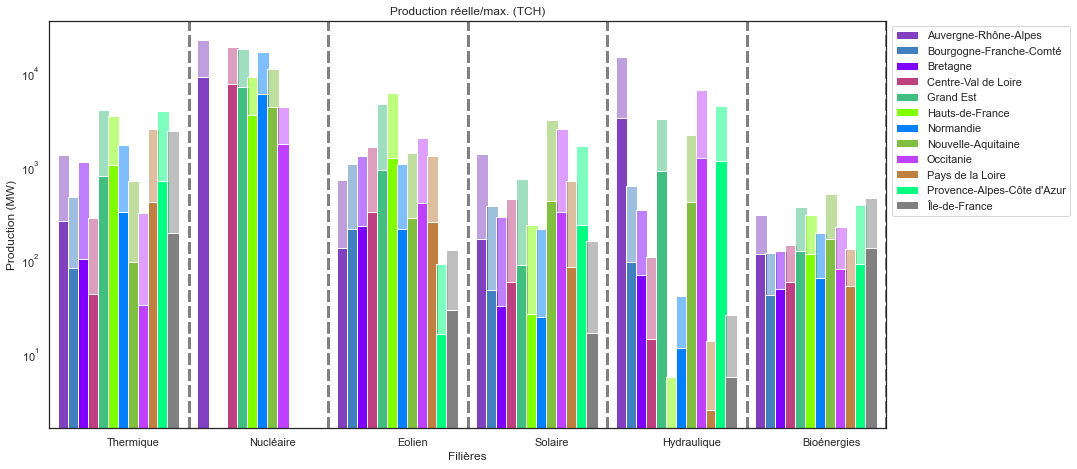

In [138]:
# Création d'un Dataframe contenant uniquement les variables de production et les régions ; les dates sont peu exploitables car ne concernent que la période 2021.
# Suppression des valeurs manquantes sur le TCH thermique uniquement, dont la présence ne dépend pas de la région contairement Nucléaire.
# Pour le Nucléaire, remplacement des valeurs manquantes par 0.
tch = df.dropna(subset = ['TCH Thermique (%)']).iloc[:,[0,8,9,10,11,12,14,17,19,21,23,25,27]]


# Groupement par région
tch_region = tch.groupby('Région', as_index=True).mean()

# Remplacement des NaN du Nucléaire par 0 : on considère une production nulle si pas de données dans une région.
tch_region[['Nucléaire (MW)','TCH Nucléaire (%)']] = tch_region[['Nucléaire (MW)','TCH Nucléaire (%)']].fillna(0)

# TCH = rapport entre production réelle et production théorique maximale
# Création d'une variable de production théorique maximale pour chaque filière
tch_region['Thermique max (MW)'] = tch_region['Thermique (MW)']*100/tch_region['TCH Thermique (%)']
tch_region['Nucléaire max (MW)'] = tch_region['Nucléaire (MW)']*100/tch_region['TCH Nucléaire (%)']
tch_region['Eolien max (MW)'] = tch_region['Eolien (MW)']*100/tch_region['TCH Eolien (%)']
tch_region['Solaire max (MW)'] = tch_region['Solaire (MW)']*100/tch_region['TCH Solaire (%)']
tch_region['Hydraulique max (MW)'] = tch_region['Hydraulique (MW)']*100/tch_region['TCH Hydraulique (%)']
tch_region['Bioénergies max (MW)'] = tch_region['Bioénergies (MW)']*100/tch_region['TCH Bioénergies (%)']

# En cas d'absence de production dans une région, le max. théorique est forcément 0.
# Les NaN – obtenus par division par 0 – sont donc remplacés par 0.
tch_region = tch_region.fillna(0)

# Définition des x du barplot : les régions
x_tch = tch_region.index.to_numpy()
n_regions = len(x_tch)

# Définition des x2 du barplot : les filières
x2_tch = tch_region.columns.to_list()[0:6]
n_filieres = len(x2_tch)

# Création d'une liste de liste de valeurs à partir du Dataframe regroupé(pour exploitation graphique)
liste = tch_region.to_numpy()

# Génération de listes pour les couleurs :
from random import *
c1 = [0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0, 0.5, 0.75, 0.75, 0, 0.5]
c2 = [0.25, 0.5, 0, 0.25, 0.75, 1, 0.5, 0.75, 0.25, 0.5, 1, 0.5]
c3 = [0.75, 0.75, 1, 0.5, 0.5, 0, 1, 0.25, 1, 0.25, 0.5, 0.5]

# Création du barplot
plt.figure(figsize=(15, 7.5))
for j in range(0,n_regions):
    for i in range(0,n_filieres):
        plt.bar(-0.5+i+j/(n_regions+2),liste[j][i],width=1/n_regions,color=(c1[j], c2[j], c3[j]),label=x_tch[j] if i==0 else '') # Production réelle par filière et par région
        plt.bar(-0.5+i+j/(n_regions+2),liste[j][i+n_regions],bottom=liste[j][i],width=1/n_regions,color=(c1[j], c2[j], c3[j], 0.5)) # Production max. théorique superposée par filière et par région       
        plt.axvline(i+0.5-1.25/n_regions,color='gray',linestyle='--')
plt.xticks(range(n_filieres), ['Thermique', 'Nucléaire', 'Eolien', 'Solaire', 'Hydraulique', 'Bioénergies'])
plt.xlim([-0.5-1.25/n_regions,n_filieres+0.5-1.25/n_regions-1])
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left');
plt.title('Production réelle/max. (TCH)')
plt.xlabel('Filières')
plt.ylabel('Production (MW)')
plt.yscale('log')

# Enregistrement du graphique
plt.savefig('tch.png', bbox_inches='tight')

In [139]:
tch_recap = tch.groupby('Région', as_index=True).mean().iloc[:,[6,7,8,9,10,11]]
tch_recap.loc['Moyenne'] = tch_recap.mean(skipna = True)
tch_recap.loc['Écart-type'] = tch_recap.std(skipna = True)
tch_recap = np.round(tch_recap,2)
tch_recap

TCH Thermique (%)  TCH Nucléaire (%)  \
Région                                                             
Auvergne-Rhône-Alpes                    24.23              66.93   
Bourgogne-Franche-Comté                 21.25                NaN   
Bretagne                                10.07                NaN   
Centre-Val de Loire                     18.36              65.69   
Grand Est                               24.31              63.65   
Hauts-de-France                         42.85              65.47   
Normandie                               23.64              56.96   
Nouvelle-Aquitaine                      15.98              65.27   
Occitanie                               11.47              67.27   
Pays de la Loire                        20.09                NaN   
Provence-Alpes-Côte d'Azur              21.48                NaN   
Île-de-France                            8.79                NaN   
Moyenne                                 20.21              64.46   
Écart-type                               8.62               3.25   

                            TCH Eolien (%)  TCH Solaire (%)  \
Région                                                        
Auvergne-Rhône-Alpes                 22.78            14.12   
Bourgogne-Franche-Comté              25.03            14.44   
Bretagne                             21.93            12.50   
Centre-Val de Loire                  25.49            14.65   
Grand Est                            24.32            13.73   
Hauts-de-France                      25.27            12.66   
Normandie                            24.78            12.86   
Nouvelle-Aquitaine                   24.56            15.60   
Occitanie                            24.89            15.04   
Pays de la Loire                     24.25            13.61   
Provence-Alpes-Côte d'Azur           22.10            16.79   
Île-de-France                        29.57            11.58   
Moyenne                              24.58            13.96   
Écart-type                            1.90             1.40   

                            TCH Hydraulique (%)  TCH Bioénergies (%)  
Région                                                                
Auvergne-Rhône-Alpes                      27.91                62.02  
Bourgogne-Franche-Comté                   18.40                55.39  
Bretagne                                  25.26                64.38  
Centre-Val de Loire                       15.30                67.62  
Grand Est                                 39.25                51.57  
Hauts-de-France                           39.49                62.52  
Normandie                                 38.29                49.14  
Nouvelle-Aquitaine                        23.52                50.21  
Occitanie                                 22.76                53.80  
Pays de la Loire                          22.34                67.53  
Provence-Alpes-Côte d'Azur                35.03                30.81  
Île-de-France                             27.74                42.34  
Moyenne                                   27.94                54.78  
Écart-type                                 7.93                10.51

<div style="text-align: justify"><p>Les TCH diffèrent selon les régions pour les filières thermiques, hydrauliques et bioénergies. L’éolien et le solaire sont plus stables de ce point de vue, de même que le nucléaire en excluant le fait que cette filière ne soit pas produite dans toutes les régions.</p>
<p>Le TCH est le plus élevé pour le nucléaire et les bioénergies par rapport aux autres filières. Il y a donc un intérêt à placer les efforts dans l’augmentation de production des autres filières au TCH plus faible.</p>
<p>Ces données doivent néanmoins être relativisées selon les paramètres précédents. D’une part, le TCH est une proportion liée à la production, et il apparaît d’importantes variations de la production en énergies renouvelables en fonction des régions. Ces valeurs sont par ailleurs faibles dans l’ensemble pour les bioénergies dont le TCH est pourtant déjà élevées, ainsi que pour le solaire - bien que permettant un fort levier de croissance relative. Enfin, les faibles TCH  des filières Solaire et Eolien s’expliquent par leur dépendance forte à l’environnement, ce qui limite notre capacité à les faire fluctuer.</p>
<p>L’objectif étant de répondre à la demande de consommation nationale, nous étudierons dans la suite ses valeurs extrêmes annuelles.</p></div>

Min.    Max.  Moyenne     q1     q2     q3    ΔM  \
Auvergne-Rhône-Alpes  24.75   92.41    66.93  58.67  66.40  76.18  0.53   
Centre-Val de Loire   15.72   92.73    65.69  54.59  67.52  77.69 -1.83   
Grand Est             10.89   99.74    63.65  49.66  60.16  78.84  3.49   
Hauts-de-France       20.73  100.53    65.47  51.56  64.96  79.43  0.51   
Normandie             13.15   96.24    56.96  44.70  59.13  71.45 -2.17   
Nouvelle-Aquitaine    18.05  102.01    65.27  48.60  63.82  78.17  1.45   
Occitanie              0.00  100.04    67.27  47.18  57.75  94.43  9.52   

                        ΔMax  
Auvergne-Rhône-Alpes   67.66  
Centre-Val de Loire    77.01  
Grand Est              88.85  
Hauts-de-France        79.80  
Normandie              83.09  
Nouvelle-Aquitaine     83.96  
Occitanie             100.04

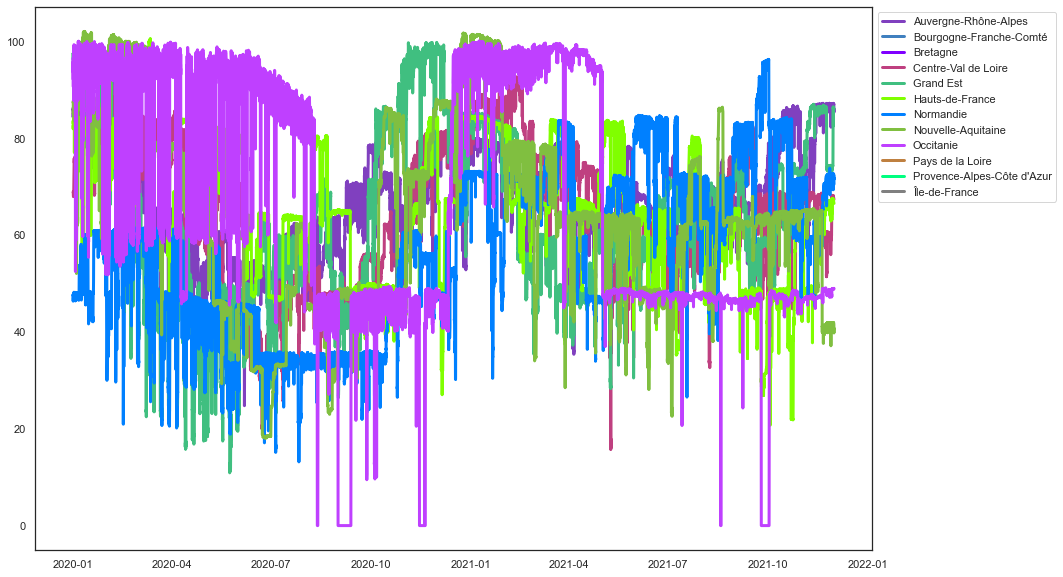

In [140]:
# 1 Kernel par période afin de présenter 1 Dataframe par période pour plus de lisibilité.
tch_nucleaire = df.dropna(subset = ['TCH Nucléaire (%)']).iloc[:,[0,9,19]]

# Création d'une variable de regroupement par 1 jour
#tch_nucleaire['TCH Nucléaire moyen sur 1 jour (%)'] = tch_nucleaire['TCH Nucléaire (%)'].rolling(48).mean()

# /!\ Les regroupements doivent être réalisés par région...
fig = plt.figure(figsize = (15,10))
for i in range(len(regions)):  
    #tch_nucleaire['TCH Nucléaire moyen sur 1 jour (%)'].loc[tch_nucleaire['Région'] == regions[i]] = tch_nucleaire[tch_nucleaire['Région'] == regions[i]]['TCH Nucléaire (%)'].rolling(48).mean()
    #tch_regions.append(tch_nucleaire[tch_nucleaire['Région'] == regions[i]]['TCH Nucléaire (%)'] if i==0 else tch_regions[i-1]+tch_nucleaire[tch_nucleaire['Région'] == regions[i]]['TCH Nucléaire (%)'] if tch_nucleaire[tch_nucleaire['Région'] == regions[i]]['TCH Nucléaire (%)'].mean()>0 else tch_regions[i-1])
                          #dates.append(tch_regions['Régions'].drop_duplicates())
    plt.plot(tch_nucleaire.index[tch_nucleaire['Région'] == regions[i]],tch_nucleaire[tch_nucleaire['Région'] == regions[i]]['TCH Nucléaire (%)'], color=couleurs_regions[i],label=regions[i])
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')


# Initiation de listes de consommation par région : min, max et moyenne
min, max, moyenne, q1, q2, q3 = [], [], [], [], [], []

for i in range(len(regions)):
    min.append(tch_nucleaire['TCH Nucléaire (%)'][tch_nucleaire['Région'] == regions[i]].min())
    max.append(tch_nucleaire['TCH Nucléaire (%)'][tch_nucleaire['Région'] == regions[i]].max())
    moyenne.append(tch_nucleaire['TCH Nucléaire (%)'][tch_nucleaire['Région'] == regions[i]].mean())
    q1.append(tch_nucleaire['TCH Nucléaire (%)'][tch_nucleaire['Région'] == regions[i]].quantile(q=0.25))
    q2.append(tch_nucleaire['TCH Nucléaire (%)'][tch_nucleaire['Région'] == regions[i]].quantile(q=0.5))
    q3.append(tch_nucleaire['TCH Nucléaire (%)'][tch_nucleaire['Région'] == regions[i]].quantile(q=0.75))

tch_nucleaire = pd.DataFrame(index=regions,
                                          data={'Min.':min,
                                                'Max.':max,
                                                'Moyenne':moyenne,
                                                'q1':q1,
                                                'q2':q2,
                                                'q3':q3})

tch_nucleaire['ΔM'] = tch_nucleaire['Moyenne']-tch_nucleaire['q2']
tch_nucleaire['ΔMax'] = tch_nucleaire['Max.']-tch_nucleaire['Min.']
tch_nucleaire.dropna(inplace=True)

tch_nucleaire.round(2).head(7)


<p>On note un important décalage dans les TCH pour une même région. L'Occitanie particulièrement affiche d'importants écarts – y compris entre la moyenne et la médiane – expliqués par un nombre très limité de centrales nucléaires dans la région. Ainsi, l'arrêt d'un réacteur nucléaire a un impact trop important pour se focaliser sur le TCH des régions.
<p>Il est plus judicieux de considérer l'évolution de la production nucléaire à l'échelle nationale afin de déduire une base minimale.


## 2. À quelle production nationale du Nucléaire minimale faut-il s'attendre ?

Nous nous baserons sur l'historique de production des dernières années afin de vérifier s'il est possible d'en extraire une base minimale de production avec un niveau de confiance suffisant.

Production nucléaire minimale à l'échelle nationale (95 %): 23093 MW.


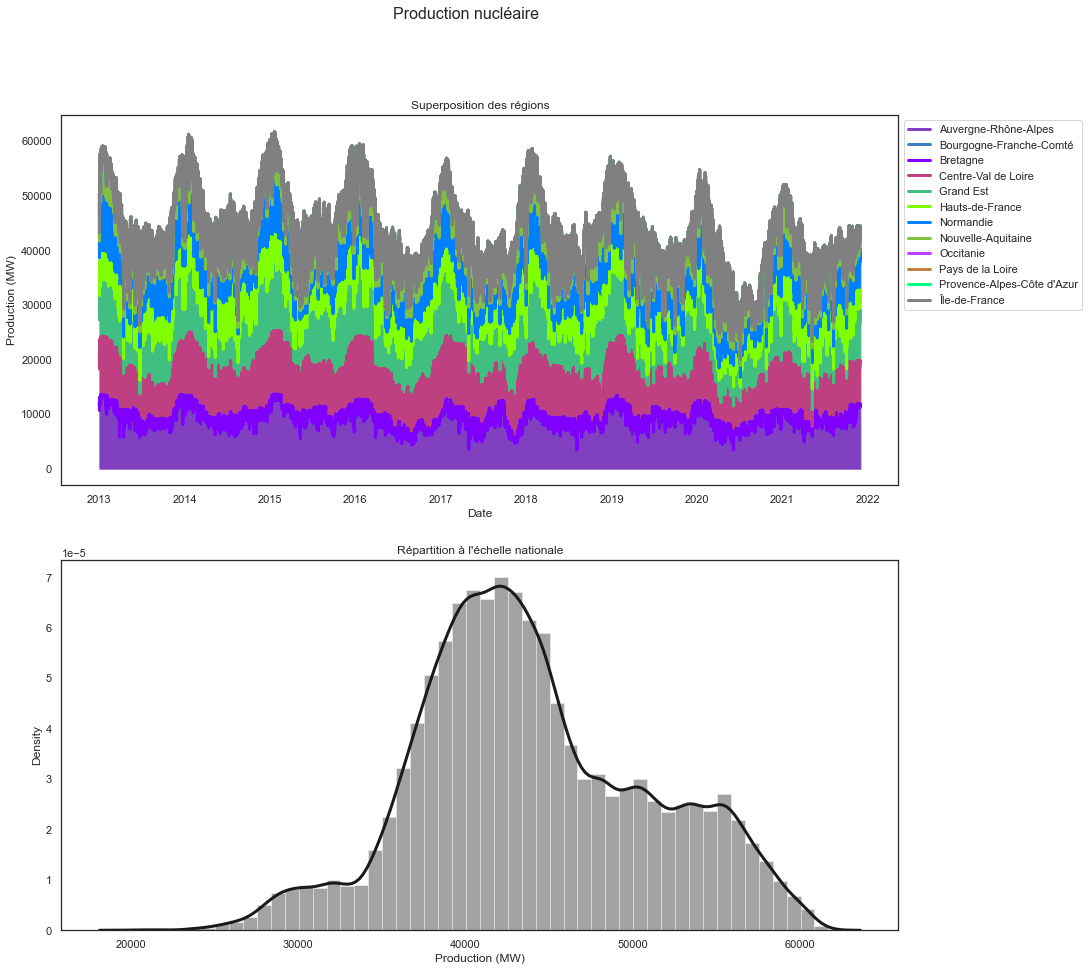

In [141]:
# 1 Kernel par période afin de présenter 1 Dataframe par période pour plus de lisibilité.
nucleaire = df.dropna(subset = ['Nucléaire (MW)']).iloc[:,[0,9,19]]

# Création d'une colonne par région pour la production et le TCH nucléaires
for i in range(len(regions)):
    nucleaire['Production '+regions[i]+' (MW)'] = nucleaire[nucleaire['Région']==regions[i]]['Nucléaire (MW)']
    nucleaire['TCH '+regions[i]+' (%)'] = nucleaire[nucleaire['Région']==regions[i]]['TCH Nucléaire (%)']

nucleaire.drop(['Région', 'Nucléaire (MW)', 'TCH Nucléaire (%)'], axis=1, inplace=True) # Suppression des colonnes devenues inutiles 
nucleaire = nucleaire.groupby(nucleaire.index).max() # Groupement selon la date
nucleaire.fillna(0, inplace=True) # Les NaN restants sont associés à une absence de production : traitement plus simple en les remplaçant par 0

# Initialisation d'une liste associée aux productions nucléaires pour permettre une superposition simplifiée des courbes dans une boucle
prod_nucleaire = []

# Superposition des valeurs de production régionale dans la liste
for i in range(len(regions)):
    prod_nucleaire.append(nucleaire['Production '+regions[i]+' (MW)'] if i==0 else nucleaire['Production '+regions[i]+' (MW)']+prod_nucleaire[i-1])

# Courbes des productions nucléaires superposées
fig = plt.figure(figsize = (15,15))
plt.suptitle('Production nucléaire', fontsize=16)
for i in range(len(regions)):
    plt.subplot(2,1,1)
    plt.plot(prod_nucleaire[i], label=regions[i], color=couleurs_regions[i])
    plt.fill_between(nucleaire.index, prod_nucleaire[i-1] if i>0 else 0, prod_nucleaire[i], color=couleurs_regions[i])
    plt.title('Superposition des régions')
    plt.xlabel('Date')
    plt.ylabel('Production (MW)')
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left');

# Répartition des valeurs de production nucléaire
plt.subplot(2,1,2)
plt.title("Répartition à l'échelle nationale")
sns.distplot(prod_nucleaire[len(regions)-1], kde=True, color='k')
plt.xlabel('Production (MW)')
#plt.plot(norm.pdf(x_axis, mean, sd))
prod_nucleaire_mini_95 = prod_nucleaire[len(regions)-1].mean()-3*prod_nucleaire[len(regions)-1].std()
print("Production nucléaire minimale à l'échelle nationale (95 %):",round(prod_nucleaire_mini_95),'MW.')

<p>La filière nucléaire semble suivre une loi normale de laquelle nous pouvons déduire une production minimale d'environ 25 GW à l'échelle nationale. Cela nous servira de base afin de déduire la puissance restant à fournir par les 2 leviers restants - le thermique et l'hydraulique. On considérera le pire scénario possible, à savoir une consommation à son maximum et l'absence d'énergies renouvelables dont la production est trop aléatoire.
<p>Dans cette logique, nous souhaitons néanmoins vérifier la capacité constante des filières thermique et hydraulique en nous basant sur leurs TCH respectifs pour déduire leur capacité maximale de production

## 3. Les capacités maximales de productions thermiques et hydrauliques sont-elles constantes ?

Puisque nous utilisons le TCH, notre étude portera uniquement sur l'année 2021 pour laquelle nous avons à la fois les valeurs de production et leurs TCH associés.

Production thermique + hydraulique minimales à l'échelle nationale (95 %): 43334 MW.


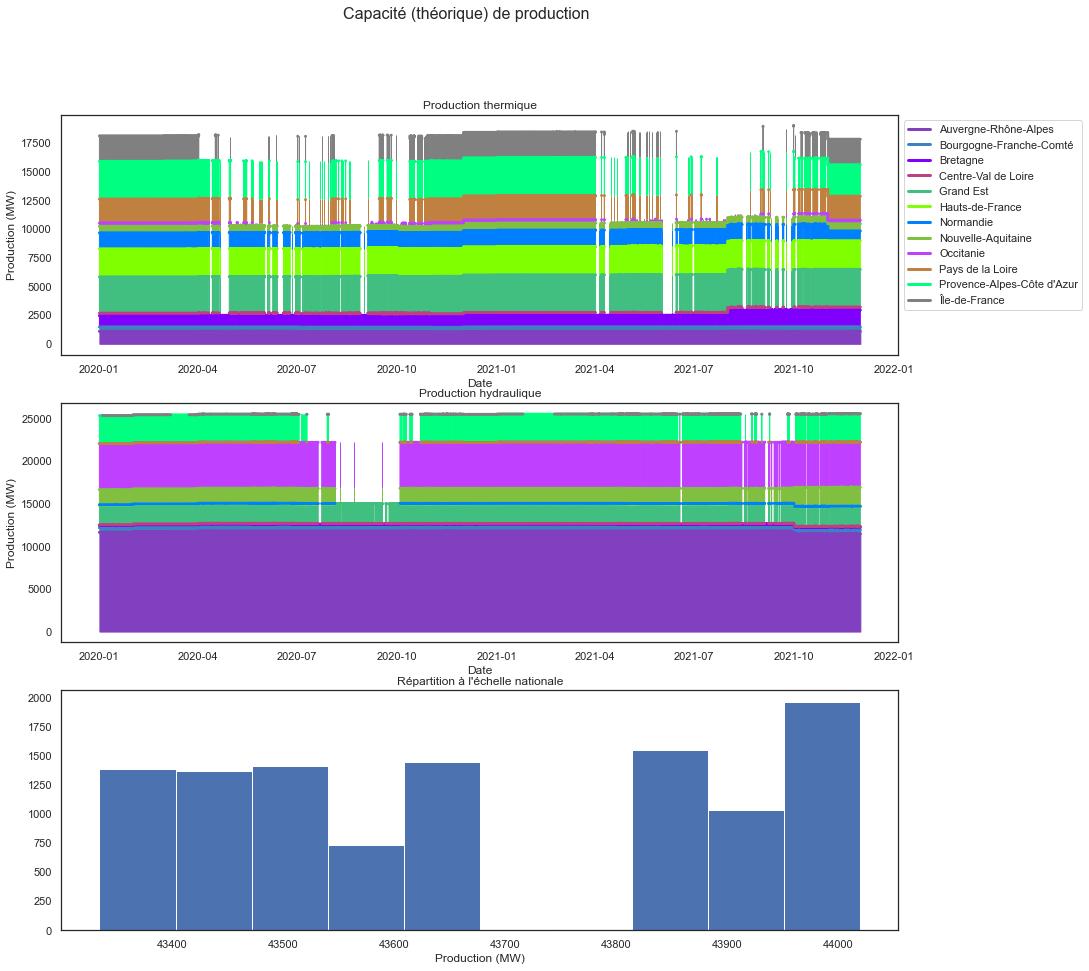

In [149]:
# 1 Kernel par période afin de présenter 1 Dataframe par période pour plus de lisibilité.
thermique = df.dropna(subset = ['TCH Thermique (%)']).iloc[:,[0,8,17]]
hydraulique = df.dropna(subset = ['TCH Hydraulique (%)']).iloc[:,[0,12,25]]

# Création d'une colonne par région pour la production et le TCH thermiques
for i in range(len(regions)):
    thermique['Production '+regions[i]+' (MW)'] = thermique[thermique['Région']==regions[i]]['Thermique (MW)']
    hydraulique['Production '+regions[i]+' (MW)'] = hydraulique[hydraulique['Région']==regions[i]]['Hydraulique (MW)']
    thermique['TCH '+regions[i]+' (%)'] = thermique[thermique['Région']==regions[i]]['TCH Thermique (%)']
    hydraulique['TCH '+regions[i]+' (%)'] = hydraulique[hydraulique['Région']==regions[i]]['TCH Hydraulique (%)']

thermique.drop(['Région', 'Thermique (MW)', 'TCH Thermique (%)'], axis=1, inplace=True) # Suppression des colonnes devenues inutiles 
hydraulique.drop(['Région', 'Hydraulique (MW)', 'TCH Hydraulique (%)'], axis=1, inplace=True) # Suppression des colonnes devenues inutiles 
thermique = thermique.groupby(thermique.index).max() # Groupement selon la date
hydraulique = hydraulique.groupby(hydraulique.index).max() # Groupement selon la date
thermique.fillna(0, inplace=True) # Les NaN restants sont associés à une absence de production : traitement plus simple en les remplaçant par 0
hydraulique.fillna(0, inplace=True) # Les NaN restants sont associés à une absence de production : traitement plus simple en les remplaçant par 0

# Initialisation de listes associées aux productions thermiques et hydrauliques pour permettre une superposition simplifiée des courbes dans une boucle
prod_thermique = []
prod_hydraulique = []

# Superposition des valeurs de production régionale dans la liste
for i in range(len(regions)):
    prod_thermique.append(100*thermique['Production '+regions[i]+' (MW)']/thermique['TCH '+regions[i]+' (%)'] if i==0 else 100*thermique['Production '+regions[i]+' (MW)']/thermique['TCH '+regions[i]+' (%)']+prod_thermique[i-1])
    prod_hydraulique.append(100*hydraulique['Production '+regions[i]+' (MW)']/hydraulique['TCH '+regions[i]+' (%)'] if i==0 else 100*hydraulique['Production '+regions[i]+' (MW)']/hydraulique['TCH '+regions[i]+' (%)']+prod_hydraulique[i-1])

# Courbes des productions thermiques et hydrauliques superposées
fig = plt.figure(figsize = (15,15))
plt.suptitle('Capacité (théorique) de production', fontsize=16)
for i in range(len(regions)):
    plt.subplot(3,1,1)
    plt.plot(prod_thermique[i], label=regions[i], color=couleurs_regions[i])
    plt.fill_between(thermique.index, prod_thermique[i-1] if i>0 else 0, prod_thermique[i], color=couleurs_regions[i])
    plt.title('Production thermique')
    plt.xlabel('Date')
    plt.ylabel('Production (MW)')
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left');
    
    plt.subplot(3,1,2)
    plt.plot(prod_hydraulique[i], label=regions[i], color=couleurs_regions[i])
    plt.fill_between(hydraulique.index, prod_hydraulique[i-1] if i>0 else 0, prod_hydraulique[i], color=couleurs_regions[i])
    plt.title('Production hydraulique')
    plt.xlabel('Date')
    plt.ylabel('Production (MW)');

# Répartition des valeurs de production thermique
plt.subplot(3,1,3)
plt.title("Répartition à l'échelle nationale")
plt.hist(prod_thermique[len(regions)-1]+prod_hydraulique[len(regions)-1])
plt.xlabel('Production (MW)')
prod_thermique_hydraulique_mini = (prod_thermique[len(regions)-1]+prod_hydraulique[len(regions)-1]).min()
print("Production thermique + hydraulique minimales à l'échelle nationale :",round(prod_thermique_hydraulique_mini),'MW.')

<p>On note une capacité de production constante pour les filières thermique et hydraulique sur la majorité de l'année 2021 avec néanmoins quelques cas d'absence de plusieurs jours sur certaines régions. Un minimum est néanmoins toujours assuré car ce profil est compensé par les 2 filières et les régions.
<p>Il est ainsi intéressant d'étudier la distribution de la capacité totale de production des 2 filières combinées. Il en ressort des valeurs très concentrées entre 43 et 44 GW, d'où la précision du résultat minimal, cette fois-ci directement issu de la plus faible valeur relevée par la somme des capacités des filières.

## 4. Dans le pire scénario, les productions stables (nucléaires, thermiques et hydrauliques) permettent-elles d'assurer les consommations les plus élevées ?

<p>Nous souhaitons confronter les consommations les plus élevées aux productions des filières maîtrisées – nucléaire, thermique et hydraulique – afin de vérifier si celles-ci suffiraient même en scénario défavorable.
<p>Dans cette logique, nous allons basiquement tenter d'établir un ordre de grandeur maximal de consommation attendu, de la même manière que nous l'avons fait pour les productions minimales.

Consommation maximale à l'échelle nationale (95 %): 89318 MW.


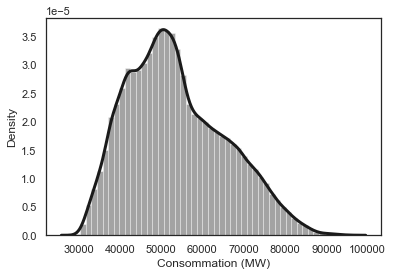

In [150]:
# Suppression des valeurs manquantes de consommation
conso = df.dropna(subset = ['Consommation (MW)'])

conso = conso.groupby(conso.index, as_index=True).sum().iloc[:,4] # Sommes des consommations régionales par année pour récupérer la valeur nationale

sns.distplot(conso, kde=True, color='k')

conso_maxi_95 = conso.mean()+3*conso.std()
print("Consommation maximale à l'échelle nationale (95 %):",round(conso_maxi_95),'MW.')


In [63]:
print("Production restant à fournir pour assurer la consommation maximale :",round(conso_maxi_95-prod_thermique_hydraulique_mini_95-prod_nucleaire_mini_95),'MW.')

Production restant à fournir pour assurer la consommation maximale : 20893 MW.


<p>Les productions "stables" pourraient donc ne pas suffire à elles seules à éviter un Black-Out en situation défavorable.
<p>Deux pistes sont alors exploitables en parallèle d'une prédiction de la consommation :
<p>1. <i>Augmenter la production</i> : nous nous focaliseront cette fois sur les énergies renouvelables.
<p>2. <i>Réduire la consommation</i> : l'année "Covid" représente une source d'information particulièrement riche car elle permet de se représenter l'écart de consommation entre une activité industrielle normale et sa réduction à l'essentiel.

### → Piste n°1 : Augmenter la production via les énergies renouvelables

Nous n'avions pas pris en compte les énergies renouvelables qui dépendent de l'environnement : éolien, solaire et bioénergies. Nous allons en calculer la production moyenne sur les dernières années.

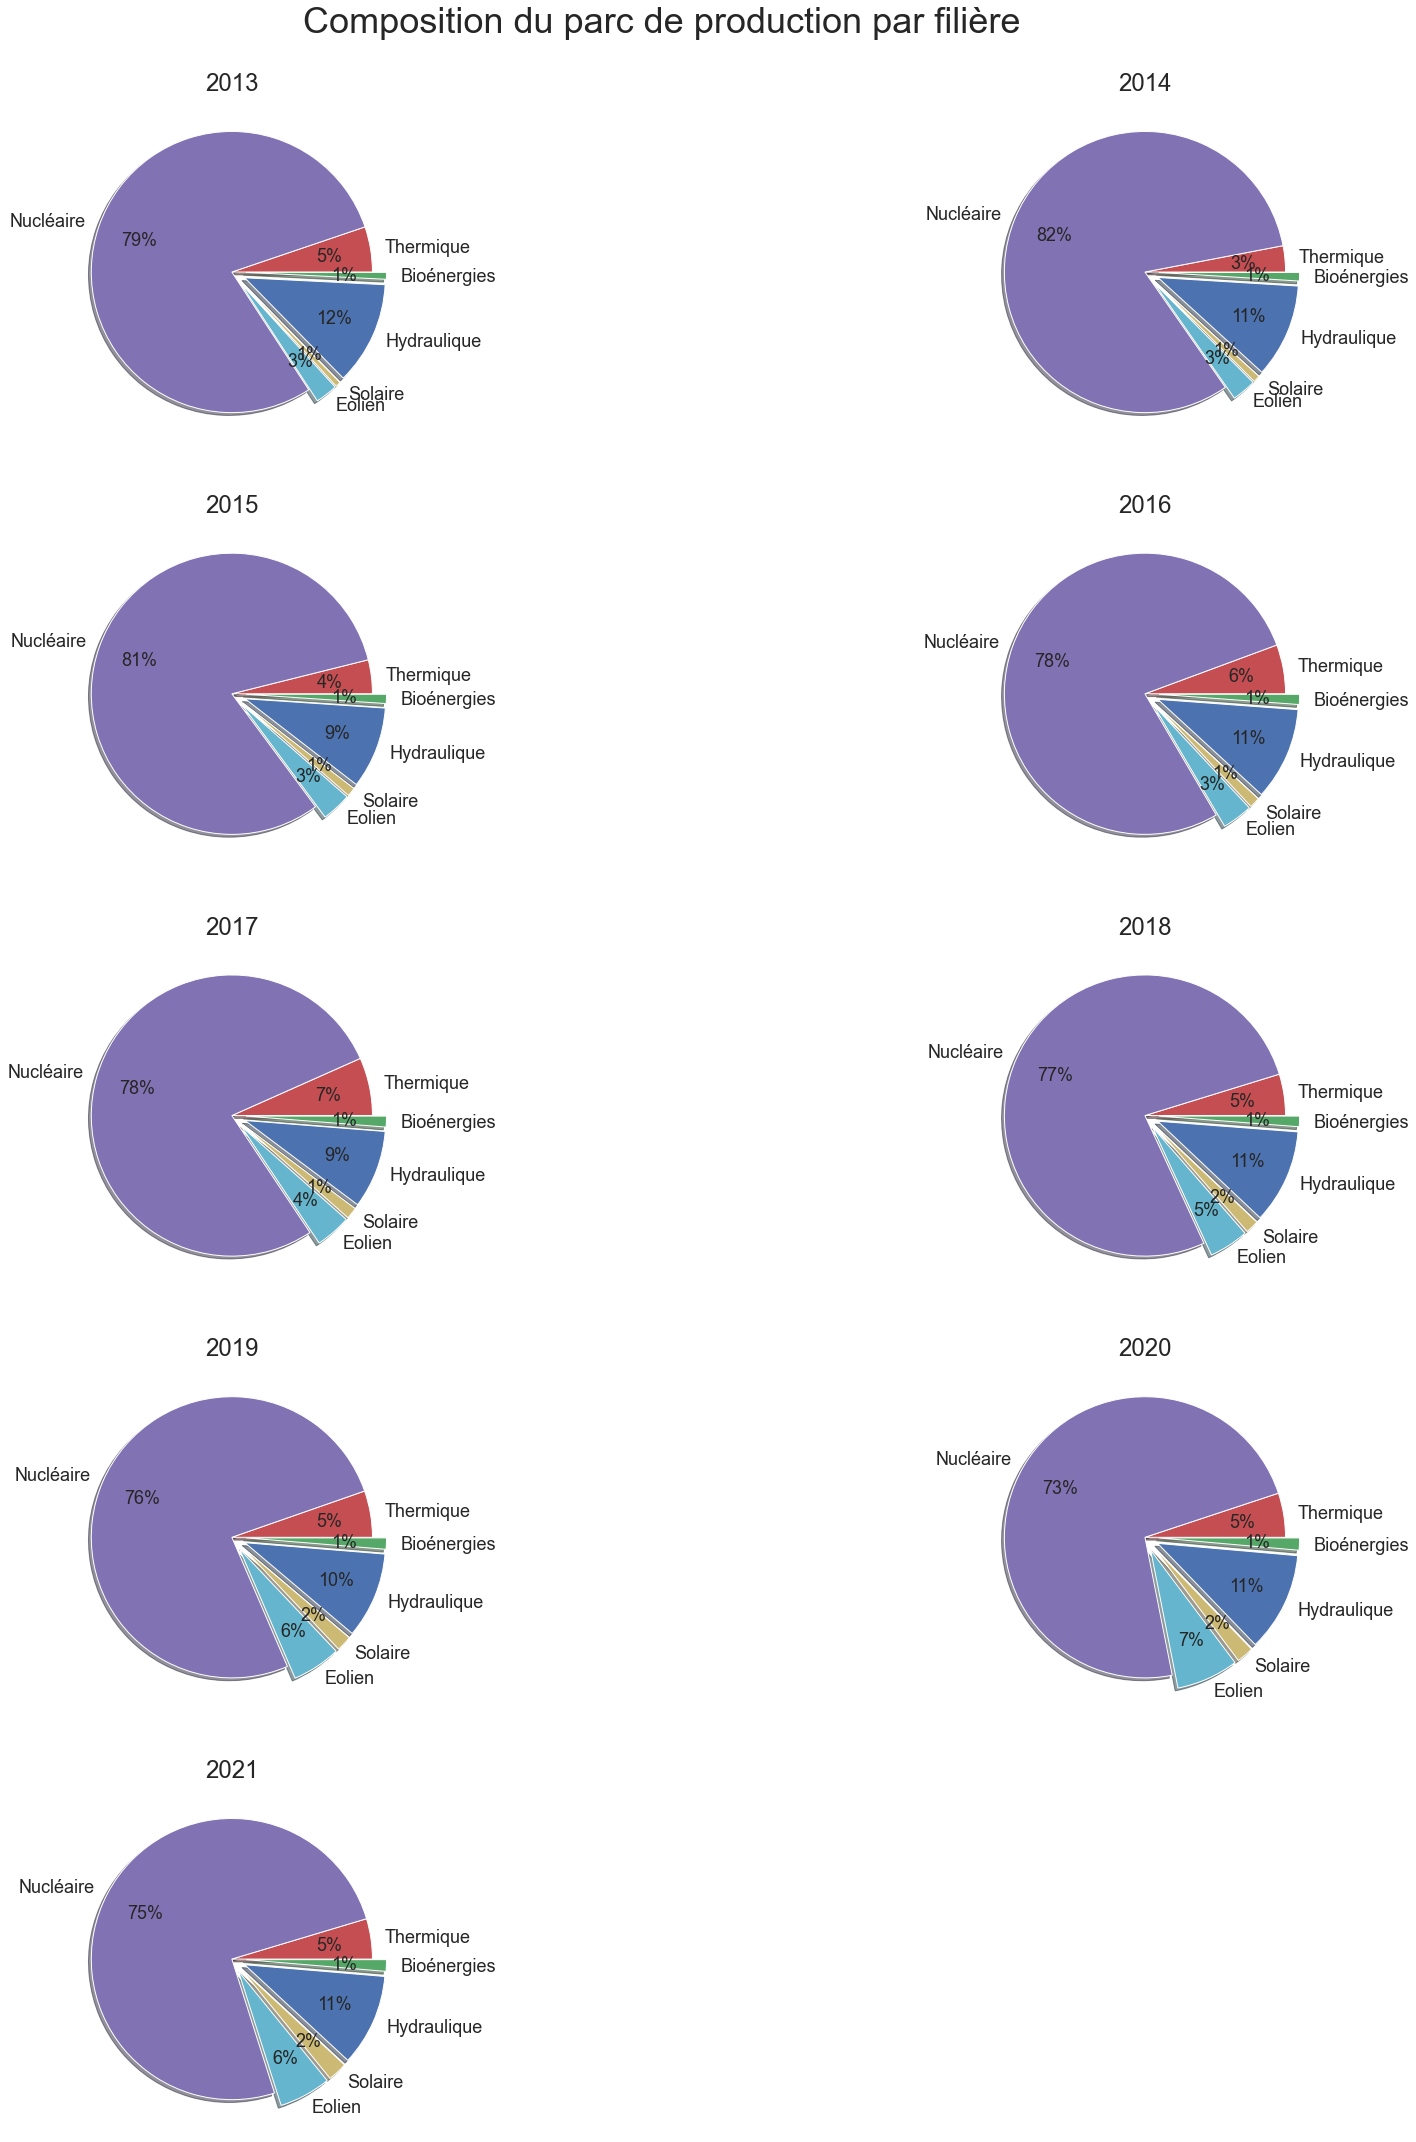

In [151]:
# Tris de données 
parc = df.dropna(subset = ['Thermique (MW)','Nucléaire (MW)','Eolien (MW)','Solaire (MW)','Hydraulique (MW)','Bioénergies (MW)'])

parc.head()

# Regroupement moyen par année pour chaque filière
parc = parc.groupby(['Année','Région']).mean().iloc[:,[4,5,6,7,8,10]] # Moyennes par année par région
parc = parc.groupby('Année', as_index=True).sum() # Sommes des productions régionales par année pour récupérer la valeur nationale

# Dimensions de la figure ajustées selon le nombre de DataViz' (1 par an)
hauteur = int(ceil(len(parc.index)/2))
if len(parc.index)/2 < 1:
    largeur = 1
else:
    largeur = 2
    
# Création de la figure
plt.figure(figsize = (15*largeur, 15*hauteur/largeur))

# DataViz'("Camemberts")
plt.suptitle('Composition du parc de production par filière', y = 0.98-hauteur/75, fontsize=36) 
for i in range(0,len(parc.index)): # Création d'1 DataViz' par an
    plt.subplot(hauteur,largeur,1+i)
    plt.title(parc.index[i], fontsize=24)
    plt.pie(parc.to_numpy()[i], # Liste de valeurs
            labels = parc.columns.str.strip(' (MW)').to_list(), # Colonnes renommées sans l'unité pour cohérence et allégement du DataViz'
            autopct = lambda x: str(round(x)) + '%', # Pourcentage arrondis à l'unité pour meilleure lisibilité
            explode = [0, 0, 0.1, 0.1, 0.1, 0.1], # Choix arbitraire de faire ressortir les données d'énergie renouvelable
            pctdistance = 0.7,
            shadow = True,
            textprops = {"fontsize":18},
            colors = couleurs_filieres);

# Enregistrement du graphique
plt.savefig('parc_production_filiere.png')

<div style="text-align: justify"><p>La tendance de production relative est à la baisse pour les énergies nucléaires et thermiques au profit des énergies renouvelables, en particulier éoliennes et solaires.</p>
<p>Cela s’explique par l’accent mis sur ces filières depuis les dernières années avec la mise en place à plus grande échelle de panneaux solaires et d’éoliennes.</p>
<p>Ces deux filières portent majoritairement cette accentuation de la part de l’énergie renouvelable, laquelle est traitée plus en détails ci-après au regard de la consommation.</p></div>


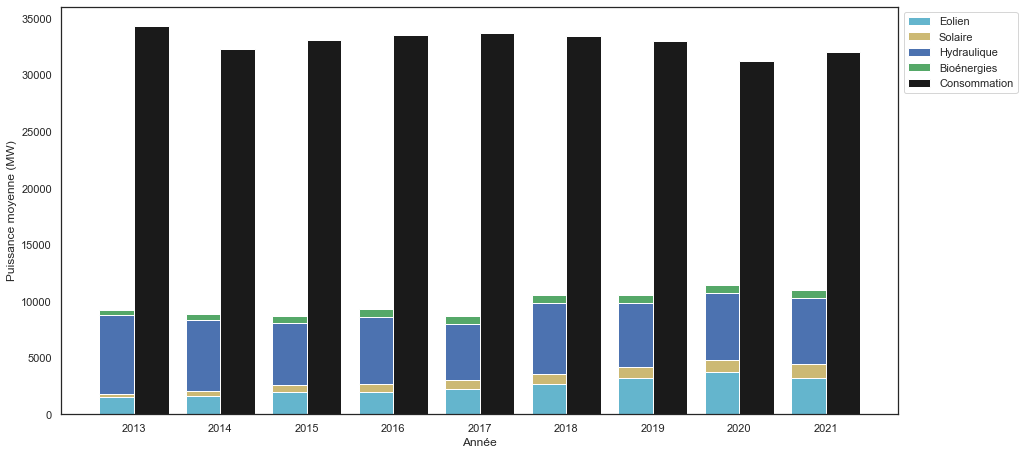

In [152]:
# Suppression des valeurs manquantes de consommation et production
energies = df.dropna(subset = ['Consommation (MW)','Thermique (MW)','Nucléaire (MW)','Eolien (MW)','Solaire (MW)','Hydraulique (MW)','Bioénergies (MW)'])

# Dataframes des consommations et productions moyennes annuelles
conso_moy = energies.groupby(['Année','Région']).mean().iloc[:,[3,4,5,6,7,8,10]] # Moyennes par année par région
conso_moy = conso_moy.groupby('Année', as_index=True).sum() # Sommes des consommations et productions régionales par année pour récupérer la valeur nationale

# Etablissement des positions et largeurs
barWidth = -0.4
x1 = range(len(conso_moy))
x2 = [r - barWidth for r in x1 ]

# Energies renouvelables
index_renouvelables = [3, 4, 5, 6, 7]
energies_renouvelables = conso_moy[conso_moy.columns.to_list()[index_renouvelables[0]:index_renouvelables[-1]]]
energies_renouvelables.columns.to_list()[0]

# Création de la figure
plt.figure(figsize=(15, 7.5))

# Barplot des productions annuelles par filière
bottom = 0 # Initialisation d'une variable de superposition des barres de filières
for j in range(0, energies_renouvelables.shape[1]): # Boucle par filière
    bottom += conso_moy[energies_renouvelables.columns.to_list()[j-1]] if j>0 else 0
    plt.bar(x1,
            energies_renouvelables[energies_renouvelables.columns.to_list()[j]], # 1 barplot par filière
            bottom = bottom, # Superposition des barres de filières
            width = barWidth,
            align = 'edge',
            label = energies_renouvelables.columns.str.strip(' (MW)').to_list()[j], # Colonnes renommées sans l'unité pour cohérence et allégement du DataViz'
            color = couleurs_filieres[j+index_renouvelables[0]-1]) # Couleurs harmonisées avec autres DataViz'


# Barplot de la consommation annuelle
plt.bar(x2,
        conso_moy['Consommation (MW)'],
        width = barWidth,
        align = 'edge',
        label = 'Consommation',
        color='k');

# Axes et légendes
plt.xticks(range(conso_moy.shape[0]), conso_moy.index) # Précision des années en abcisses
plt.xlabel('Année')
plt.ylabel('Puissance moyenne (MW)')
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left'); # Légende hors cadre pour meilleure lisibilité

# Enregistrement du graphique
plt.savefig('conso_renouvelable.png', bbox_inches='tight')

In [153]:
part_renouvelable = conso_moy
part_renouvelable['Production renouvelable (MW)'] = round((part_renouvelable['Eolien (MW)']+part_renouvelable['Solaire (MW)']+part_renouvelable['Hydraulique (MW)']+part_renouvelable['Bioénergies (MW)']),1)
part_renouvelable["Part de l'énergie renouvelable (%)"] = round((part_renouvelable['Production renouvelable (MW)']/part_renouvelable['Consommation (MW)']*100),1)
part_renouvelable['Consommation (MW)'] = round(part_renouvelable['Consommation (MW)'],2)
part_renouvelable = part_renouvelable.drop(['Thermique (MW)','Nucléaire (MW)','Eolien (MW)','Solaire (MW)','Hydraulique (MW)','Bioénergies (MW)'], axis=1)
part_renouvelable

Consommation (MW)  Production renouvelable (MW)  \
Année                                                    
2013            34315.59                        9205.3   
2014            32315.12                        8890.0   
2015            33093.91                        8687.9   
2016            33514.74                        9284.1   
2017            33659.74                        8700.1   
2018            33441.08                       10540.1   
2019            32975.79                       10542.1   
2020            31265.10                       11440.0   
2021            32042.01                       10960.9   

       Part de l'énergie renouvelable (%)  
Année                                      
2013                                 26.8  
2014                                 27.5  
2015                                 26.3  
2016                                 27.7  
2017                                 25.8  
2018                                 31.5  
2019                                 32.0  
2020                                 36.6  
2021                                 34.2

<div style="text-align: justify"><p>À une baisse de la consommation annuelle est associée une augmentation de la production en énergies renouvelables. Cela accroît donc d’autant plus la part de l’énergie renouvelable dans la consommation, qui passe d’environ un quart à un plus d’un tiers en huit ans. La production éolienne semble être le levier le plus important, bien qu’en proportion le solaire - nettement plus faible - ait le plus augmenté ces dernières années.</p>
<p>Il apparaît cependant qu’à l’échelle annuelle et nationale, la consommation reste fortement liée à la production thermique.</p></div>

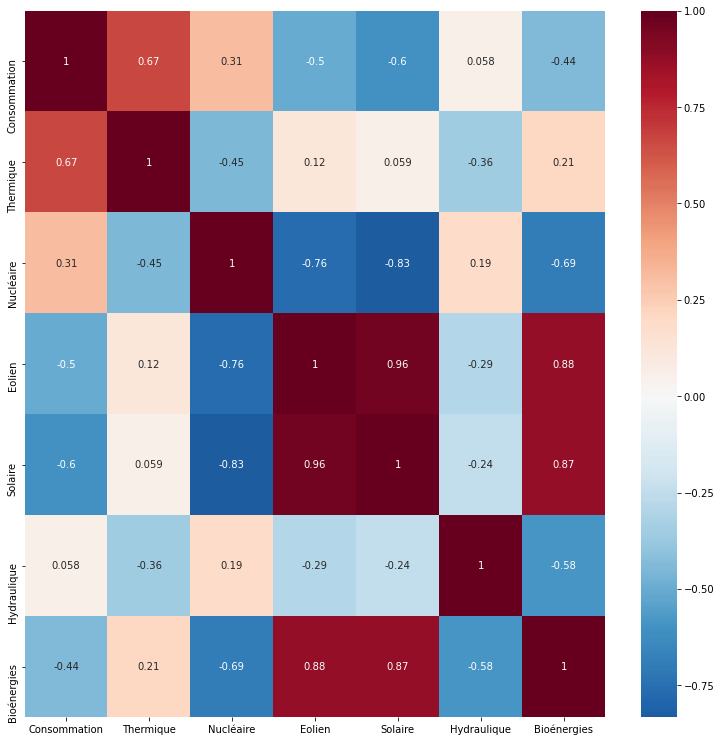

In [63]:
from sklearn import model_selection, preprocessing
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import scipy.stats as stats
import seaborn as sns

plt.figure(figsize=(13, 13))

sns.heatmap(conso_moy.iloc[:,[0,1,2,3,4,5,6]].corr(), annot=True, cmap="RdBu_r", center=0, xticklabels=conso_moy.iloc[:,[0,1,2,3,4,5,6]].columns.str.strip(' (MW)').to_list(), yticklabels=conso_moy.iloc[:,[0,1,2,3,4,5,6]].columns.str.strip(' (MW)').to_list());

# Enregistrement de la matrice de corrélation
plt.savefig('corr_part_renouvelable.png')

<div style="text-align: justify"><p>Pour l’heure, il n’est donc pas encore possible de compter uniquement sur ces énergies afin de combler les futurs besoins en consommation, dont la baisse combinée à la hausse de production d’énergies renouvelables ne sont pas suffisants.</p></div>

In [154]:
print('La production moyenne des énergies renouvelables (hors hydraulique) est de',round(energies_renouvelables['Eolien (MW)'].mean()+energies_renouvelables['Solaire (MW)'].mean()+energies_renouvelables['Bioénergies (MW)'].mean()),'MW.')

La production moyenne des énergies renouvelables (hors hydraulique) est de 3884 MW.


<p>L'ordre de grandeur de production d'énergies renouvelables est insuffisant pour répondre à un éventuel scénario de forte consommation pour faible productions contrôlées.
<p>Cela justifie la nécessité d'accroître la production de ces filières. En effet, si comme nous l'avons vu les énergies renouvelables représentent une faible proportion, elles sont également très inégalement réparties entre les régions.

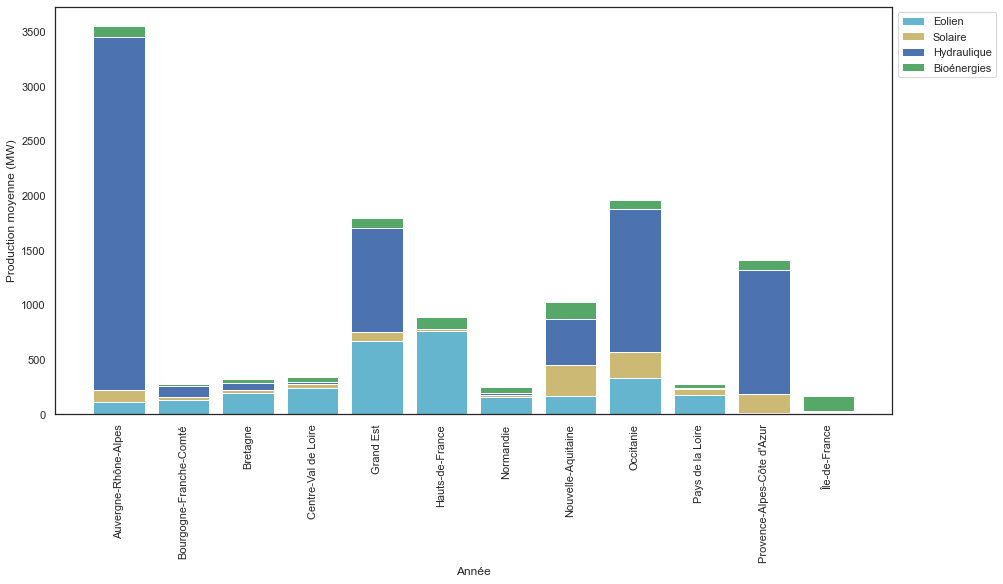

In [155]:
# Suppression des valeurs manquantes de production d'énergie renouvelable
e_r = df.dropna(subset = ['Eolien (MW)','Solaire (MW)','Hydraulique (MW)','Bioénergies (MW)'])

# Dataframes des productions moyennes annuelles en énergies renouvelables
prod_renouvelable_region = e_r.groupby('Région', as_index=True).mean().iloc[:,[4,7,8,9,11]]

# Energies renouvelables
index_renouvelables = range(1,6)
energies_renouvelables = prod_renouvelable_region[prod_renouvelable_region.columns.to_list()[index_renouvelables[0]:index_renouvelables[-1]]]

# Création de la figure
plt.figure(figsize=(15, 7.5))

# Barplot des productions annuelles par filière
bottom = 0 # Initialisation d'une variable de superposition des barres de filières
for j in range(0, energies_renouvelables.shape[1]): # Boucle par filière
    bottom += prod_renouvelable_region[energies_renouvelables.columns.to_list()[j-1]] if j>0 else 0
    plt.bar(regions,
            energies_renouvelables[energies_renouvelables.columns.to_list()[j]], # 1 barplot par filière
            bottom = bottom, # Superposition des barres de filières
            label = energies_renouvelables.columns.str.strip(' (MW)').to_list()[j], # Colonnes renommées sans l'unité pour cohérence et allégement du DataViz'
            color = couleurs_filieres[j+2]) # Couleurs harmonisées avec autres DataViz'

# Axes et légendes
plt.xticks(range(prod_renouvelable_region.shape[0]), prod_renouvelable_region.index, rotation=90) # Précision des années en abcisses
plt.xlabel('Année')
plt.ylabel('Production moyenne (MW)')
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left'); # Légende hors cadre pour meilleure lisibilité

# Enregistrement du graphique
plt.savefig('conso_renouvelable_region.png', bbox_inches='tight')


<p>Si les différences de superficie et de météo dans les différentes régions peuvent partiellement expliquer ces écarts – comme nous l'avons vu précédemment – on visualise un contraste élevé. Il est probablement possible de fortement augmenter ces productions de façon significative à l'échelle nationale.
<p>D'autres axes de travail en parallèle sont néanmoins nécessaires afin de prévenir les décalages production/consommation. Les filières renouvelables sont en effet trop soumises aux aléas météorologiques comme nous l'avons vu. C'est d'autant plus essentiel le temps que la production renouvelable suffise à couvrir les besoins énergétiques, ce qui n'est pas le cas aujourd'hui.
<p>L'intérêt des prédictions de consommation que nous verrons plus tard est donc majeur pour assurer le coup via les autres filières, lesquelles permettent une meilleure maîtrise.
<p>On peut également le voir sous l'angle opposé : plutôt qu'utiliser les filières de production maîtrisées comme levier, nous pouvons aussi jouer sur la consommation en assurant sa baisse si nécessaire.

### → Piste n°2 : Diminuer la consommation

L'année "Covid" représente une source d'information riche car elle permet de se représenter l'écart de consommation entre une activité industrielle "normale" et sa réduction à l'essentiel.

La consommation sur le mois d'Avril avec limitation des activités industrielles était de 81 % de la valeur moyenne habituelle.
Cela représente un levier de 9638 MW.


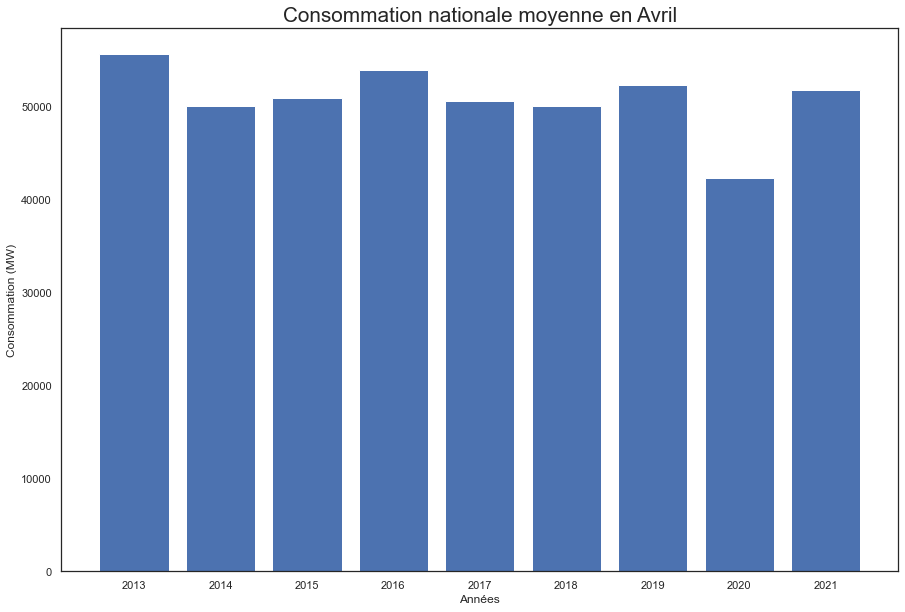

In [237]:
conso_covid = df.dropna(subset=['Consommation (MW)'])
conso_covid = conso_covid.groupby('Datetime').sum()

# Création d'une colonne "Date" issue de l'index (format "Datetime") afin de pouvoir récupérer plus facilement les années et périodes souhaitées
conso_covid['Date'] = conso_covid.index

conso_covid = conso_covid[['Date', 'Consommation (MW)']]
conso_covid['Année'] = conso_covid['Date'].dt.year

conso_covid['Mois'] = conso_covid['Date'].dt.month

conso_covid = conso_covid.groupby(['Année', 'Mois'], as_index=False).mean()

conso_covid = conso_covid[conso_covid['Mois']==4] # Dataframe pour le mois d'Avril uniquement

plt.figure(figsize=(15, 10))
plt.bar(conso_covid['Année'], conso_covid['Consommation (MW)'])
plt.title('Consommation nationale moyenne en Avril', fontsize='xx-large')
plt.xlabel('Années')
plt.xticks(conso_covid['Année'])
plt.ylabel('Consommation (MW)');

conso_covid.tail(20)

conso_hors_covid = np.array(conso_covid)
conso_hors_covid

conso_hors_covid = conso_covid[conso_covid['Année']!=2020]
conso_hors_covid.head(10)

conso_covid_Avril = np.array(conso_covid[conso_covid['Année']==2020])[0][2]
conso_hors_covid_Avril = conso_hors_covid['Consommation (MW)'].mean()

print("La consommation sur le mois d'Avril avec limitation des activités industrielles était de",round(100*conso_covid_Avril/conso_hors_covid_Avril),"% de la valeur moyenne habituelle.")
print('Cela représente un levier de',round(conso_hors_covid_Avril-conso_covid_Avril),'MW.')

<p>En extrapolant, on déduit que des 20 GW manquants en cas de pire scénario, il est possible d'assurer un minimum de 10 GW par la prévention et de réduire d'autant plus fortement le risque de black-out.
<p>Cela justifie l'intérêt des prédictions.

# X- Influence de la production sur la consommation

## 1. Définitions

In [4]:
# Données
df2 = pd.read_csv('eco2mix-regional-cons-def.csv', sep=';')
energie = df2.iloc[:,1:14]
energie = df2.drop(['Code INSEE région', 'Pompage (MW)'], axis = 1)

energie

# Fonction pour tabeau de corrélation
def tableau(value):
    sns.heatmap(value, annot=True)
    plt.show()

In [5]:
# Fonction pour avoir un tableau de p_value
def calculate_pvalues(pval):
    pval = pval.dropna()._get_numeric_data()
    df2cols = pd.DataFrame(columns= pval.columns)
    pvalues = df2cols.transpose().join(df2cols, how='outer')
    for r in pval.columns:
        for c in pval.columns:
            pvalues[r][c] = round(pearsonr(pval [r], pval [c])[1], 4)
    return pvalues

In [6]:
energie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875456 entries, 0 to 1875455
Data columns (total 26 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Région               object 
 1   Nature               object 
 2   Date                 object 
 3   Heure                object 
 4   Date - Heure         object 
 5   Consommation (MW)    float64
 6   Thermique (MW)       float64
 7   Nucléaire (MW)       float64
 8   Eolien (MW)          float64
 9   Solaire (MW)         float64
 10  Hydraulique (MW)     float64
 11  Bioénergies (MW)     float64
 12  Ech. physiques (MW)  float64
 13  TCO Thermique (%)    float64
 14  TCH Thermique (%)    float64
 15  TCO Nucléaire (%)    float64
 16  TCH Nucléaire (%)    float64
 17  TCO Eolien (%)       float64
 18  TCH Eolien (%)       float64
 19  TCO Solaire (%)      float64
 20  TCH Solaire (%)      float64
 21  TCO Hydraulique (%)  float64
 22  TCH Hydraulique (%)  float64
 23  TCO Bioénergies (%)  float64
 24

In [166]:
# Fonction pour analyser l'influence de la consommation et de la production électrique entre elles en fonction du temps
def corr_consommation (valeur):
    new_energie = energie
# Groupement en fonction du temps
    new_energie['Date'] = pd.to_datetime(new_energie['Date'])    
    new_energie['month'] = new_energie['Date'].dt.month
    new_energie['day'] = new_energie['Date'].dt.day
    new_energie['weekday'] = new_energie['Date'].dt.weekday
    new_energie['year'] = new_energie['Date'].dt.year
    new_energie['quarter'] = new_energie['Date'].dt.quarter
    new_energie['week'] = new_energie['Date'].dt.isocalendar().week
    new_energie = new_energie.groupby([valeur, 'Région']).mean()
    new_energie = new_energie.groupby([valeur]).sum()
    # Suppression des dates
    new_energie = new_energie.iloc[:,0:8]
    new_energie = new_energie.reset_index()  
       
# Graphique par paires 
    print ('Graphique par paires')
    sns.pairplot(new_energie)
# Graphique barres
    fig, ax = plt.subplots(figsize=(18, 10))
    new_energie.plot.bar(x=valeur, y='Consommation (MW)', edgecolor="red", linewidth=3, ax = ax)
    new_energie.plot.bar(x=valeur, y=["Thermique (MW)", "Nucléaire (MW)", 'Eolien (MW)',  'Solaire (MW)', 'Hydraulique (MW)', 'Bioénergies (MW)'], stacked=True, ax=ax)
    plt.title("Consommation et production ")
    plt.xlabel(valeur)
    plt.ylabel('Consommation et production moyenne')
    plt.legend(loc='lower left')
    plt.legend(bbox_to_anchor=(1.05, 1));
    plt.show()
    
    

# Graphique plotbox 
    plt.boxplot = new_energie.boxplot(column= 'Consommation (MW)', by=valeur, figsize=(20, 10), sym = 'g*', whis = 1.2,
                                 widths = 2, patch_artist = True)         
    plt.show()

   
    # Corrélation
    corr_consom = new_energie.corr(method='pearson')
    print('\n')
    # Graphique de corrélation 
    print ('Tableau de corrélation')
    tableau(corr_consom)
    # P_value
    print ('Tableau des p_value')
    print(calculate_pvalues(corr_consom))

## 2. Analyses

Par heure
Graphique par paires


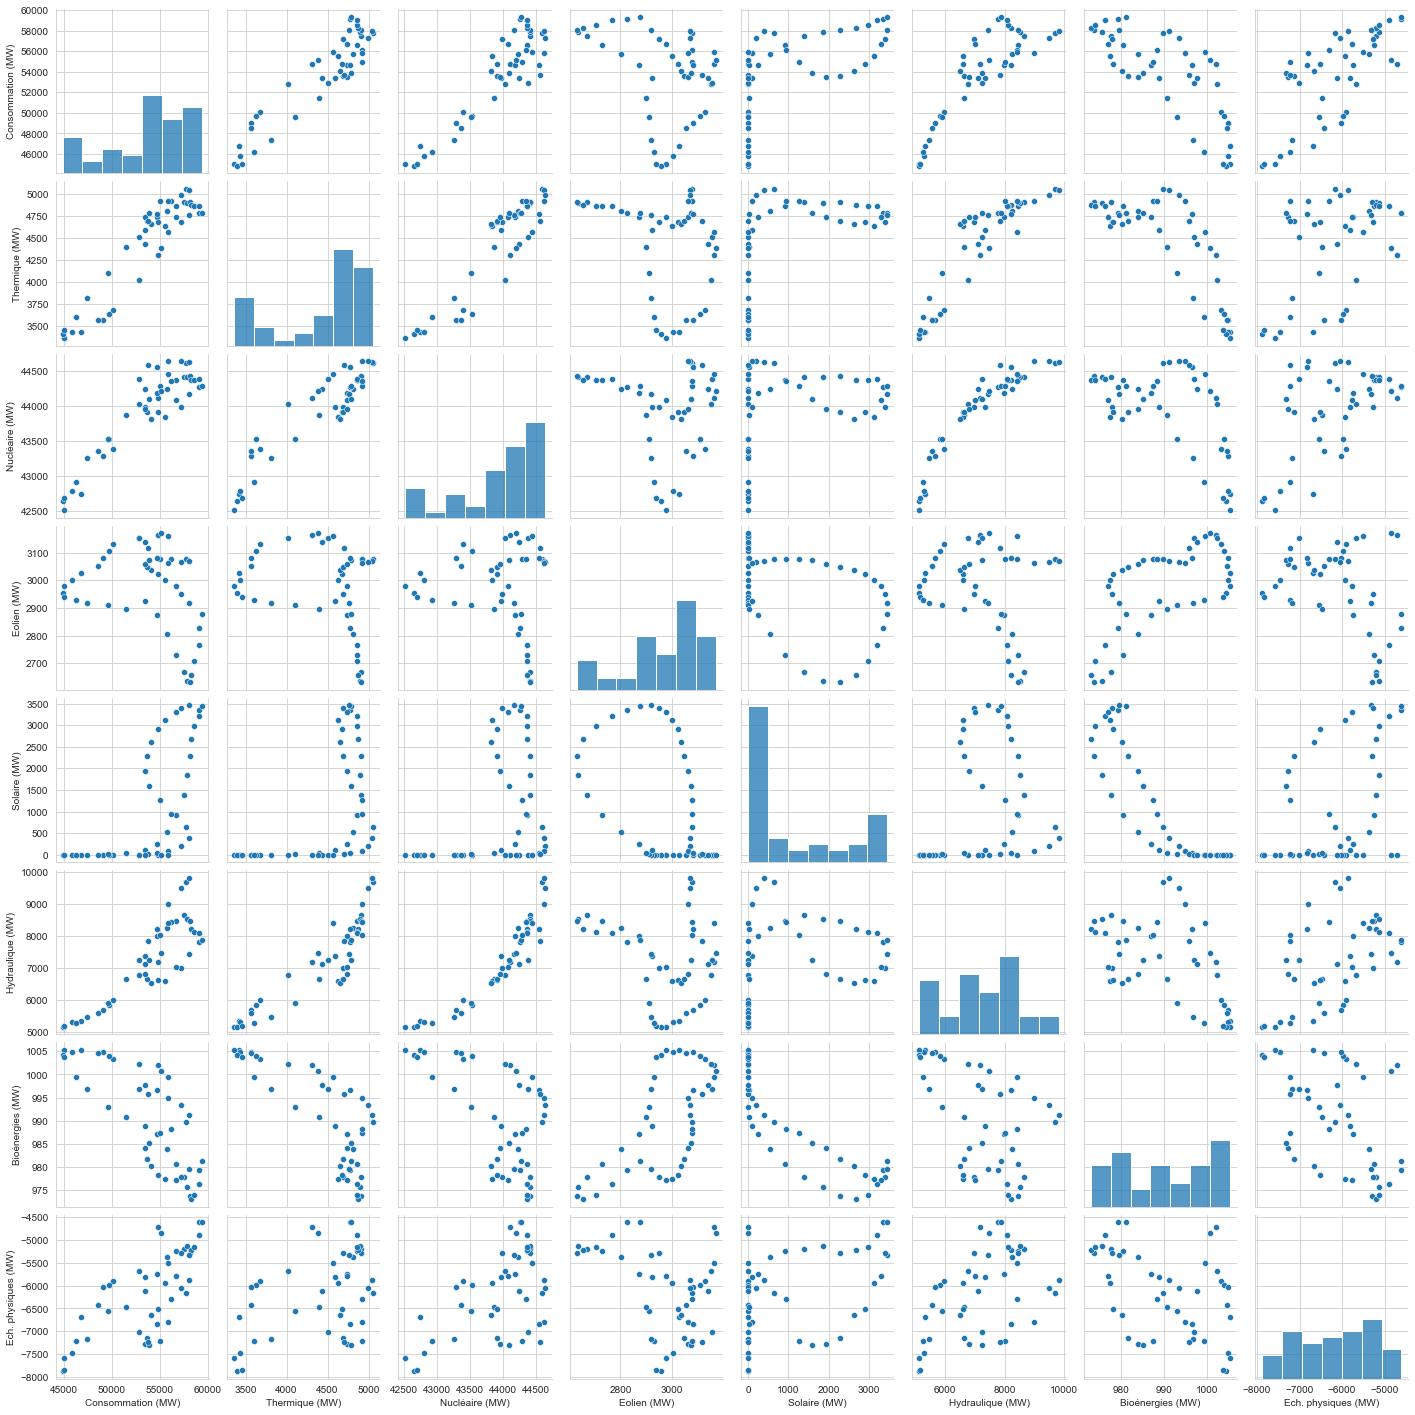

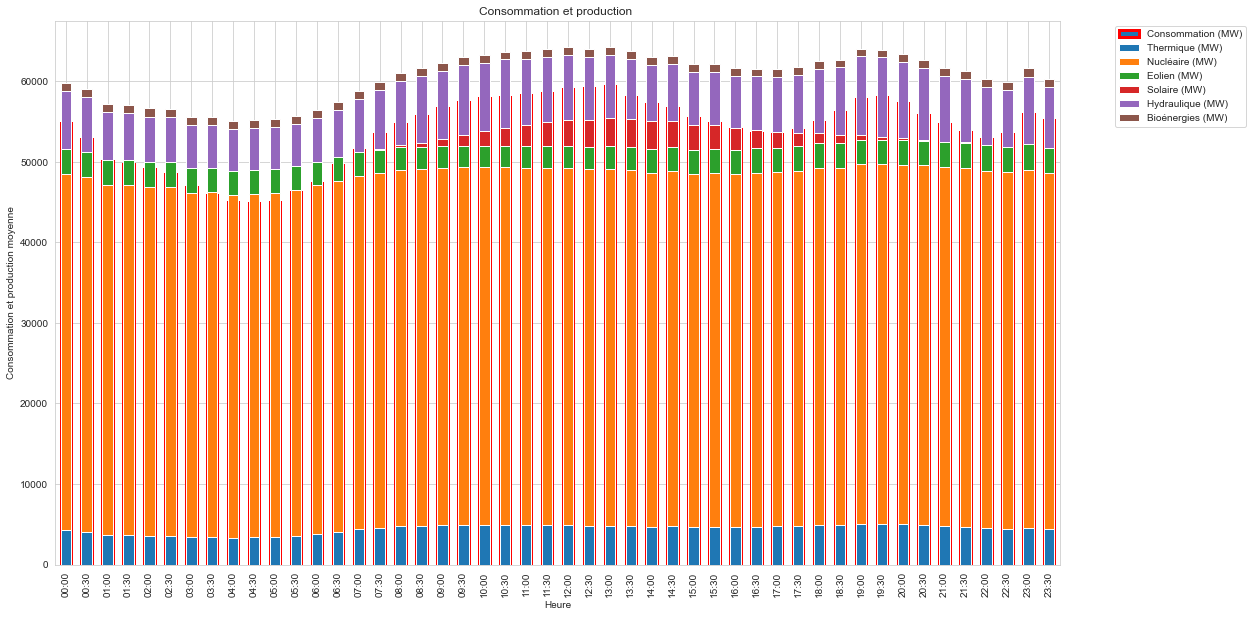

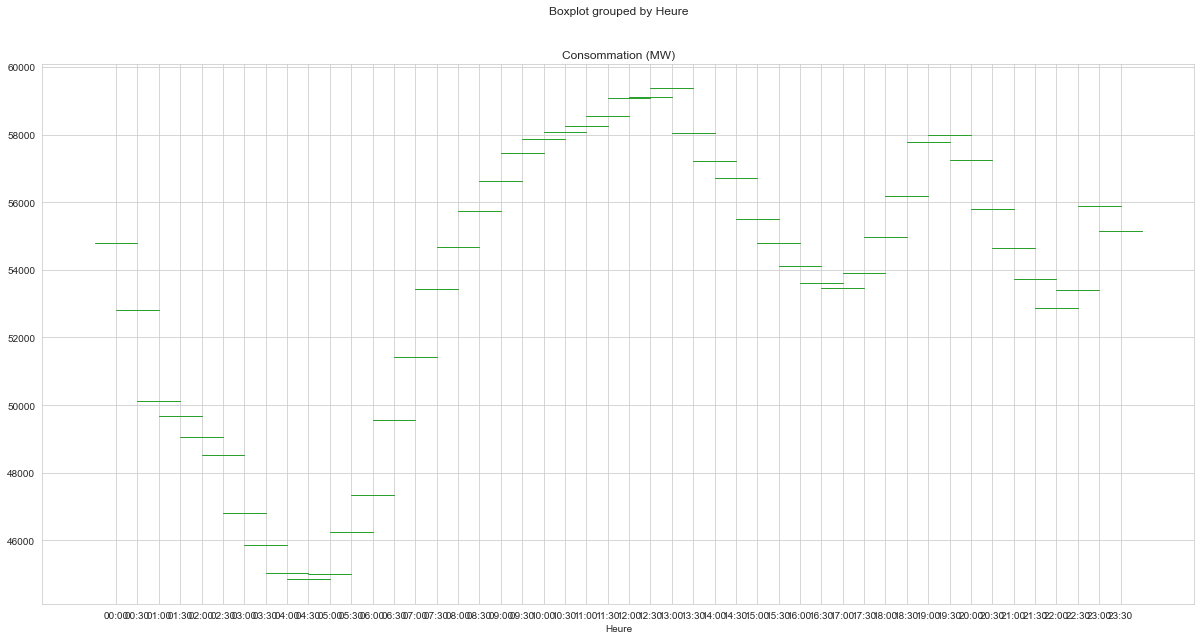



Tableau de corrélation


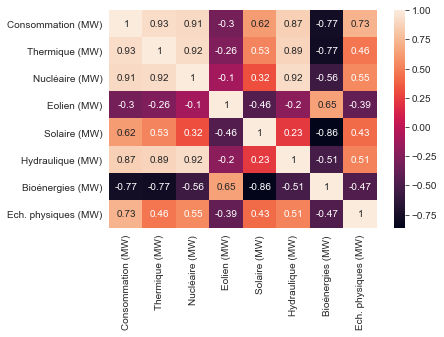

Tableau des p_value
                    Consommation (MW) Thermique (MW) Nucléaire (MW)  \
Consommation (MW)                 0.0            0.0         0.0001   
Thermique (MW)                    0.0            0.0            0.0   
Nucléaire (MW)                 0.0001            0.0            0.0   
Eolien (MW)                    0.0047         0.0144         0.0334   
Solaire (MW)                   0.0046         0.0108         0.0395   
Hydraulique (MW)               0.0002         0.0001            0.0   
Bioénergies (MW)               0.0001         0.0006         0.0049   
Ech. physiques (MW)            0.0018         0.0107         0.0123   

                    Eolien (MW) Solaire (MW) Hydraulique (MW)  \
Consommation (MW)        0.0047       0.0046           0.0002   
Thermique (MW)           0.0144       0.0108           0.0001   
Nucléaire (MW)           0.0334       0.0395              0.0   
Eolien (MW)                 0.0       0.0022            0.032   
Solaire (MW)   

In [167]:
print('Par heure') 
corr_consommation('Heure')

<p>Les graphiques par paire de la consommation nous montrent une corrélation avec les productions thermique, nucléaire, hydraulique et une corrélation inversée avec la bioénergie. Les points peuvent être représentés sous forme de régression linéaire.
<p>La consommation électrique varie entre 45 et 60 GW tout au long de la journée.
<p>La production varie entre 5 et 10 GW de plus que la consommation :
- lorsque la consommation est la plus élevée l'écart est le plus faible entre la production et la consommation.
- lorsque la consommation est la plus faible l'écart est le plus fort entre la production et la consommation.

<p>Tableau des corrélations :
<p>Il y a une forte corrélation entre la consommation et les productions thermique, nucléaire, solaire et hydraulique.
<p>Il y a une forte corrélation inversée entre la consommation et la production bioénergie.

<p>Tableau des p_value :
<p>Les p_value entre la consommation et les poductions sont toutes inférieures à 5%.

Par semaine
Graphique par paires


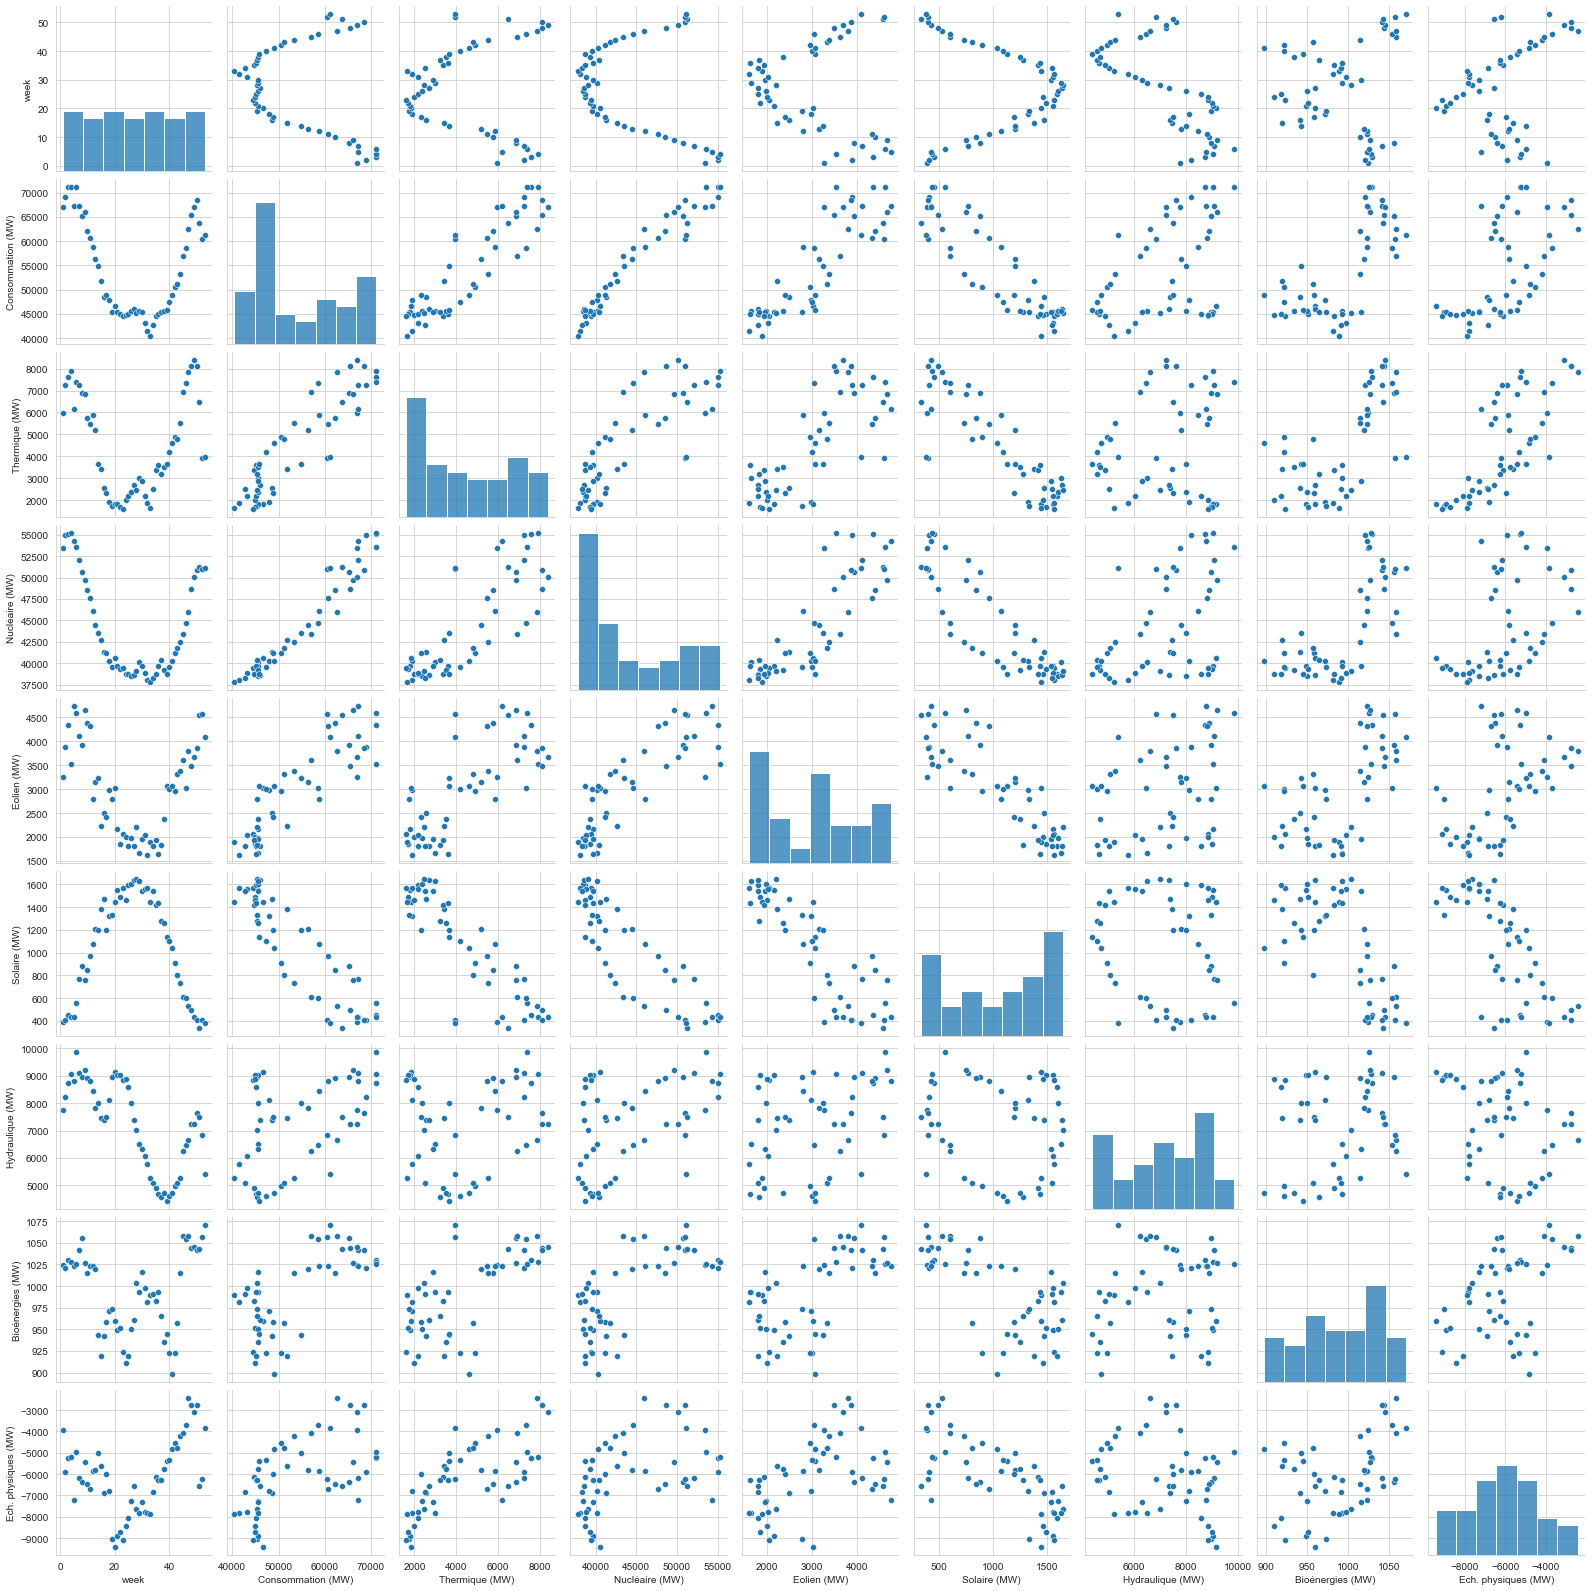

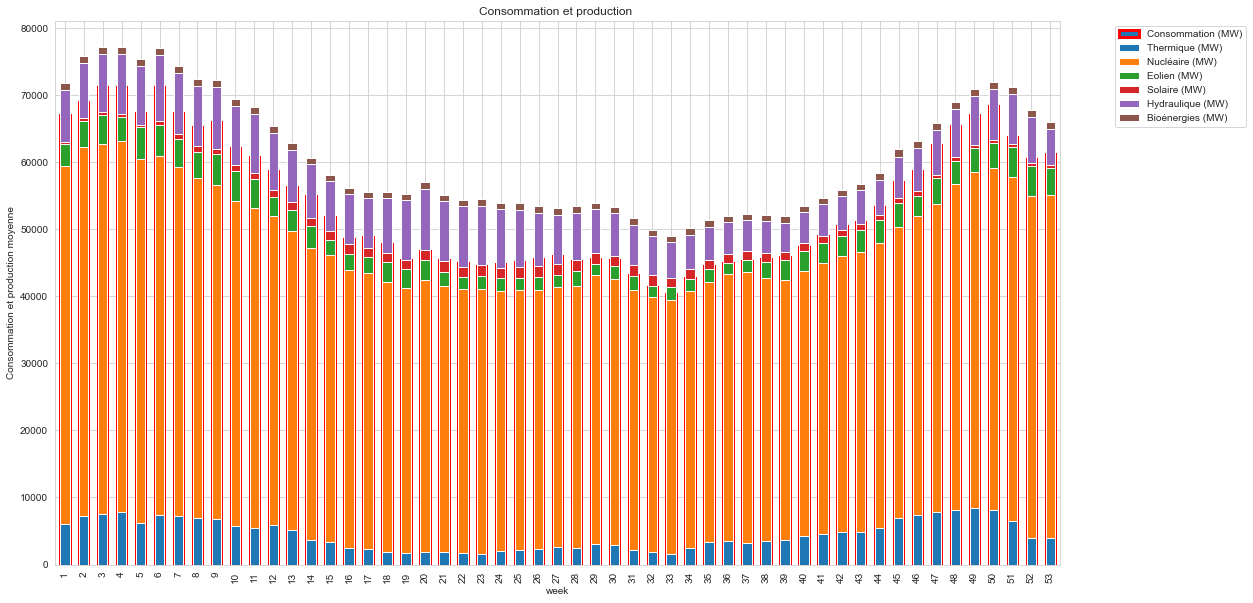

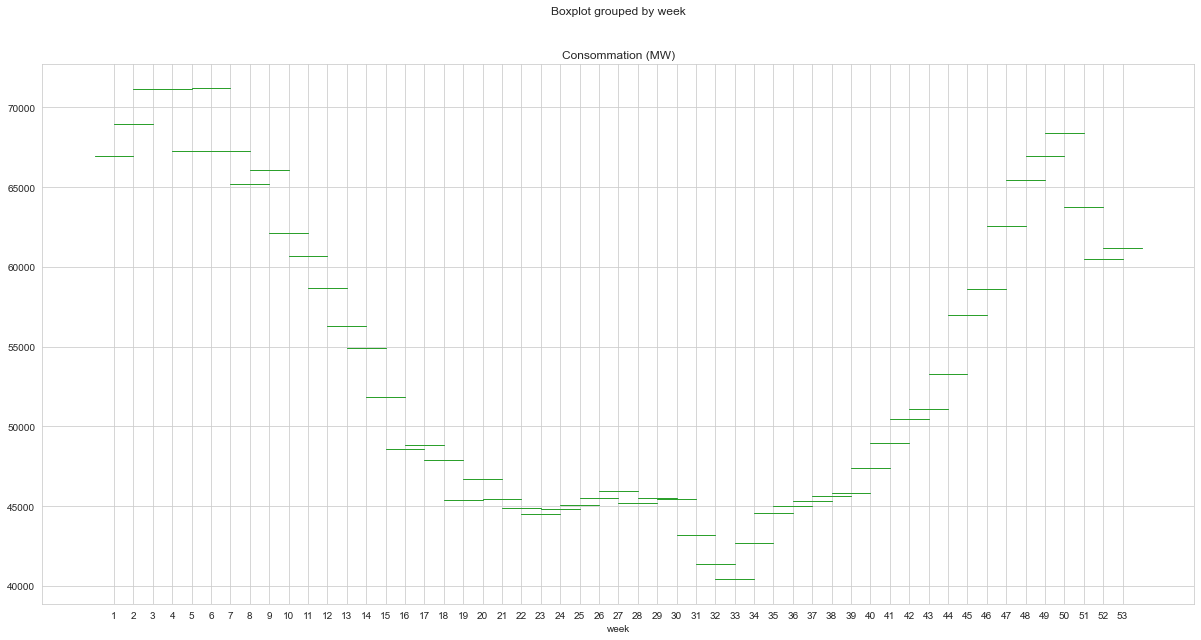



Tableau de corrélation


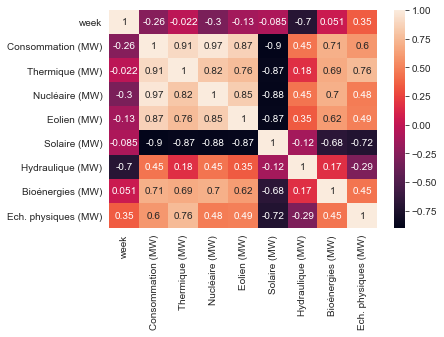

Tableau des p_value
                       week Consommation (MW) Thermique (MW) Nucléaire (MW)  \
week                    0.0            0.3412          0.715         0.2816   
Consommation (MW)    0.3412               0.0            0.0            0.0   
Thermique (MW)        0.715               0.0            0.0         0.0001   
Nucléaire (MW)       0.2816               0.0         0.0001            0.0   
Eolien (MW)          0.4313               0.0            0.0            0.0   
Solaire (MW)          0.822               0.0            0.0         0.0001   
Hydraulique (MW)     0.0001            0.1543         0.4307         0.1181   
Bioénergies (MW)     0.7321            0.0003         0.0002         0.0004   
Ech. physiques (MW)  0.4031            0.0243         0.0021         0.0393   

                    Eolien (MW) Solaire (MW) Hydraulique (MW)  \
week                     0.4313        0.822           0.0001   
Consommation (MW)           0.0          0.0           0.15

In [168]:
print('Par semaine') 
corr_consommation('week')

<p>Les graphiques par pair de la semaine nous montrent la saisonnalité car la consommation et les productions thermique, nucléaire et éolienne forment un V et un V inversé pour la production éolinne (corrélation inversée).
<p>Les graphiques par paire montrent une corrélation avec les productions thermique, nucléaire, hydraulique et une corrélation inversée avec les bioénergies. Les points peuvent être représentés sous forme de régression linéaire.

<p>Graphique plot bar :
<p>La consommation électrique varie entre 40 et 65 GW tout au long de la journée.
<p>Comme l'avons relevé précédemment, la consommation est plus faible en été qu'en hiver.

<p>Tableau des corrélations :
<p>Il y a une forte corrélation entre la consommation et les productions thermique, nucléaire et hydraulique.
<p>Il y a une forte corrélation inversée entre la consommation et la production solaire.

<p>Tableau des p_value :
<p>Les p_value entre la consommation et les poductions sont toutes inférieures à 5% sauf pour la production hydraulique.

Par mois
Graphique par paires


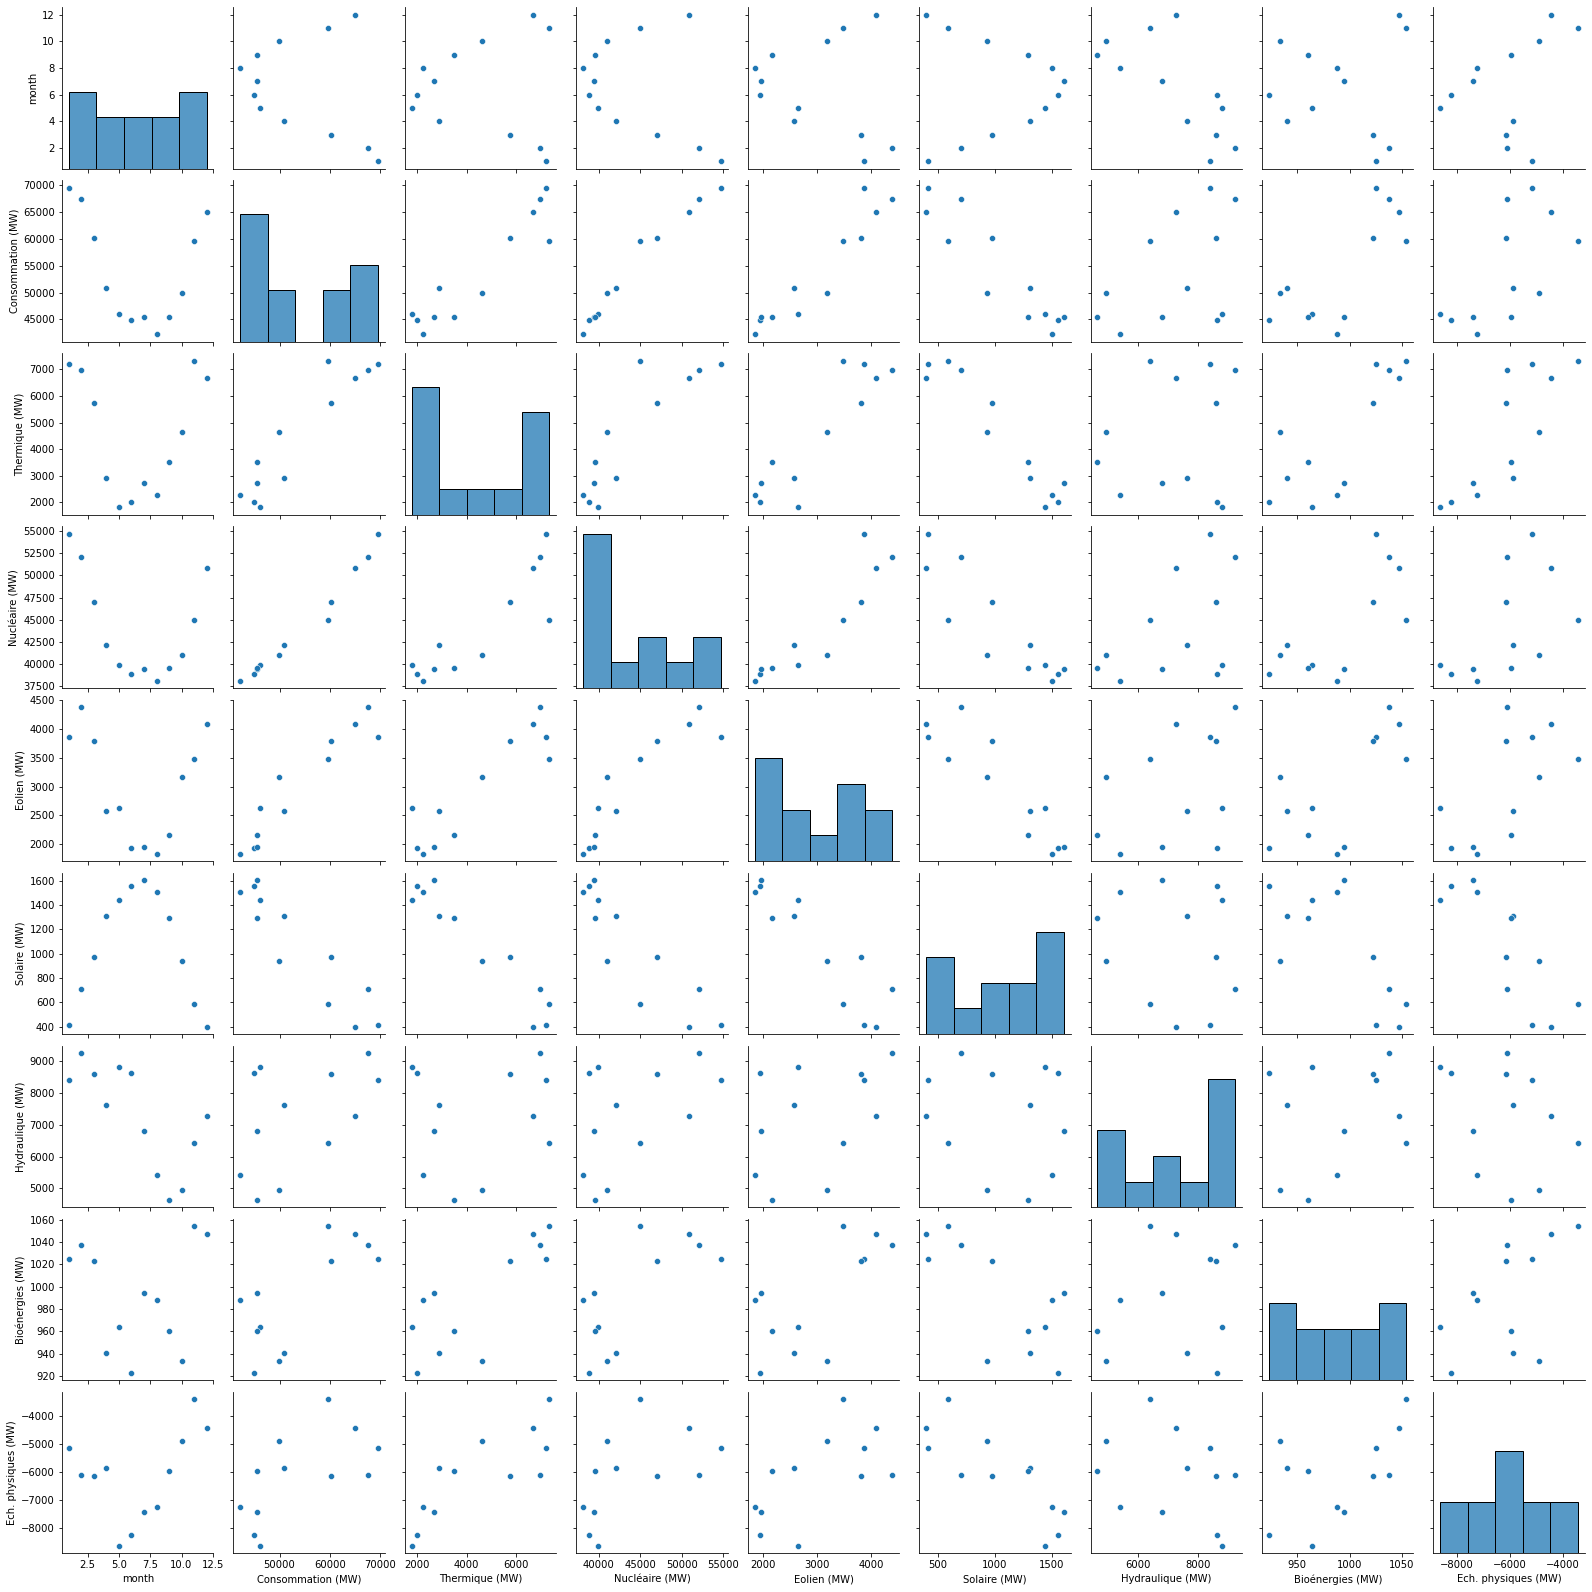

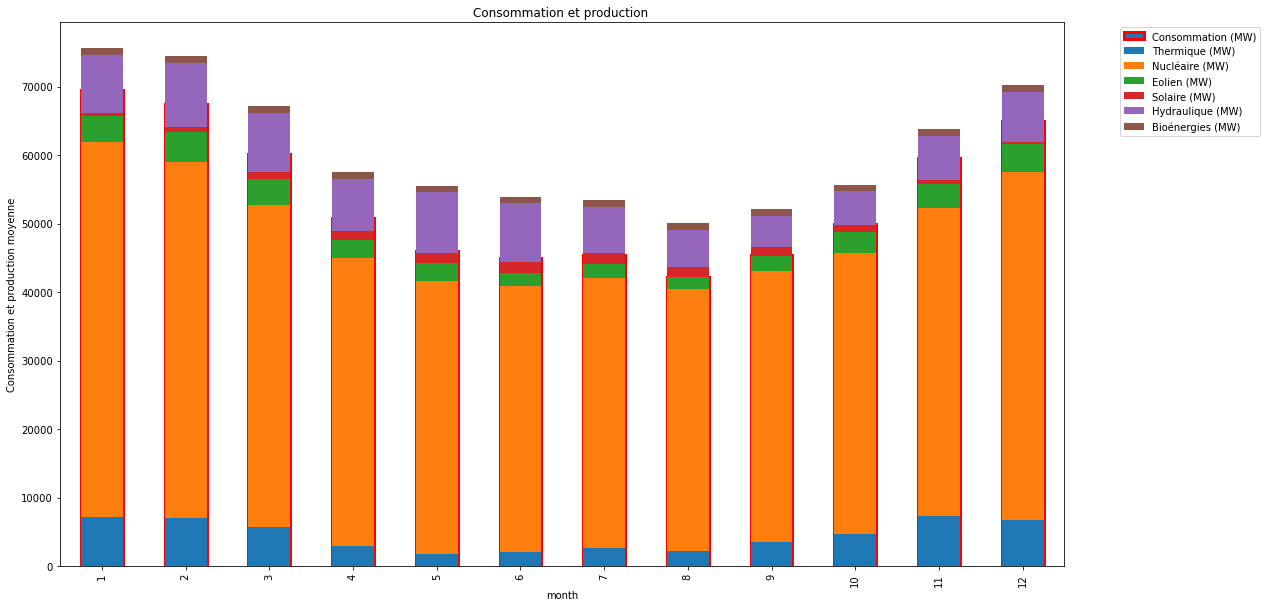

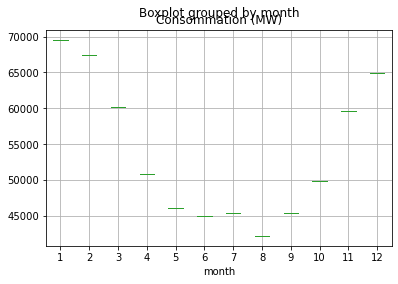



Tableau de corrélation


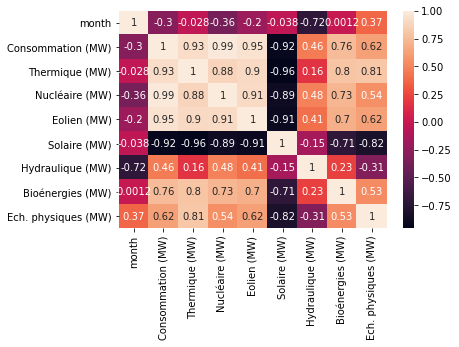

Tableau des p_value
                      month Consommation (MW) Thermique (MW) Nucléaire (MW)  \
month                   0.0             0.263         0.6343         0.2066   
Consommation (MW)     0.263               0.0            0.0            0.0   
Thermique (MW)       0.6343               0.0            0.0         0.0001   
Nucléaire (MW)       0.2066               0.0         0.0001            0.0   
Eolien (MW)          0.3252               0.0            0.0            0.0   
Solaire (MW)         0.6888               0.0            0.0         0.0001   
Hydraulique (MW)        0.0            0.1284         0.3985         0.0959   
Bioénergies (MW)     0.5614            0.0001            0.0         0.0002   
Ech. physiques (MW)  0.5103            0.0179         0.0011          0.028   

                    Eolien (MW) Solaire (MW) Hydraulique (MW)  \
month                    0.3252       0.6888              0.0   
Consommation (MW)           0.0          0.0           0.12

In [101]:
print('Par mois') 
corr_consommation('month')
print('\n')

Les résultats par mois sont similaires avec ceux de la semaine mais les valeurs plus élevées.

Par trimestre
Graphique par paires


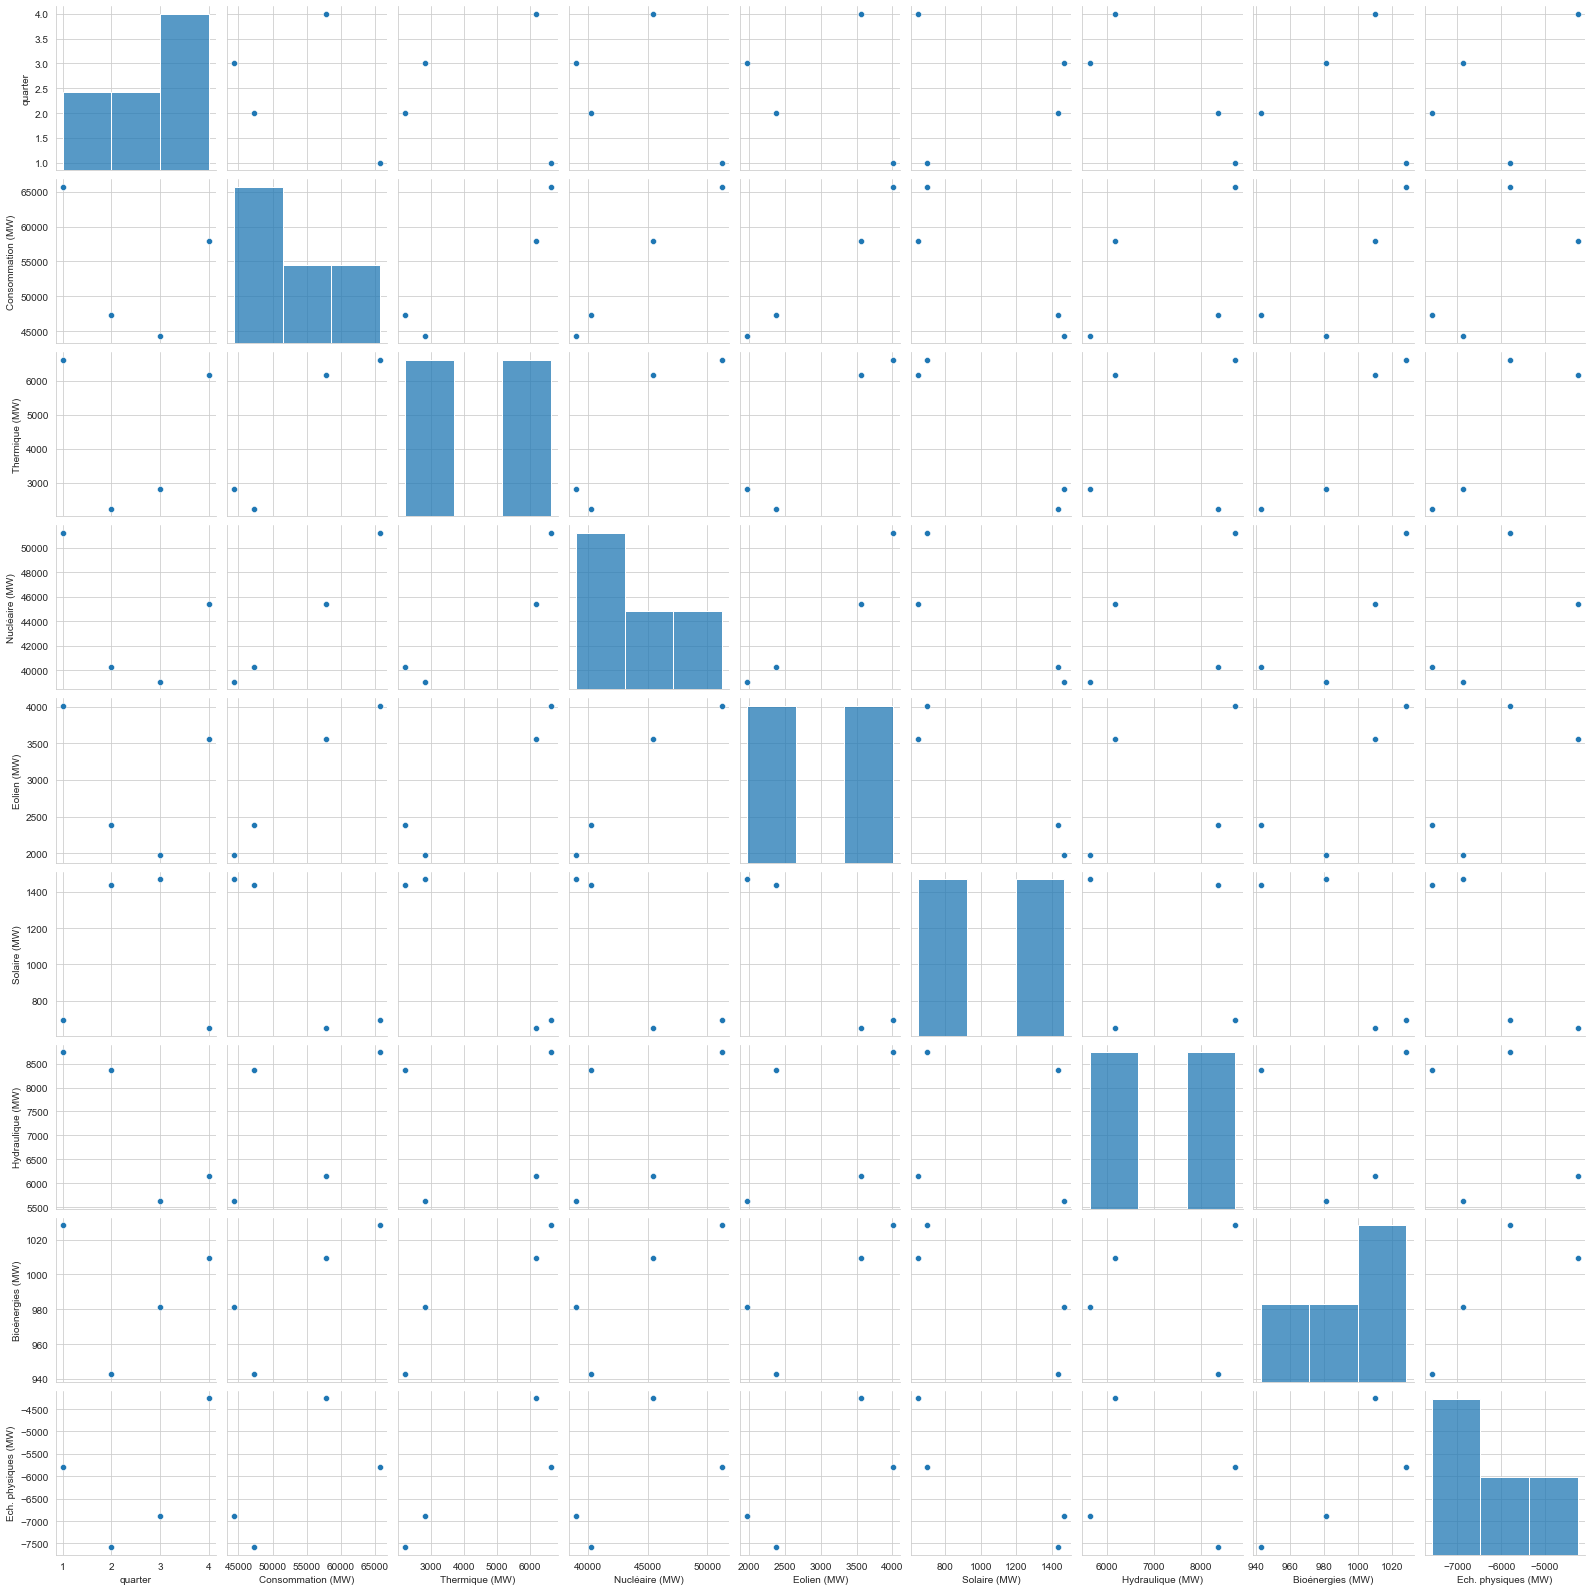

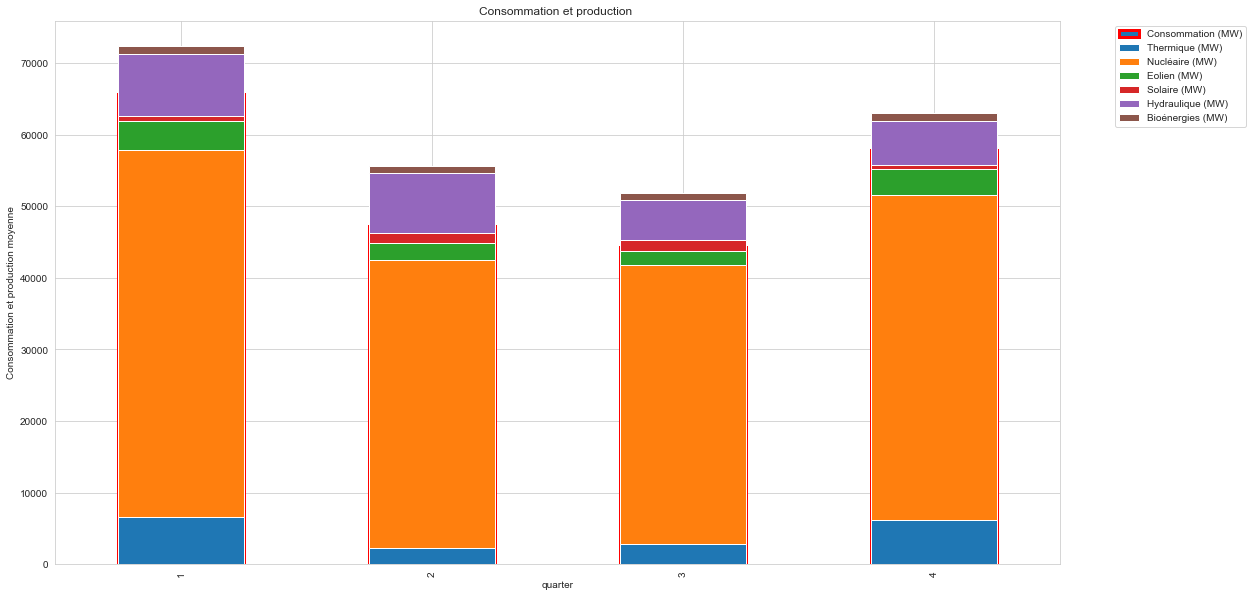

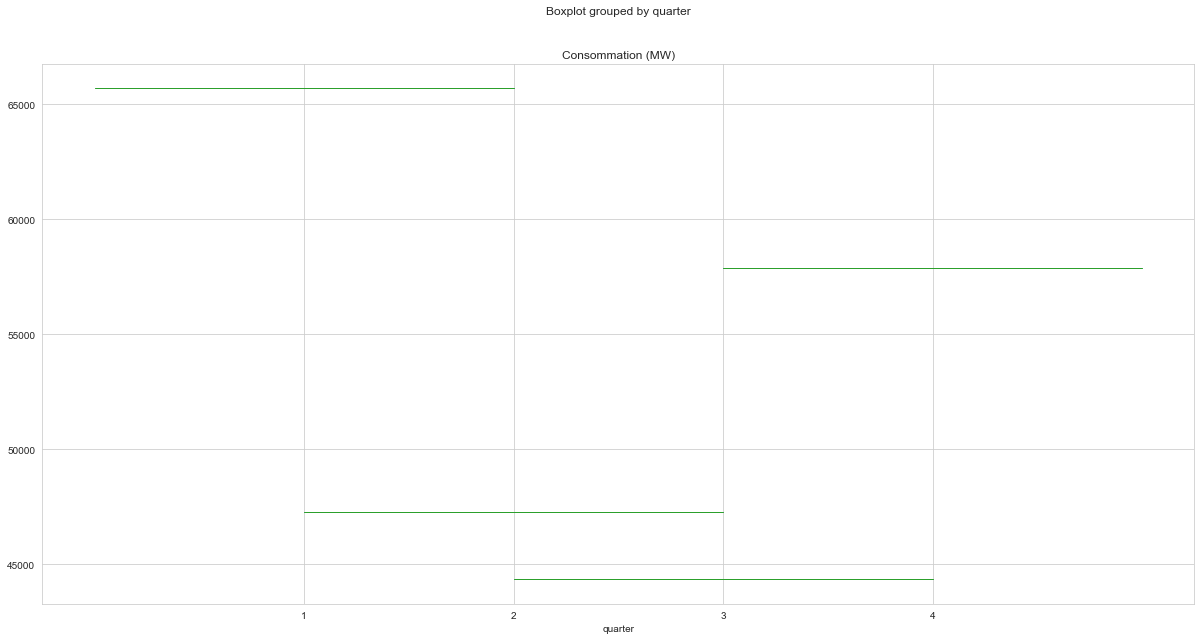



Tableau de corrélation


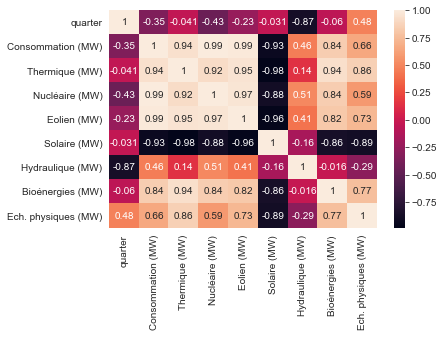

Tableau des p_value
                    quarter Consommation (MW) Thermique (MW) Nucléaire (MW)  \
quarter                 0.0             0.268         0.6701         0.2025   
Consommation (MW)     0.268               0.0            0.0            0.0   
Thermique (MW)       0.6701               0.0            0.0         0.0001   
Nucléaire (MW)       0.2025               0.0         0.0001            0.0   
Eolien (MW)          0.3609               0.0            0.0            0.0   
Solaire (MW)         0.7266               0.0            0.0         0.0002   
Hydraulique (MW)        0.0            0.1376          0.438         0.1003   
Bioénergies (MW)     0.7473            0.0001            0.0         0.0003   
Ech. physiques (MW)  0.4762             0.017         0.0009         0.0284   

                    Eolien (MW) Solaire (MW) Hydraulique (MW)  \
quarter                  0.3609       0.7266              0.0   
Consommation (MW)           0.0          0.0           0.13

In [169]:
print('Par trimestre') 
corr_consommation('quarter')

À nouveau, nous obtenons des résultats similaires à ceux de la semaine et du mois avec des valeurs plus élevées.

Par année
Graphique par paires


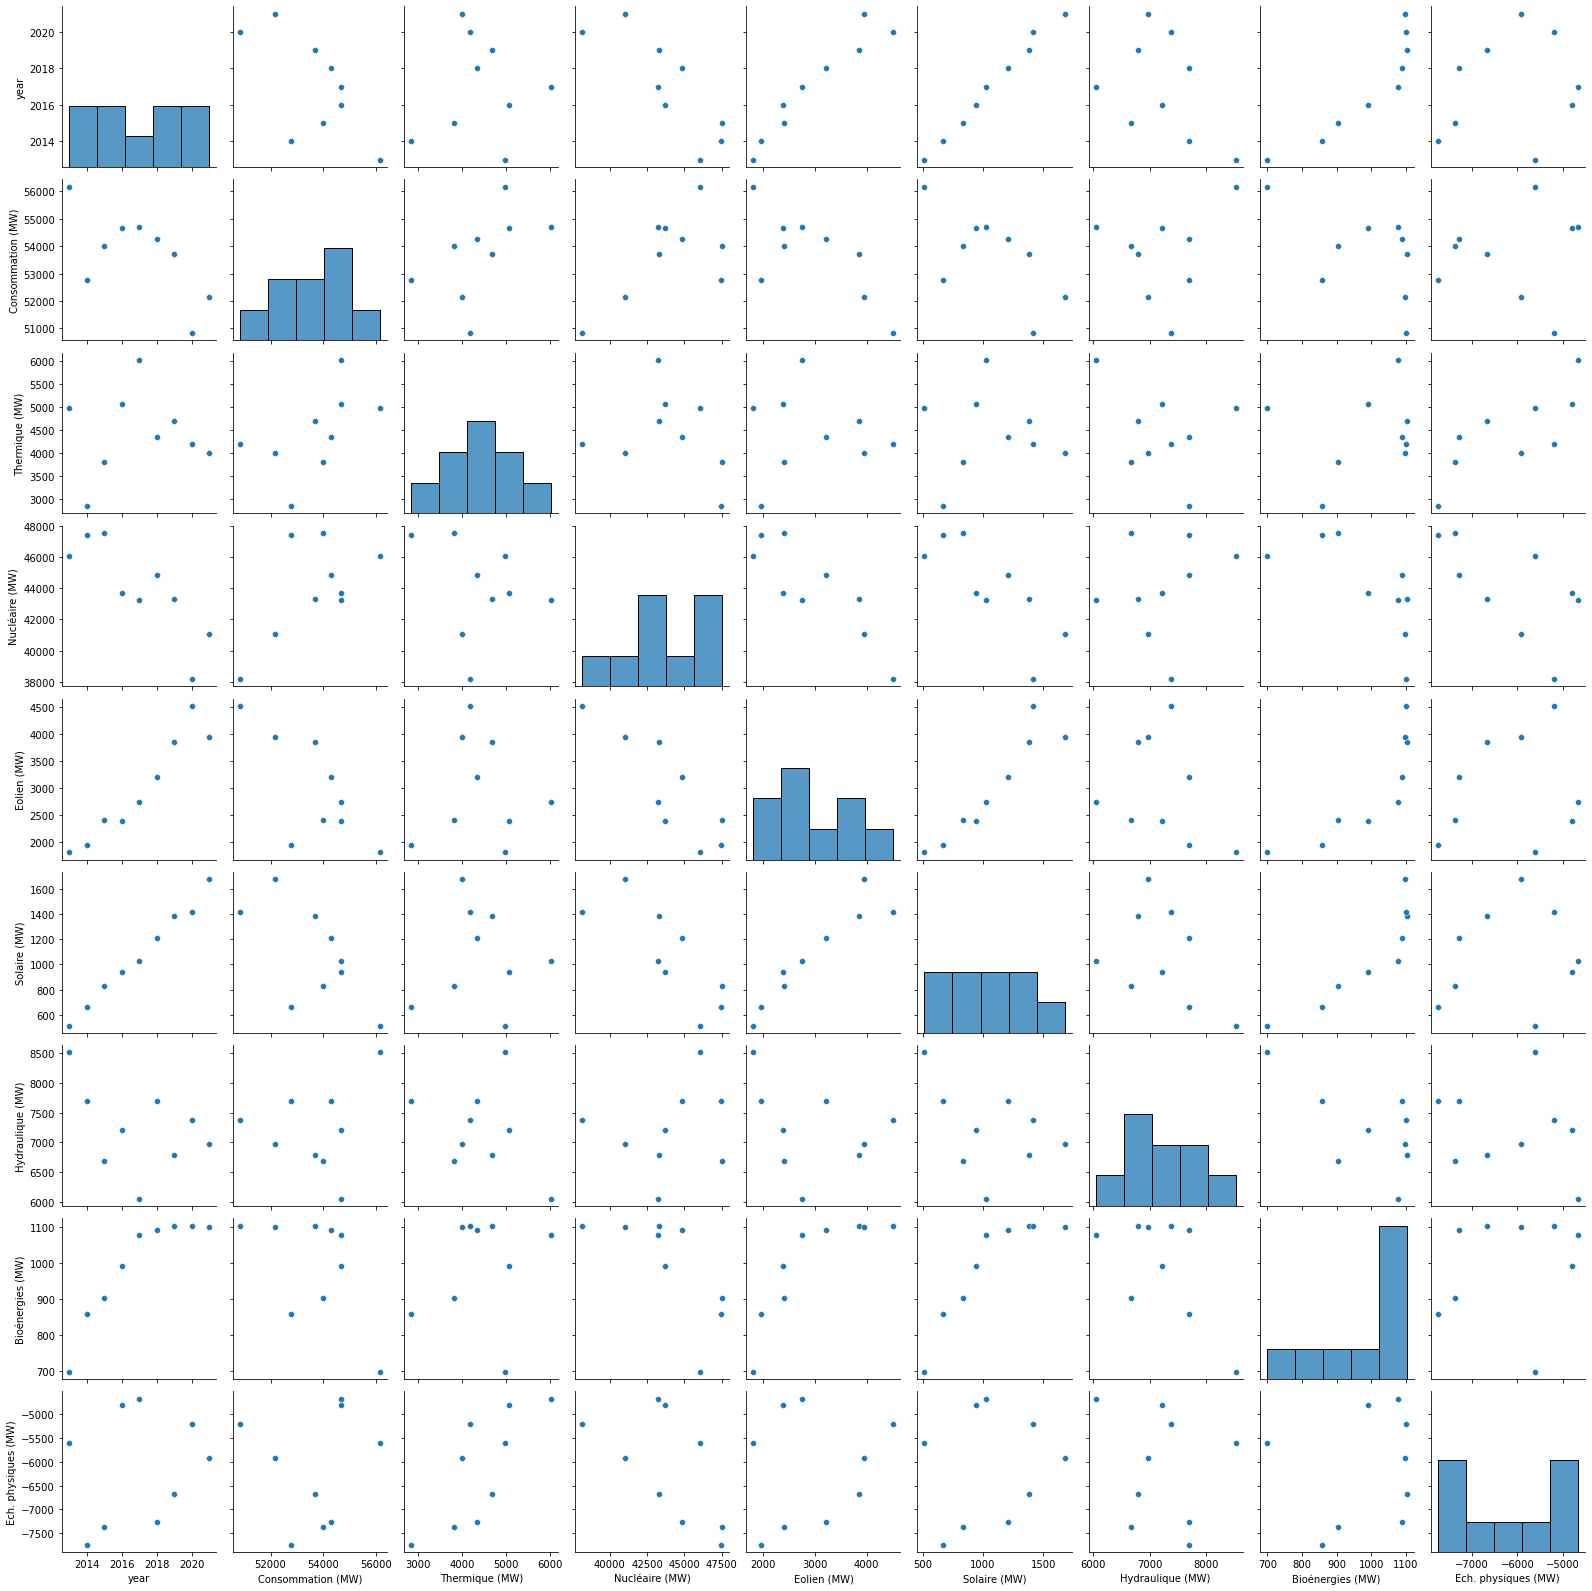

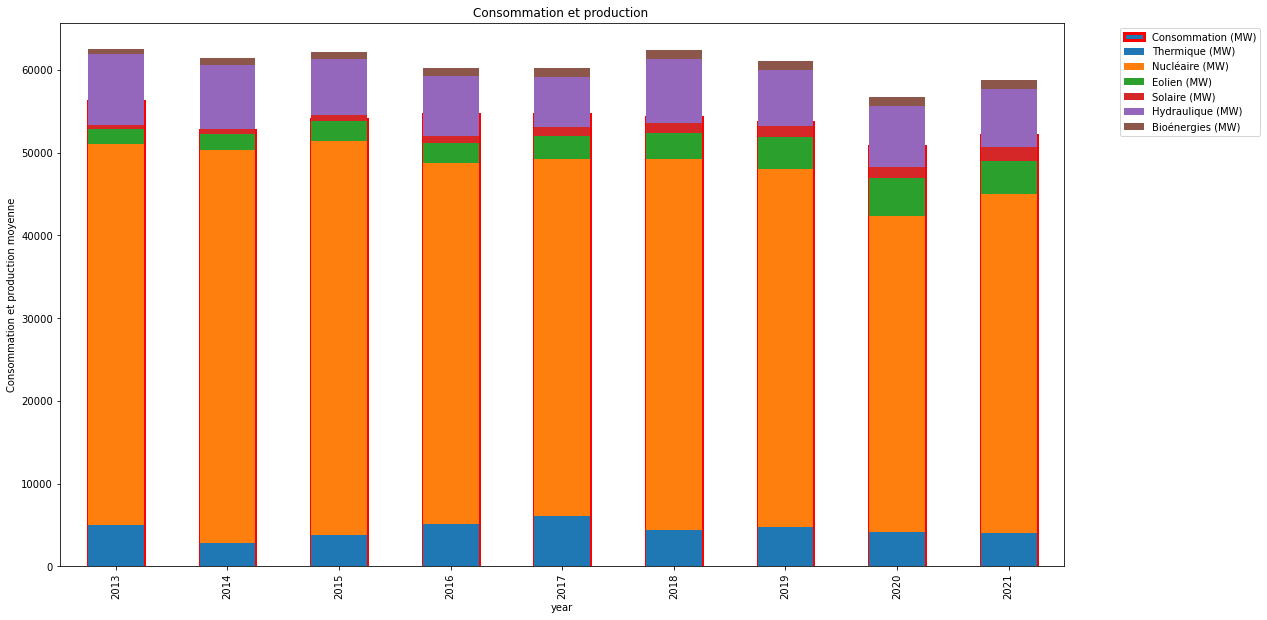



Tableau de corrélation


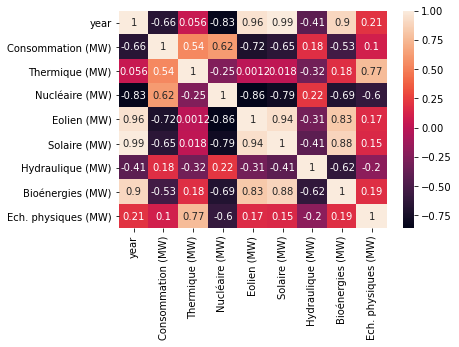

Tableau des p_value
                       year Consommation (MW) Thermique (MW) Nucléaire (MW)  \
year                    0.0            0.0002         0.9594         0.0001   
Consommation (MW)    0.0002               0.0          0.356          0.003   
Thermique (MW)       0.9594             0.356            0.0         0.6821   
Nucléaire (MW)       0.0001             0.003         0.6821            0.0   
Eolien (MW)             0.0            0.0001         0.8755            0.0   
Solaire (MW)            0.0            0.0002         0.9067         0.0001   
Hydraulique (MW)     0.0196            0.1332         0.2968          0.039   
Bioénergies (MW)        0.0            0.0017         0.8547         0.0003   
Ech. physiques (MW)   0.341            0.8112         0.0034         0.1027   

                    Eolien (MW) Solaire (MW) Hydraulique (MW)  \
year                        0.0          0.0           0.0196   
Consommation (MW)        0.0001       0.0002           0.13

In [26]:
print('Par année') 
corr_consommation('year')

<p>La puissance électrique consommée ne varie pas beaucoup d'une année sur l'autre.
<p>Les résulats du tableau de corrélation et de p_value sont nettement moins bons : on n'observe pas les variations.

Par jour du mois
Graphique par paires


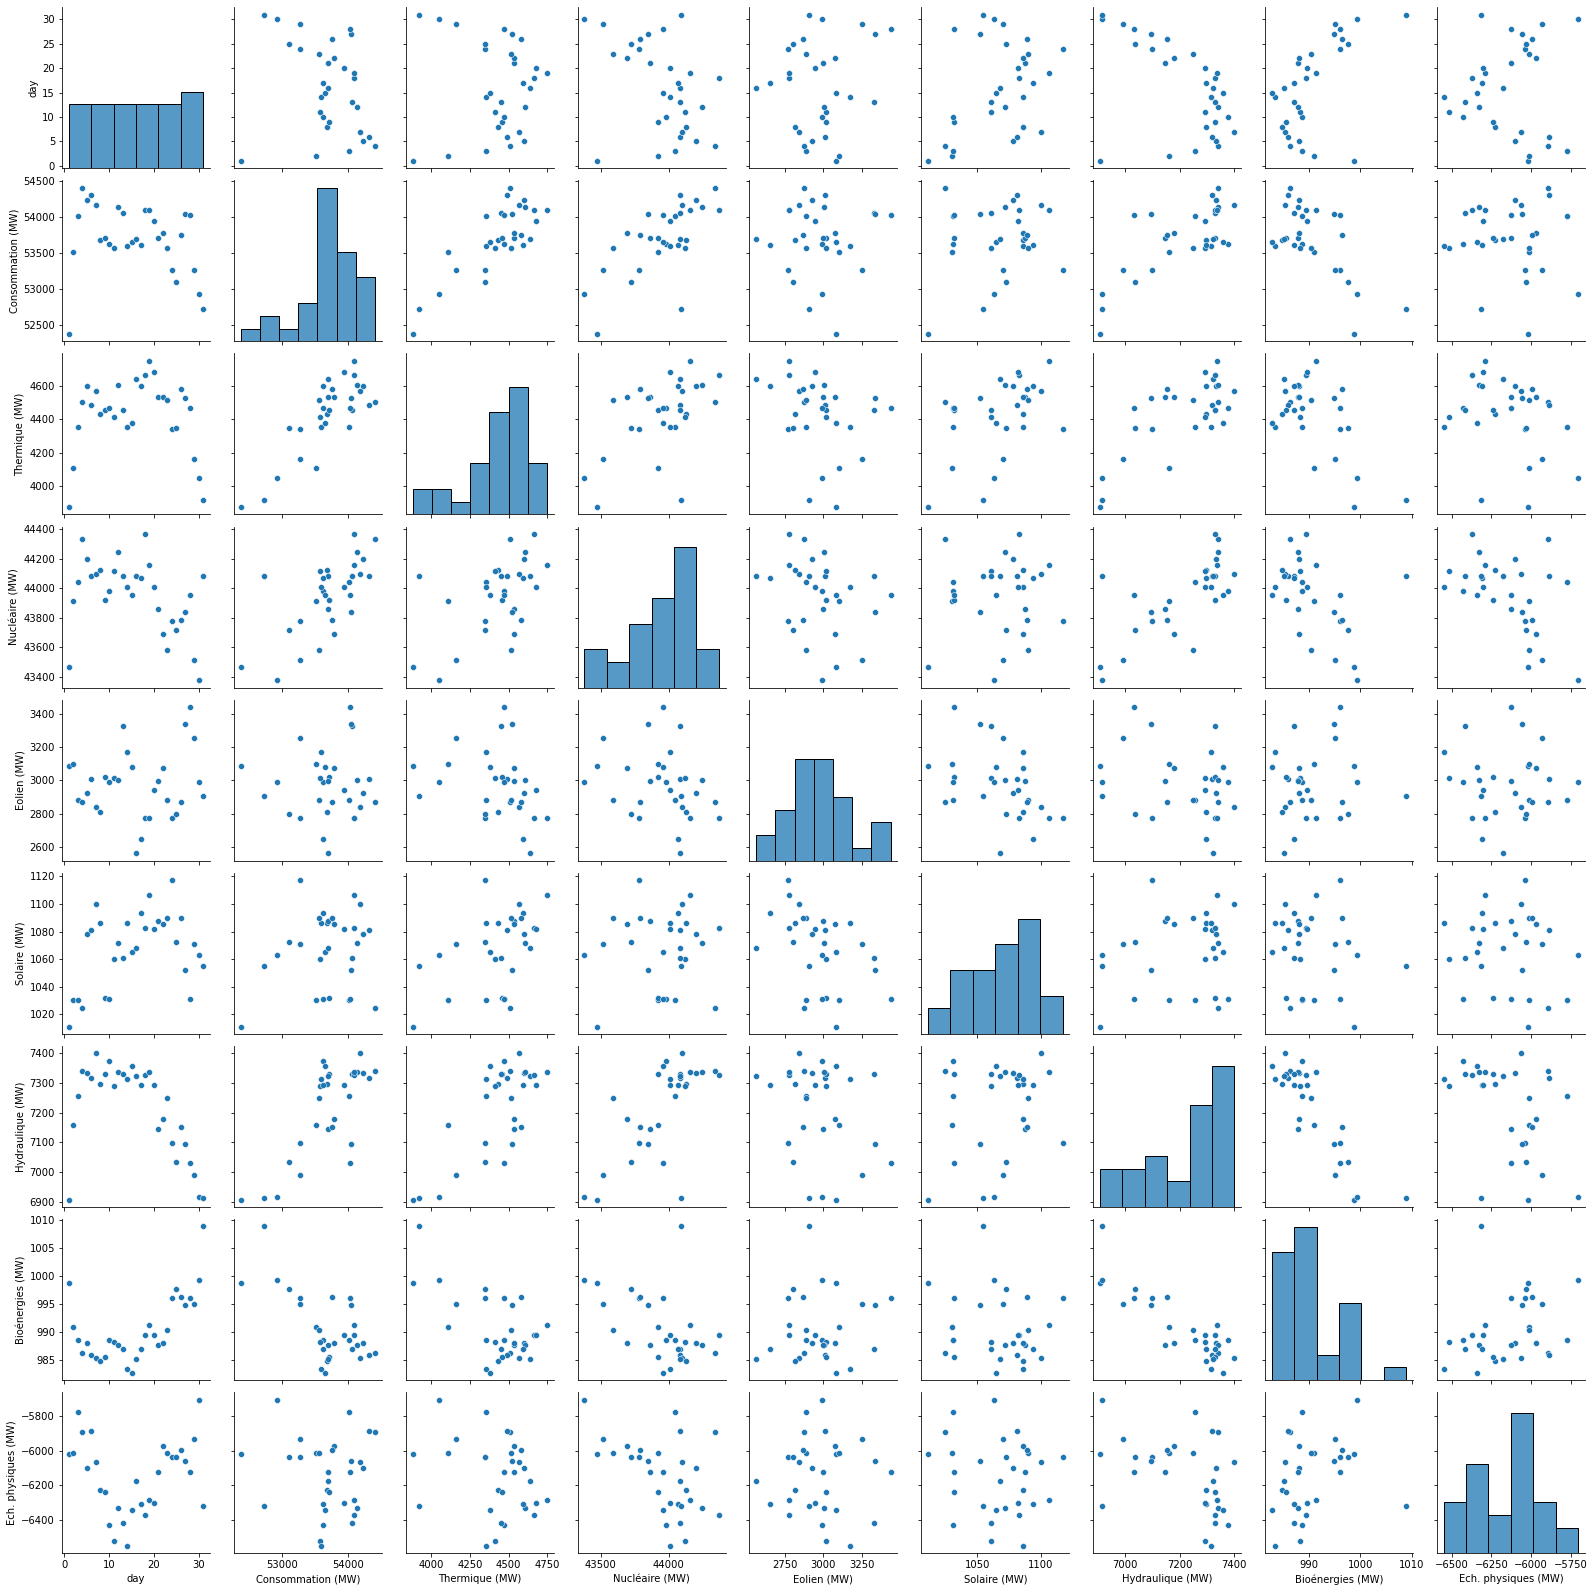

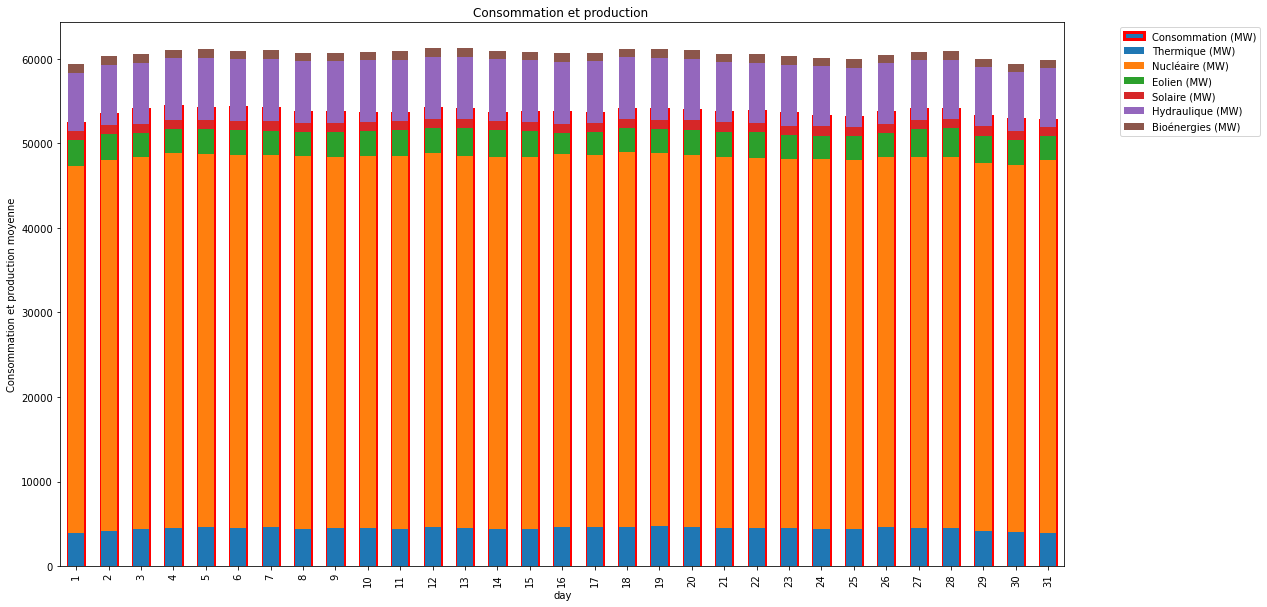



Tableau de corrélation


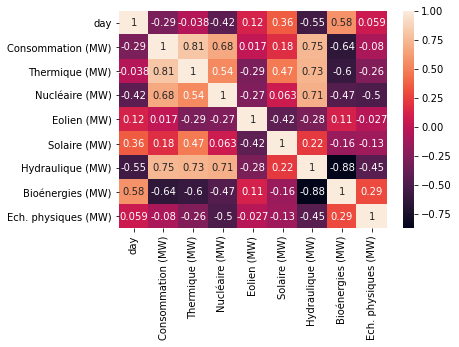

Tableau des p_value
                        day Consommation (MW) Thermique (MW) Nucléaire (MW)  \
day                     0.0            0.0071         0.0806          0.009   
Consommation (MW)    0.0071               0.0         0.0003         0.0006   
Thermique (MW)       0.0806            0.0003            0.0         0.0023   
Nucléaire (MW)        0.009            0.0006         0.0023            0.0   
Eolien (MW)          0.5135            0.2926         0.0845         0.1744   
Solaire (MW)         0.7509            0.4693         0.0977         0.4835   
Hydraulique (MW)     0.0072               0.0         0.0001         0.0001   
Bioénergies (MW)     0.0047               0.0         0.0006         0.0013   
Ech. physiques (MW)  0.2727            0.0805         0.0451         0.0134   

                    Eolien (MW) Solaire (MW) Hydraulique (MW)  \
day                      0.5135       0.7509           0.0072   
Consommation (MW)        0.2926       0.4693              0

In [27]:
print('Par jour du mois') 
corr_consommation('day')

<p>Resultats graphiques :
<p>La puissance électrique consommée ne varie pas beaucoup lorsque l'analyse se fait par jour du mois.

<p>Tableau de corrélation et p_value :
<p>Les résulats du tableau de corrélation et de p_value sont nettement moins bons. Il y a plus de données indépendantes.

Par jour de la semaine
Graphique par paires


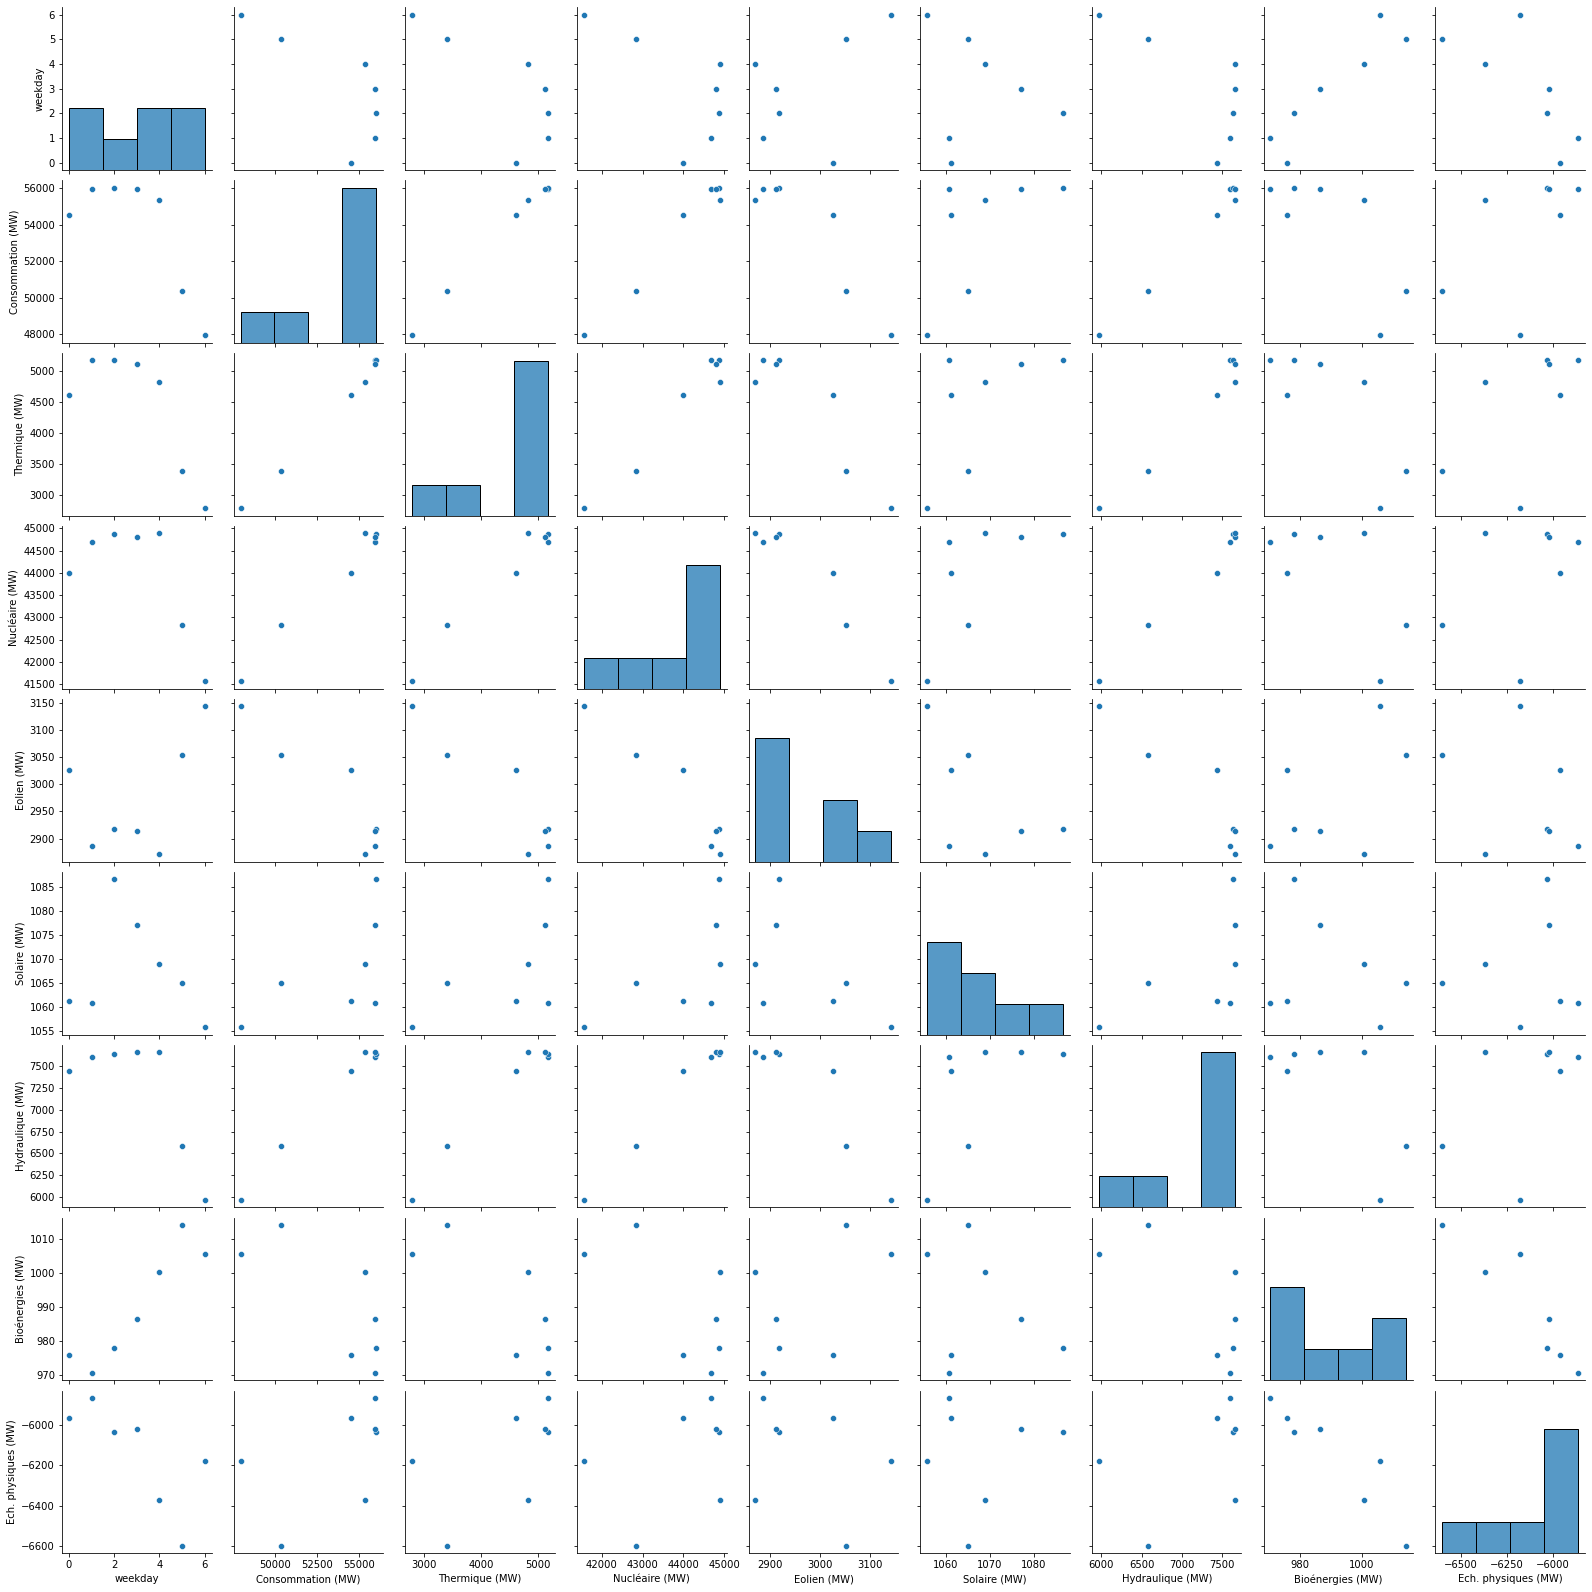

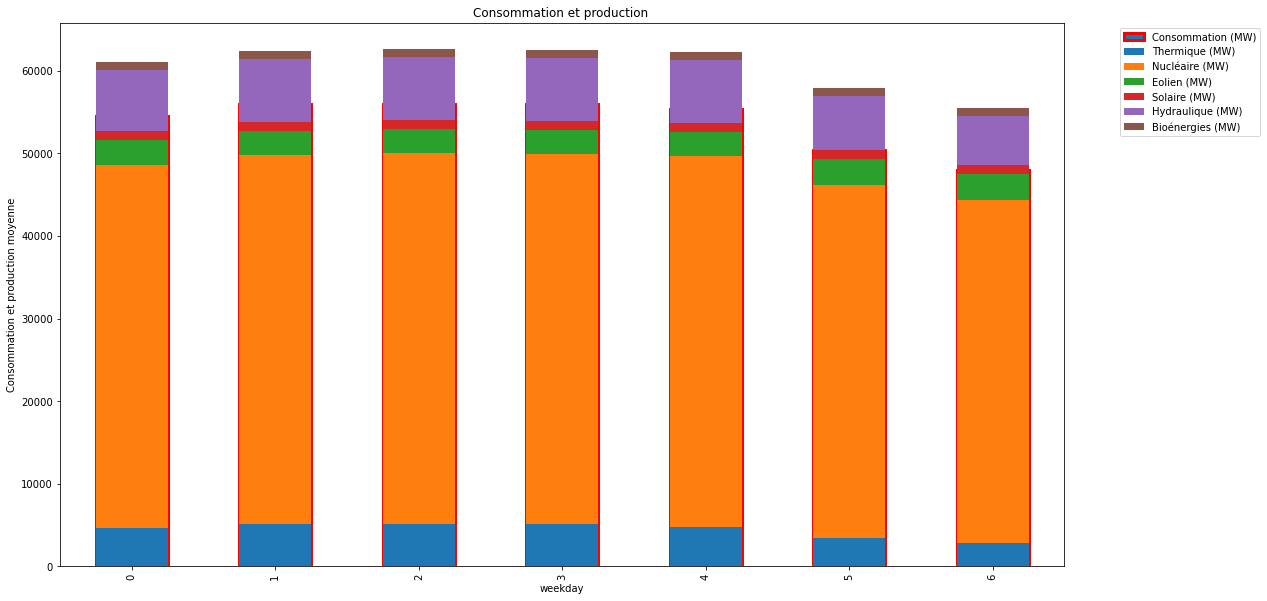



Tableau de corrélation


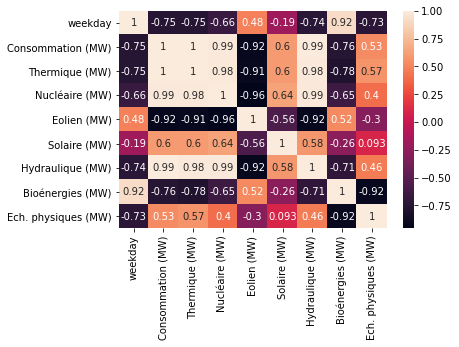

Tableau des p_value
                    weekday Consommation (MW) Thermique (MW) Nucléaire (MW)  \
weekday                 0.0            0.0001         0.0001         0.0004   
Consommation (MW)    0.0001               0.0            0.0            0.0   
Thermique (MW)       0.0001               0.0            0.0            0.0   
Nucléaire (MW)       0.0004               0.0            0.0            0.0   
Eolien (MW)          0.0015               0.0            0.0            0.0   
Solaire (MW)         0.0249            0.0014         0.0015         0.0007   
Hydraulique (MW)     0.0002               0.0            0.0            0.0   
Bioénergies (MW)        0.0            0.0002         0.0001         0.0007   
Ech. physiques (MW)     0.0            0.0037          0.003         0.0087   

                    Eolien (MW) Solaire (MW) Hydraulique (MW)  \
weekday                  0.0015       0.0249           0.0002   
Consommation (MW)           0.0       0.0014              0

In [28]:
print('Par jour de la semaine') 
corr_consommation('weekday')

<p>Resultats graphiques :
<p>La consommation est plus faible le week end.

<p>Tableau de corrélation et p_value :
<p>Les résulats du tableau de corrélation et de p_value montrent une forte corrélation entre la production et la consommation.
<p>Les p_value sont toutes inférieures à 5%. On ne peut donc pas conclure sur l'indépendance entre la consommation et la production.

## 3. Synthèse

<p>Des résultats significatifs de l'influence des conditions météorologiques sont obtenus lorsque les regroupements sont faits :
<p>- avec une saisonnalité d'une année (semaines, mois, trimestres de l'année). Plus la période est grande, moins on peut écarter l'indépendance entre la consommation et les productions ;
<p>- avec une regroupement par jour de la semaine.

<p>Les autres regroupements ne nous permettent pas d'affirmer qu'il y a une dépendance entre la consommation et la production.

# XI- Influence des conditions météo sur la consommation et la production verte

## 1. Définitions

In [291]:
meteo_utile = meteo.iloc[:,1:11]
meteo_utile = meteo_utile.rename(columns={"Date":"Date - Heure"})

In [292]:
meteo_utile.drop(meteo_utile.iloc[:,2:4],1,inplace=True)



In [293]:
def corr_meteo_data (valeur):
    # Groupement
    # Fusion des données
    energie = pd.DataFrame(df2,columns=['Date - Heure', 'Date', 'Heure', 'Région', 'Consommation (MW)', 'Solaire (MW)', 'Eolien (MW)'])
    meteo_data = energie.merge(meteo_utile, on=['Date - Heure'])
    # Suppression des lignes avec NAs
    meteo_utile.dropna()
    # Création des colonnes 
    meteo_data['Date'] = pd.to_datetime(meteo_data['Date'])    
    meteo_data['month'] = meteo_data['Date'].dt.month
    meteo_data['weekday'] = meteo_data['Date'].dt.weekday
    meteo_data['day'] = meteo_data['Date'].dt.day
    meteo_data['quarter'] = meteo_data['Date'].dt.quarter
    meteo_data['year'] = meteo_data['Date'].dt.year
    meteo_data['week'] = meteo_data['Date'].dt.isocalendar().week
    # Regroupement par heure
    meteo_data = meteo_data.groupby([valeur, 'Région']).mean()
    meteo_data1 = meteo_data.groupby([valeur])[['Consommation (MW)', 'Solaire (MW)', 'Eolien (MW)']].sum()
    meteo_data2 = meteo_data.groupby([valeur])[['Direction du vent moyen 10 mn', 'Vitesse du vent moyen 10 mn', 'Température', 'Humidité', 'Visibilité horizontale']].mean()                             
    meteo_data = meteo_data1.merge(meteo_data2, on=[valeur])  
    meteo_data = meteo_data.reset_index()
    print('Graphique')
    sns.pairplot(meteo_data)
    fig, ax = plt.subplots(figsize=(18, 10))
    ax = meteo_data.plot(valeur, ['Consommation (MW)', 'Solaire (MW)', 'Eolien (MW)', 'Visibilité horizontale'], ax = ax) 
    ax2 = meteo_data.plot(valeur, ['Direction du vent moyen 10 mn', 'Vitesse du vent moyen 10 mn', 'Température', 'Humidité'], secondary_y=True, ax=ax)
    ax.set_ylabel('Consommation, Solaire, Eolien,Visibilité horizontale')
    ax2.set_ylabel('Direction du vent et vitesse du vent, Température Humidité')
    plt.title("Consommation, production vert et condition météo")
    plt.xlabel(valeur)
    plt.show()
# Corrélation
    print('Tableau de corrélation')
    corr_data = meteo_data.corr(method='pearson')
    tableau(corr_data)
# p_value
    print('Tableau de p_value')
    print(calculate_pvalues(corr_data))

## 2. Analyses

Influence des conditons météo sur la consommation et la production verte par semaine
Graphique


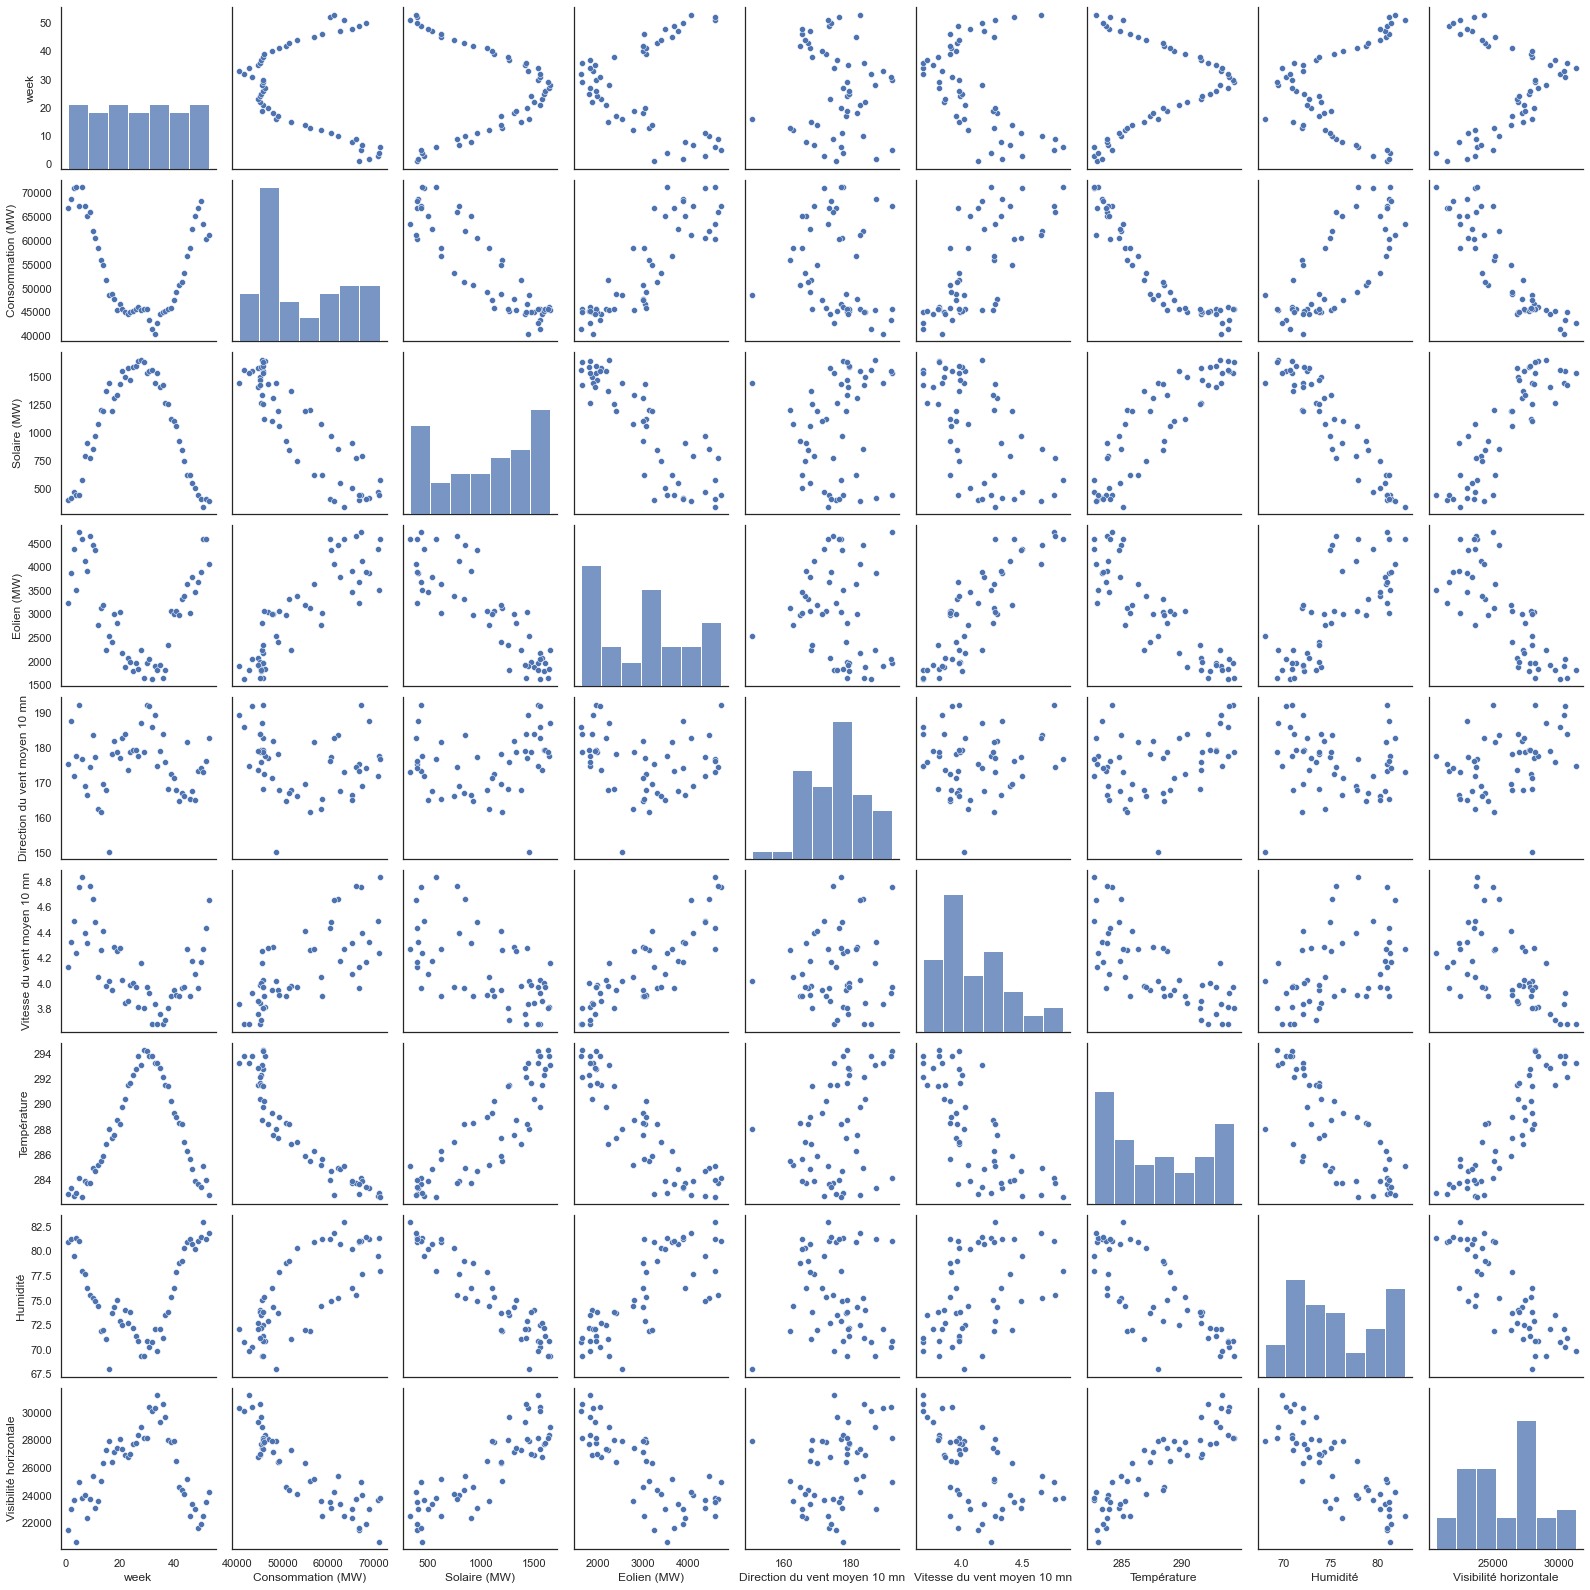

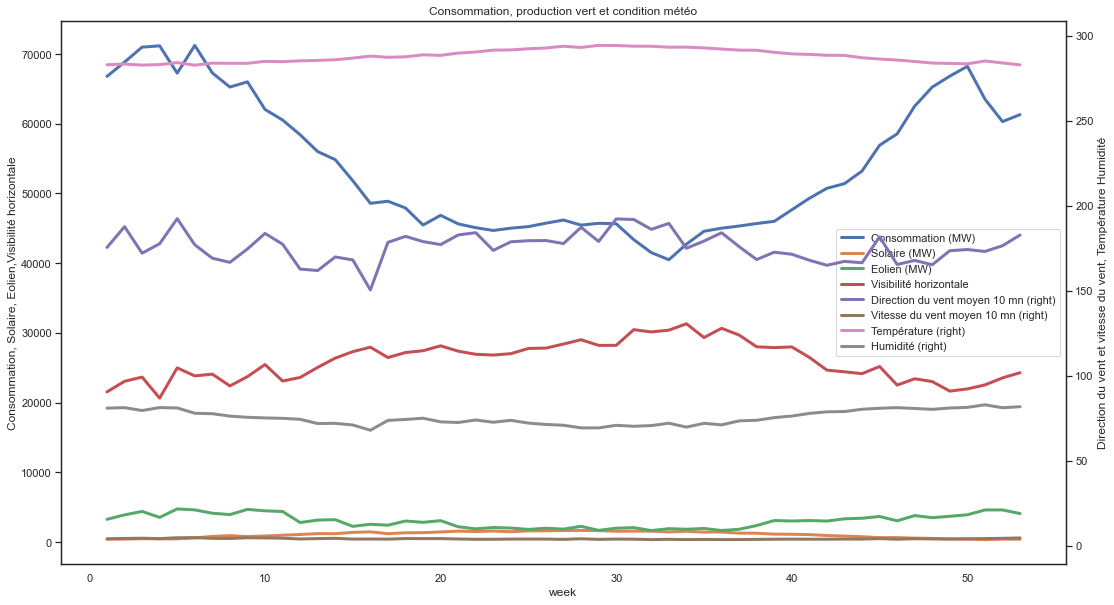

Tableau de corrélation


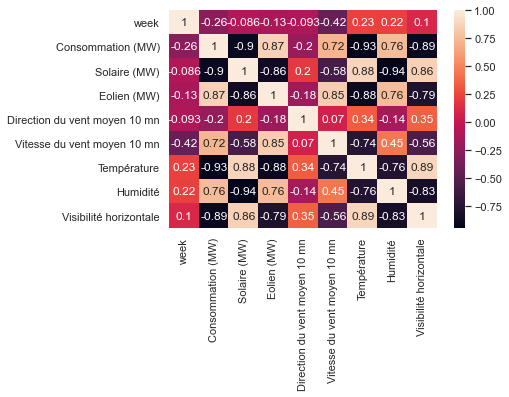

Tableau de p_value
                                 week Consommation (MW) Solaire (MW)  \
week                              0.0             0.336       0.6248   
Consommation (MW)               0.336               0.0          0.0   
Solaire (MW)                   0.6248               0.0          0.0   
Eolien (MW)                    0.3685               0.0          0.0   
Direction du vent moyen 10 mn   0.743            0.1155         0.09   
Vitesse du vent moyen 10 mn    0.1126            0.0001        0.001   
Température                    0.3609               0.0          0.0   
Humidité                       0.8039               0.0          0.0   
Visibilité horizontale         0.4982               0.0          0.0   

                              Eolien (MW) Direction du vent moyen 10 mn  \
week                               0.3685                         0.743   
Consommation (MW)                     0.0                        0.1155   
Solaire (MW)                       

In [294]:
print('Influence des conditons météo sur la consommation et la production verte par semaine')
corr_meteo_data('week')

<p>Nous observons sur les graphiques une saisonnalité des conditions météo.
Nous observons aussi une corrélation positive ou négative sur la consommation, ainsi que sur les productions solaire et éolienne.

<p><b>Analyse des corrélations :</b>
<p>Consommation :</i> il y a corrélation avec la vitesse du vent, et l'humidité, ainsi qu'une corrélation inversée sur la température et la visibilité.
<p><i>Solaire :</i> il y a corrélation avec la température et la visibilité, ainsi qu'une corrélation inversée avec l'humidité.
<p><i>Eolien :</i> il y a corrélation avec la la vitesse du vent et l'humidté, ainsi qu'une corrélation inversée avec la visibilité.

<p><b>Analyse des p_values :</b>
<p>Les p_values sont inférieures à 5% sauf pour la direction du vent.
<p>Nous rejettons donc l'hypothèse d'indépendance des conditions météo avec consommation et productions solaire et éoliennes, à l'exception de la direcion du vent.

Influence des conditons météo sur la consommation et la production verte par mois
Graphique


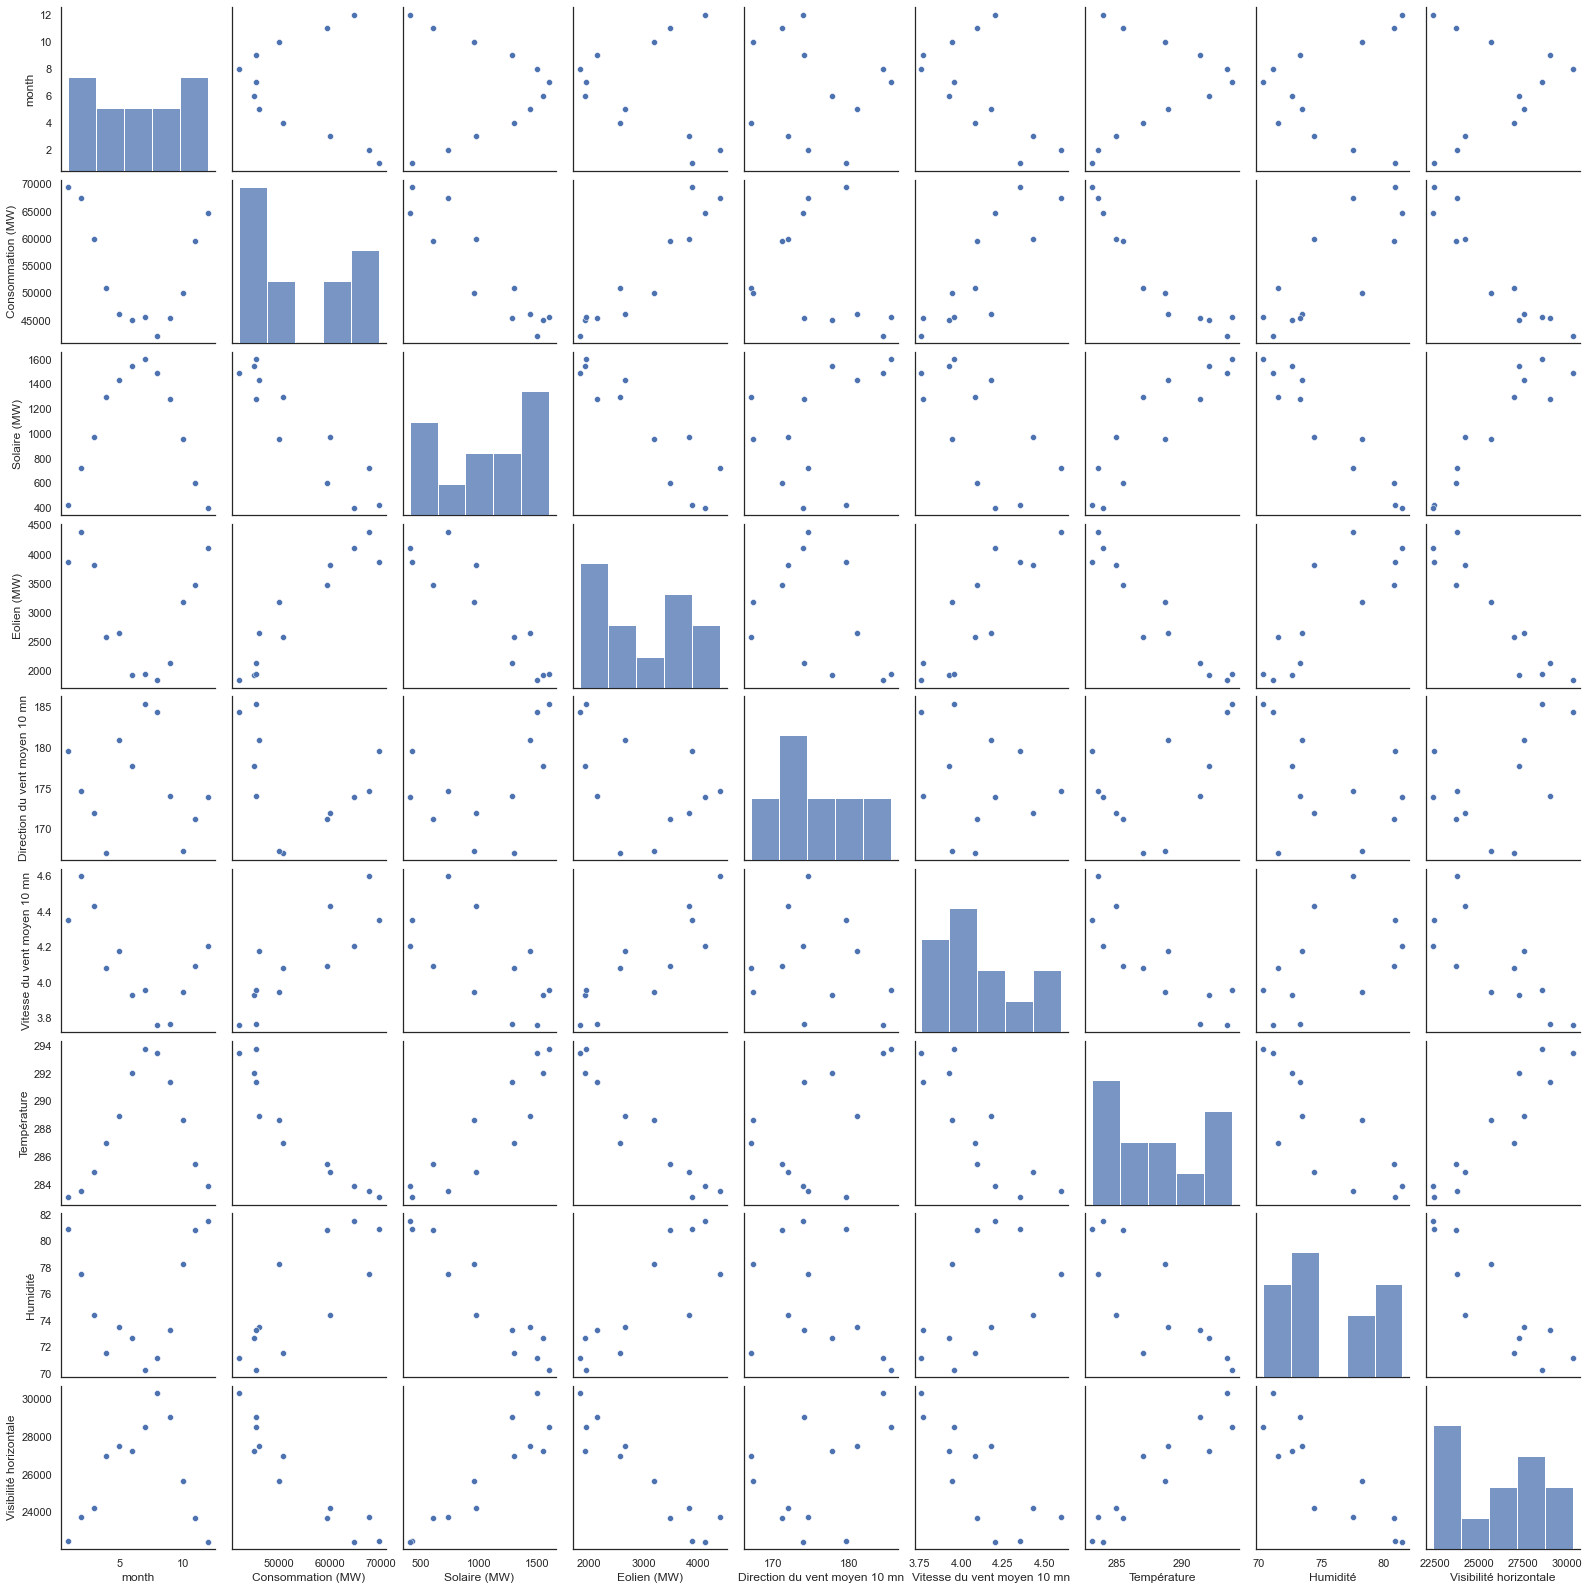

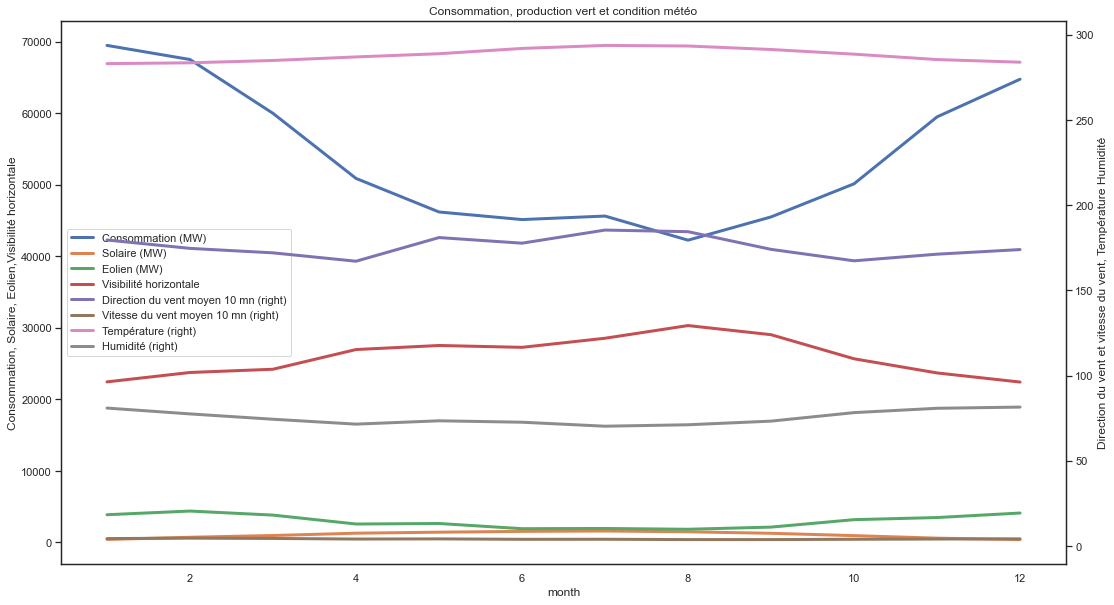

Tableau de corrélation


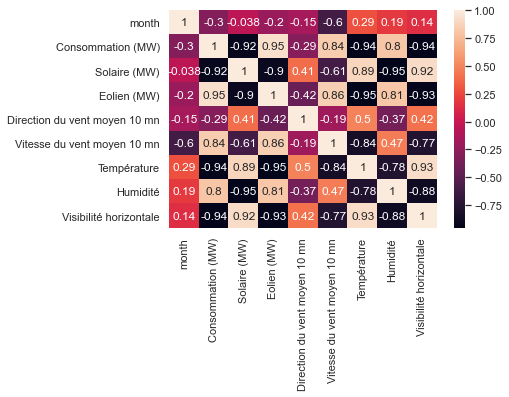

Tableau de p_value
                                month Consommation (MW) Solaire (MW)  \
month                             0.0            0.2068        0.449   
Consommation (MW)              0.2068               0.0          0.0   
Solaire (MW)                    0.449               0.0          0.0   
Eolien (MW)                    0.2519               0.0          0.0   
Direction du vent moyen 10 mn  0.9285             0.015       0.0056   
Vitesse du vent moyen 10 mn    0.0533               0.0       0.0008   
Température                    0.2265               0.0          0.0   
Humidité                       0.6084               0.0          0.0   
Visibilité horizontale         0.3053               0.0          0.0   

                              Eolien (MW) Direction du vent moyen 10 mn  \
month                              0.2519                        0.9285   
Consommation (MW)                     0.0                         0.015   
Solaire (MW)                       

In [295]:
print('Influence des conditons météo sur la consommation et la production verte par mois')
corr_meteo_data('month')

<p>Nous observons sur les graphiques une saisonnalité des conditions météo.
<p>Nous observons aussi une corrélation positive ou négartive sur la consommation, et les production solaire et éolien avec les conditions météo.

<p><b>Analyse des corrélations :</b>
<p><i>Consommation :</i> il y a corrélation avec la vitesse du vent, et l'humidité, ainsi qu'une corrélation inversée sur la température et la visibilité.
<p><i>Solaire :</i> il y a corrélation avec la température et la visibilité, ainsi qu'une corrélation inversée avec l'humidité.
<p><i>Eolien :</i> il y a corrélation avec la la vitesse du vent et l'humidté, ainsi qu'une corrélation inversée avec la visibilité.

<p><b>Analyse des p_values :</b>
<p>Les p_values sont inférieures à 5% sauf pour la direction du vent.
<p>Nous rejettons donc l'hypothèse d'indépendance des conditions météo avec consommation et productions solaire et éoliennes, à l'exception de la direcion du vent.

Influence des conditons météo sur la consommation et la production verte par trimestre
Graphique


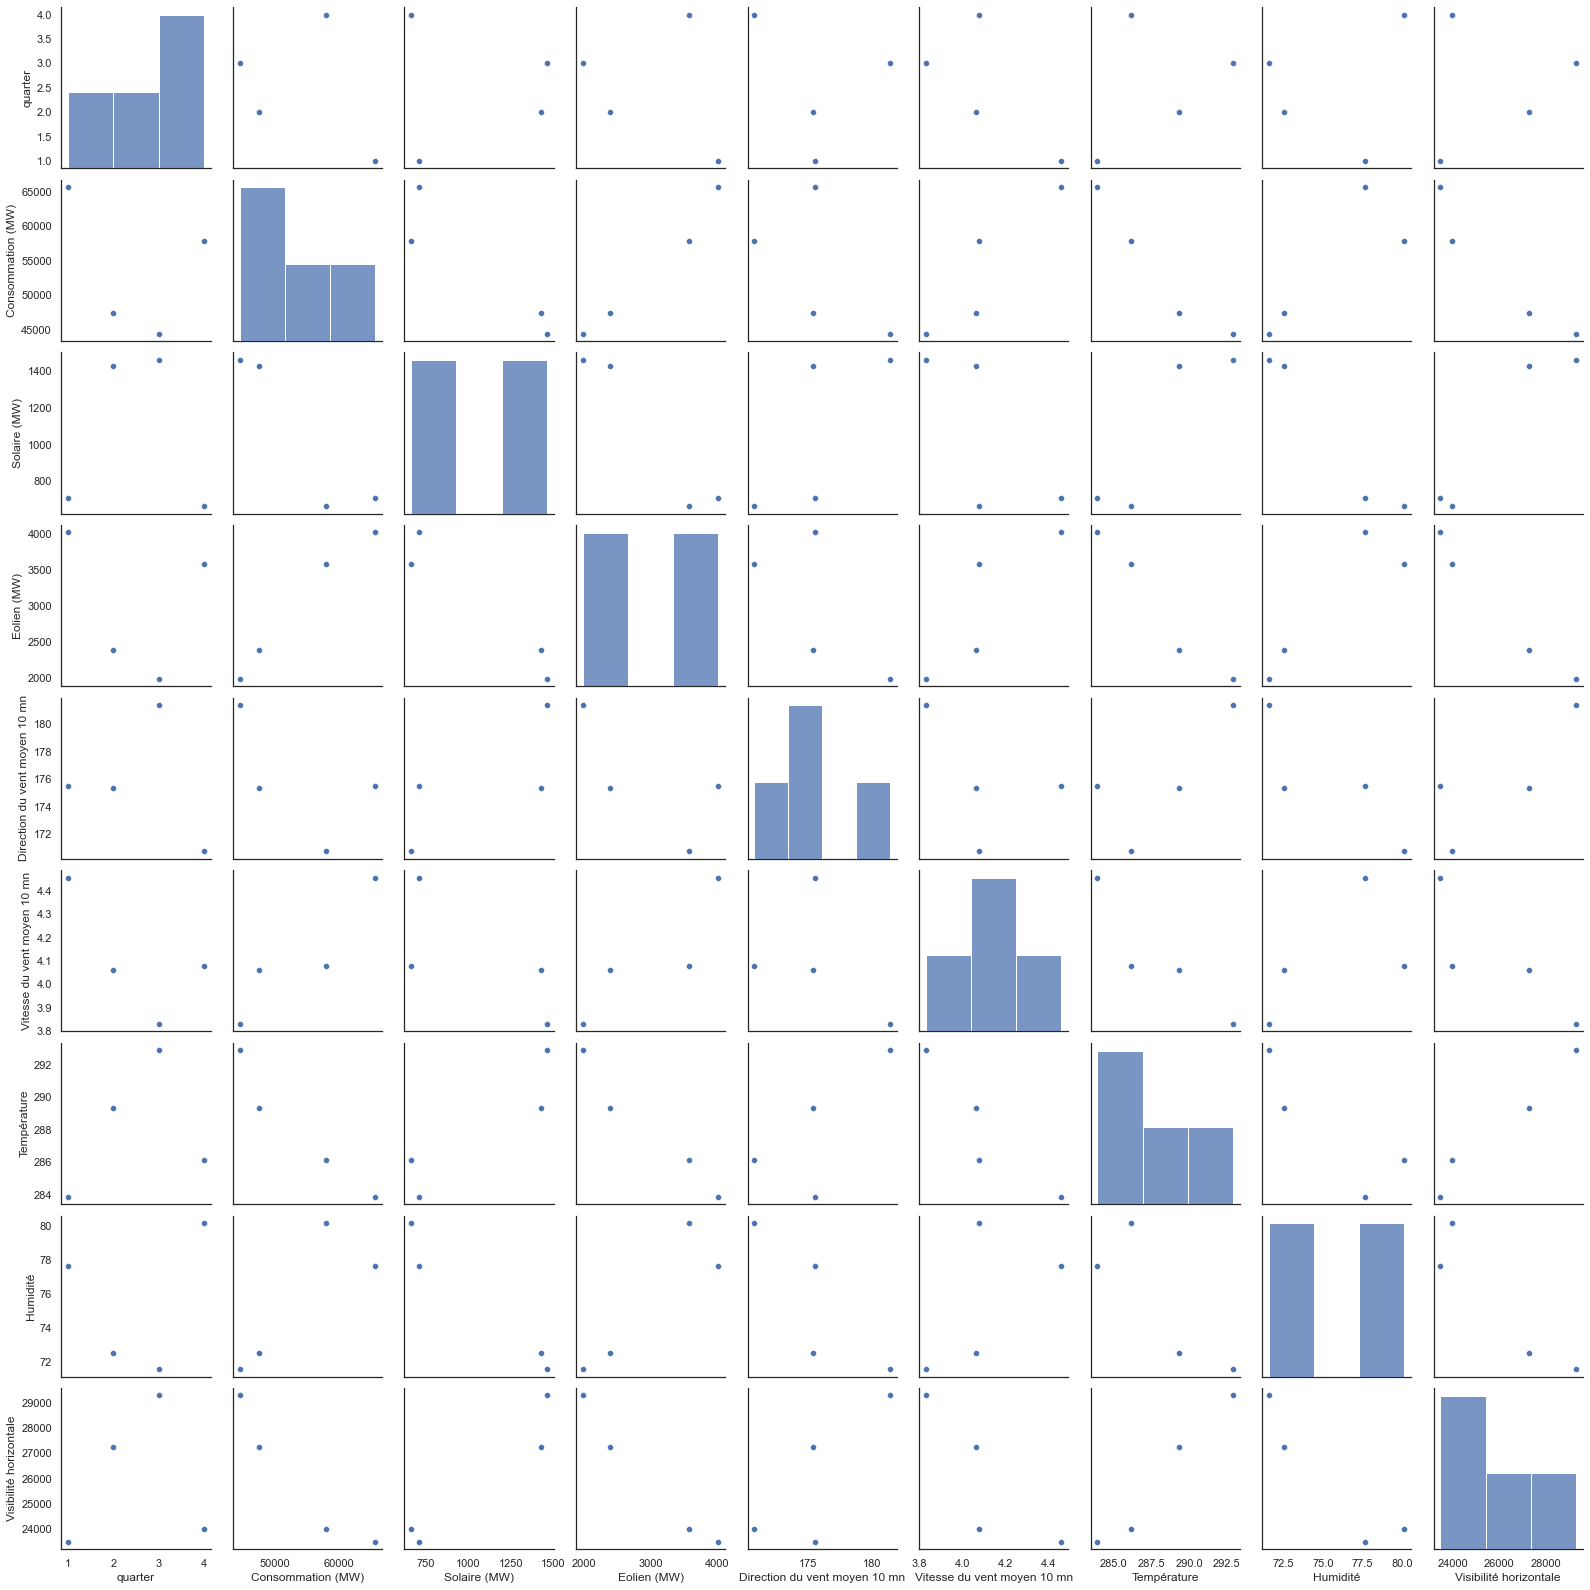

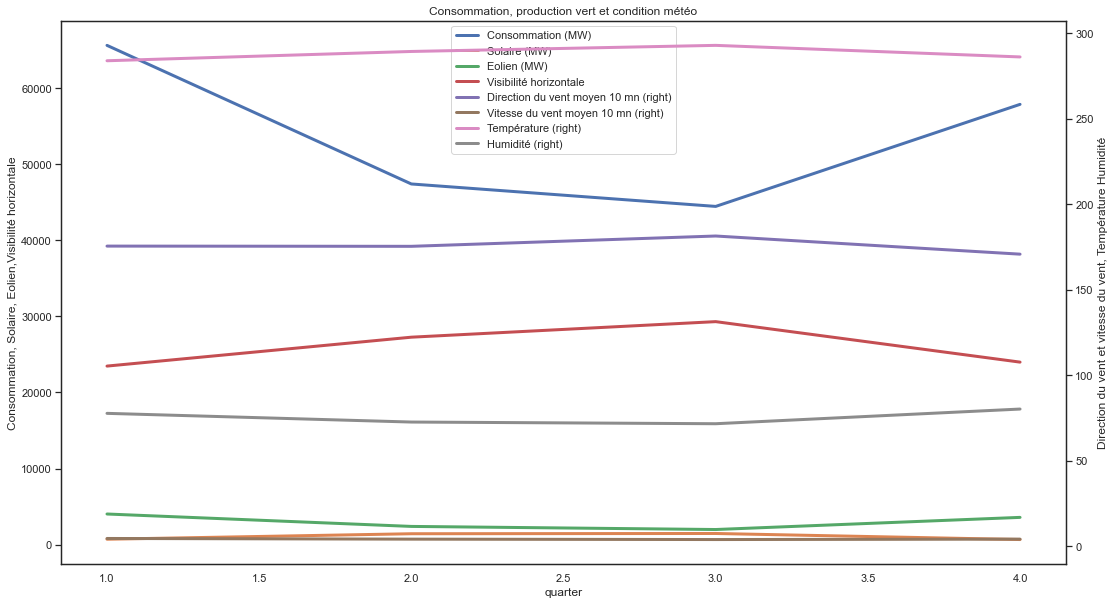

Tableau de corrélation


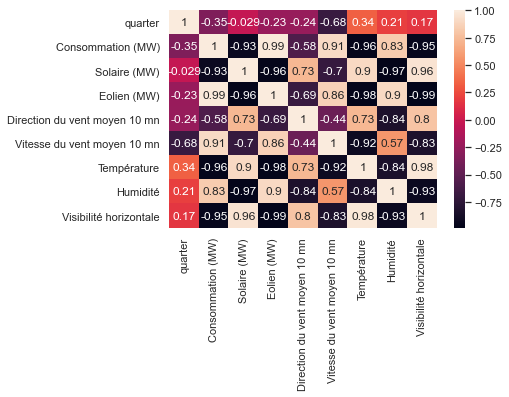

Tableau de p_value
                              quarter Consommation (MW) Solaire (MW)  \
quarter                           0.0            0.1926       0.4298   
Consommation (MW)              0.1926               0.0          0.0   
Solaire (MW)                   0.4298               0.0          0.0   
Eolien (MW)                    0.2605               0.0          0.0   
Direction du vent moyen 10 mn   0.751            0.0005          0.0   
Vitesse du vent moyen 10 mn    0.0616               0.0       0.0004   
Température                    0.2141               0.0          0.0   
Humidité                       0.6004            0.0001          0.0   
Visibilité horizontale         0.3102               0.0          0.0   

                              Eolien (MW) Direction du vent moyen 10 mn  \
quarter                            0.2605                         0.751   
Consommation (MW)                     0.0                        0.0005   
Solaire (MW)                       

In [296]:
print('Influence des conditons météo sur la consommation et la production verte par trimestre')
corr_meteo_data('quarter')

<p>Nous observons aussi une corrélation positive ou négartive sur la consommation, et les production solaire et eolien.

<p><b>Analyse des corrélation :</b>
<p><i>Consommation :</i> il y a corrélation avec la vitesse du vent et l'humidité, ainsi qu'une corrélation inversée sur la température et la visibilité.
<p><i>Solaire :</i> il y a corrélation avec la température et la visibilité, ainsi qu'une corrélation inversée avec l'humidité.
<p><i>Eolien :</i> il y a corrélation avec la vitesse du vent et l'humidité, ainsi qu'une corrélation inversée avec la visibilité.

<p><b>Analyse des p_values :</b>
<p>Les p_values sont inférieures à 5% sauf pour la direction du vent.
<p>Nous rejettons donc l'hypothèse d'indépendance des conditions météo avec consommation et productions solaire et éoliennes, à l'exception de la direcion du vent.

Influence des conditons météo sur la consommation et la production verte par année
Graphique


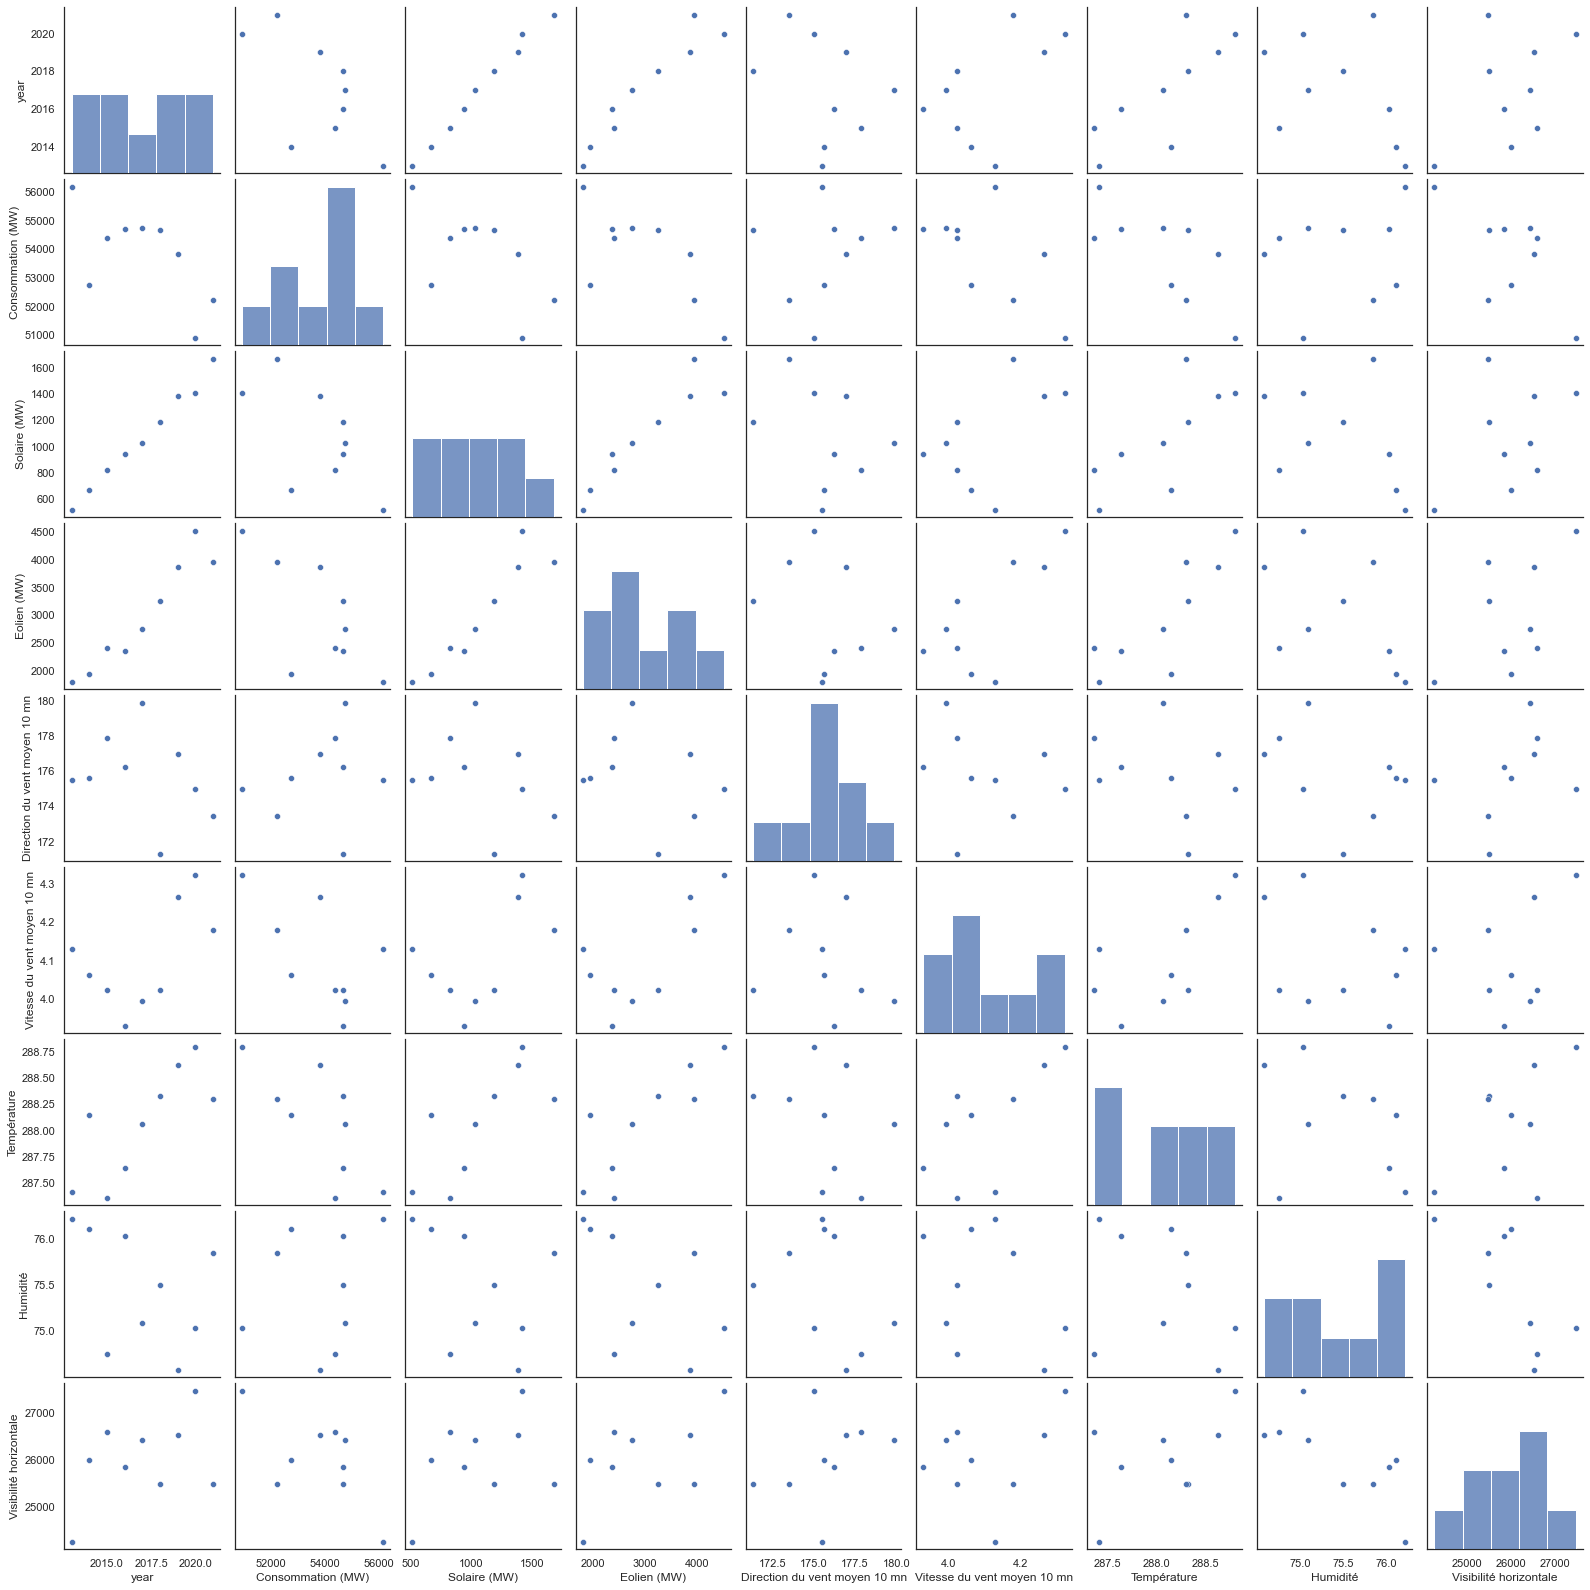

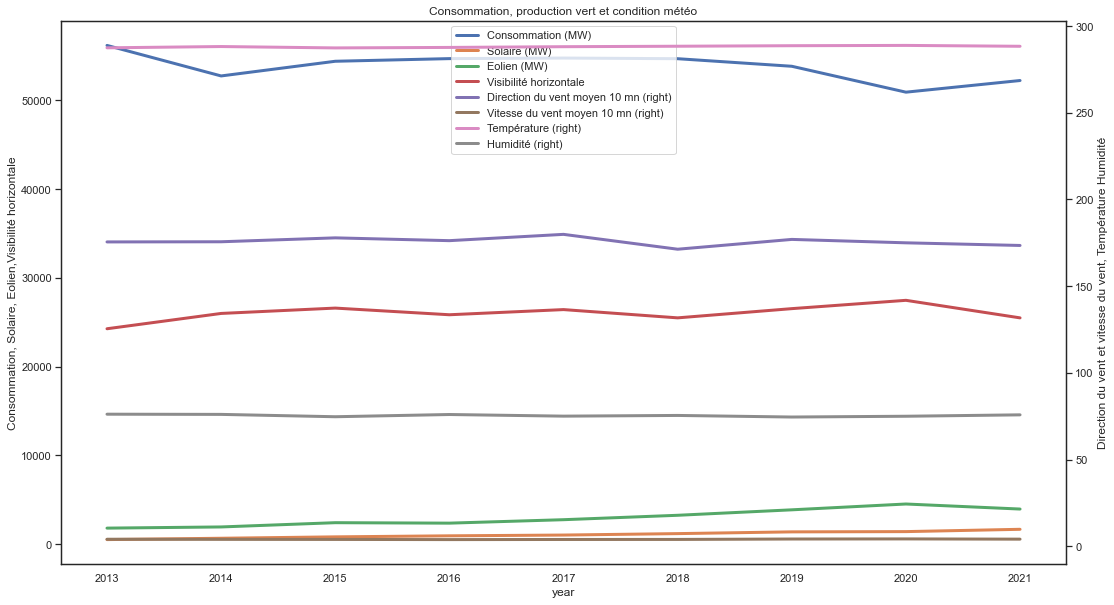

Tableau de corrélation


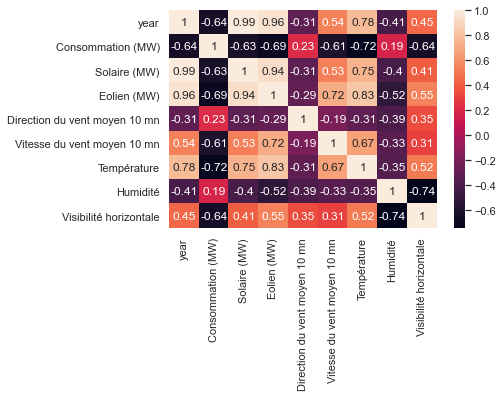

Tableau de p_value
                                 year Consommation (MW) Solaire (MW)  \
year                              0.0            0.0003          0.0   
Consommation (MW)              0.0003               0.0       0.0004   
Solaire (MW)                      0.0            0.0004          0.0   
Eolien (MW)                       0.0            0.0001          0.0   
Direction du vent moyen 10 mn   0.142            0.2232        0.134   
Vitesse du vent moyen 10 mn     0.001            0.0004       0.0012   
Température                       0.0               0.0          0.0   
Humidité                       0.0554            0.0786       0.0603   
Visibilité horizontale         0.0241            0.0097       0.0279   

                              Eolien (MW) Direction du vent moyen 10 mn  \
year                                  0.0                         0.142   
Consommation (MW)                  0.0001                        0.2232   
Solaire (MW)                       

In [297]:
print('Influence des conditons météo sur la consommation et la production verte par année')
corr_meteo_data('year')

<p>Les graphiques ne nous donne pas d'indice sur le comportement de la consommation et de la production.

<p><b>Analyse des corrélation :</b>
<p><i>Consommation :</i> il n'y a pas corrélation avec la consommation.
<p><i>Solaire :</i> il y a une corrélation avec la température, ainsi qu'une corrélation inversée avec l'humidté.
<p><i>Eolien :</i> il y a corrélation avec la température et la vitesse du vent, ainsi qu'une corrélation inversée avec l'humidité.

<p><b>Analyse des p_values :</b>
<p>Les p_values sont inférieures à 5% sauf pour la direction du vent.
<p>Nous rejettons donc l'hypothèse d'indépendance des conditions météo avec consommation et productions solaire et éoliennes, à l'exception de la température.

Influence des conditons météo sur la consommation et la production verte par jour de la semaine
Graphique


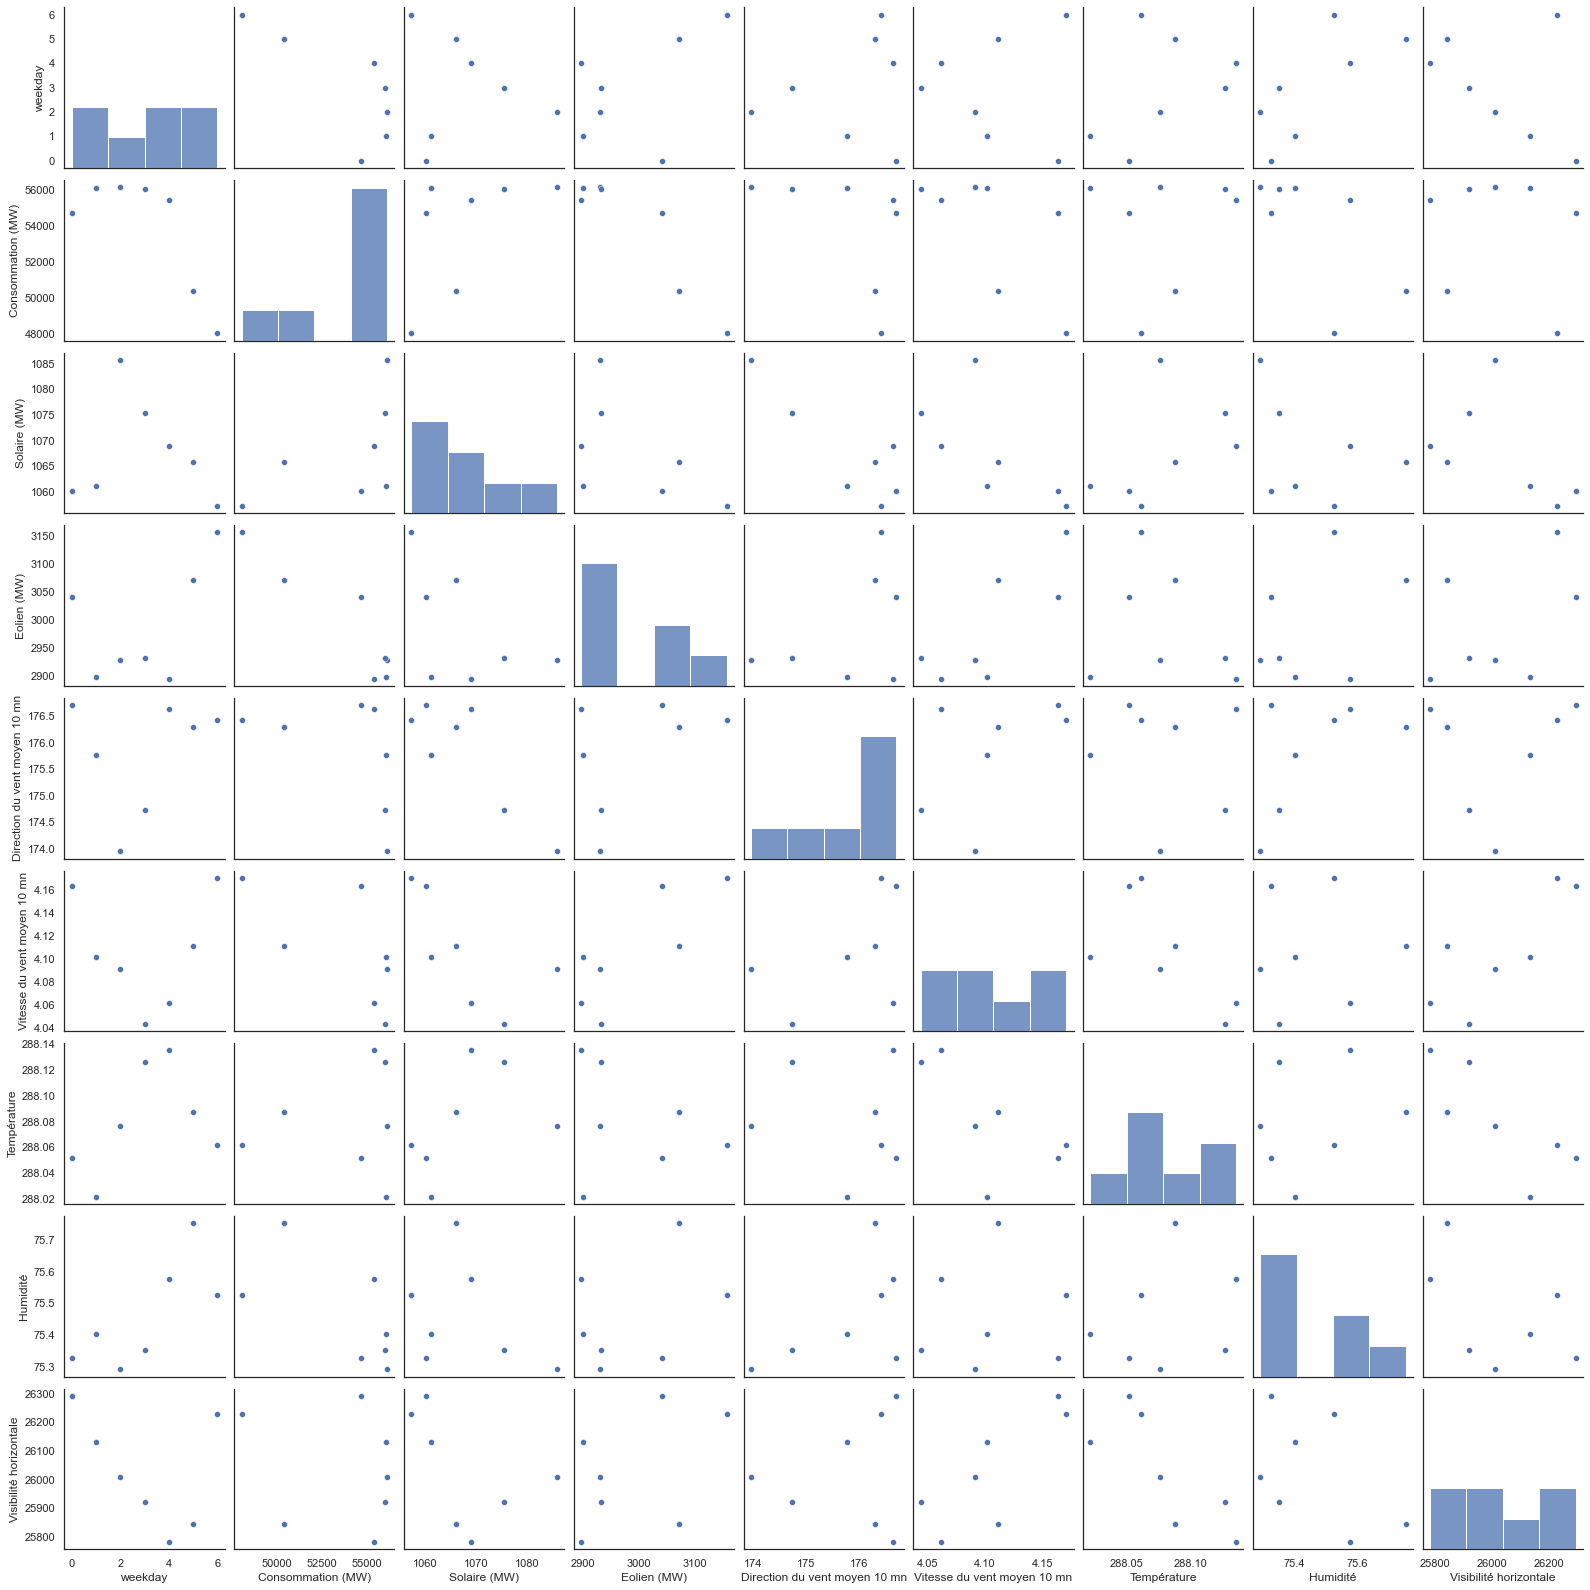

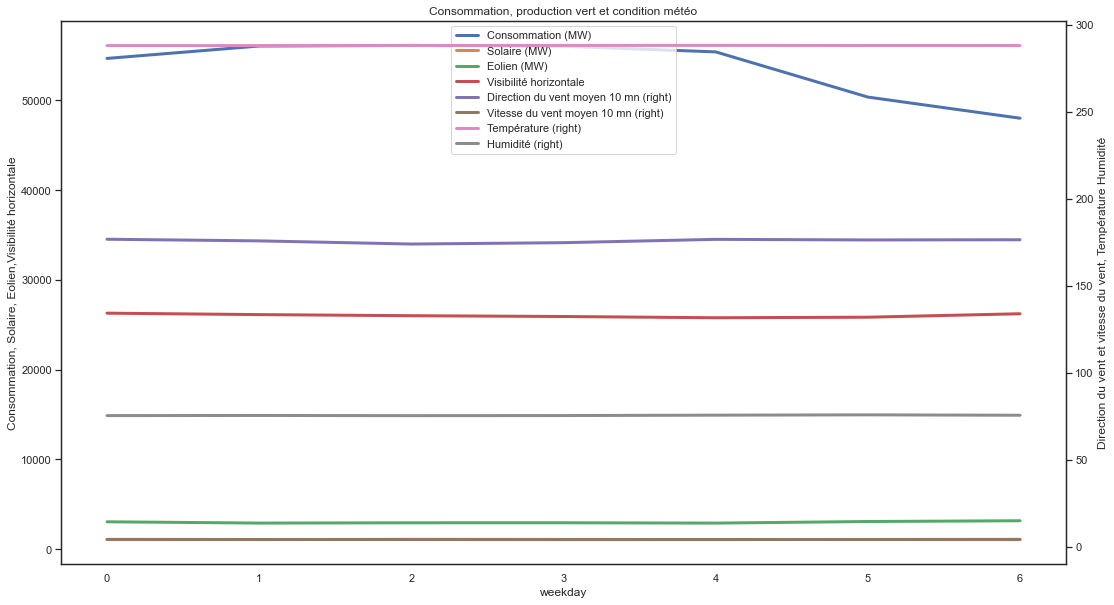

Tableau de corrélation


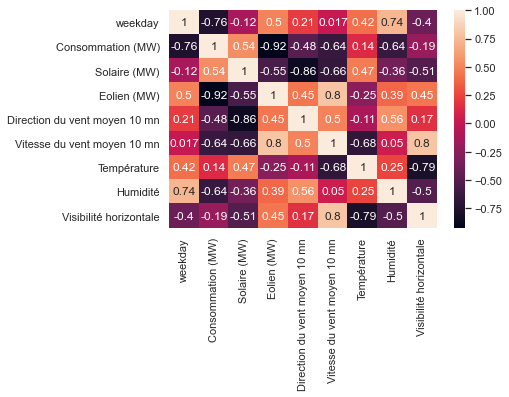

Tableau de p_value
                              weekday Consommation (MW) Solaire (MW)  \
weekday                           0.0            0.0226       0.4605   
Consommation (MW)              0.0226               0.0       0.0089   
Solaire (MW)                   0.4605            0.0089          0.0   
Eolien (MW)                    0.1313               0.0       0.0023   
Direction du vent moyen 10 mn  0.2101            0.0076       0.0001   
Vitesse du vent moyen 10 mn    0.7809            0.0205       0.0008   
Température                    0.3283            0.3719       0.0421   
Humidité                       0.0004              0.02       0.2162   
Visibilité horizontale         0.3388            0.3601       0.0466   

                              Eolien (MW) Direction du vent moyen 10 mn  \
weekday                            0.1313                        0.2101   
Consommation (MW)                     0.0                        0.0076   
Solaire (MW)                       

In [298]:
print('Influence des conditons météo sur la consommation et la production verte par jour de la semaine')
corr_meteo_data('weekday')

<p>Les graphiques ne nous donnent pas d'indice sur le comportement de la consommation et de la production.
<p><b>Analyse des corrélation et des p_values :</b>
<p>Les p_values sont supérieures à 5%. Les résultats obtenus dans le tableau de corrélation et de p_values nous montrent qu'il n'y a pas de dépendance entre les conditions météo, la consommation et la production.

Influence des conditons météo sur la consommation et la production verte par jour du mois
Graphique


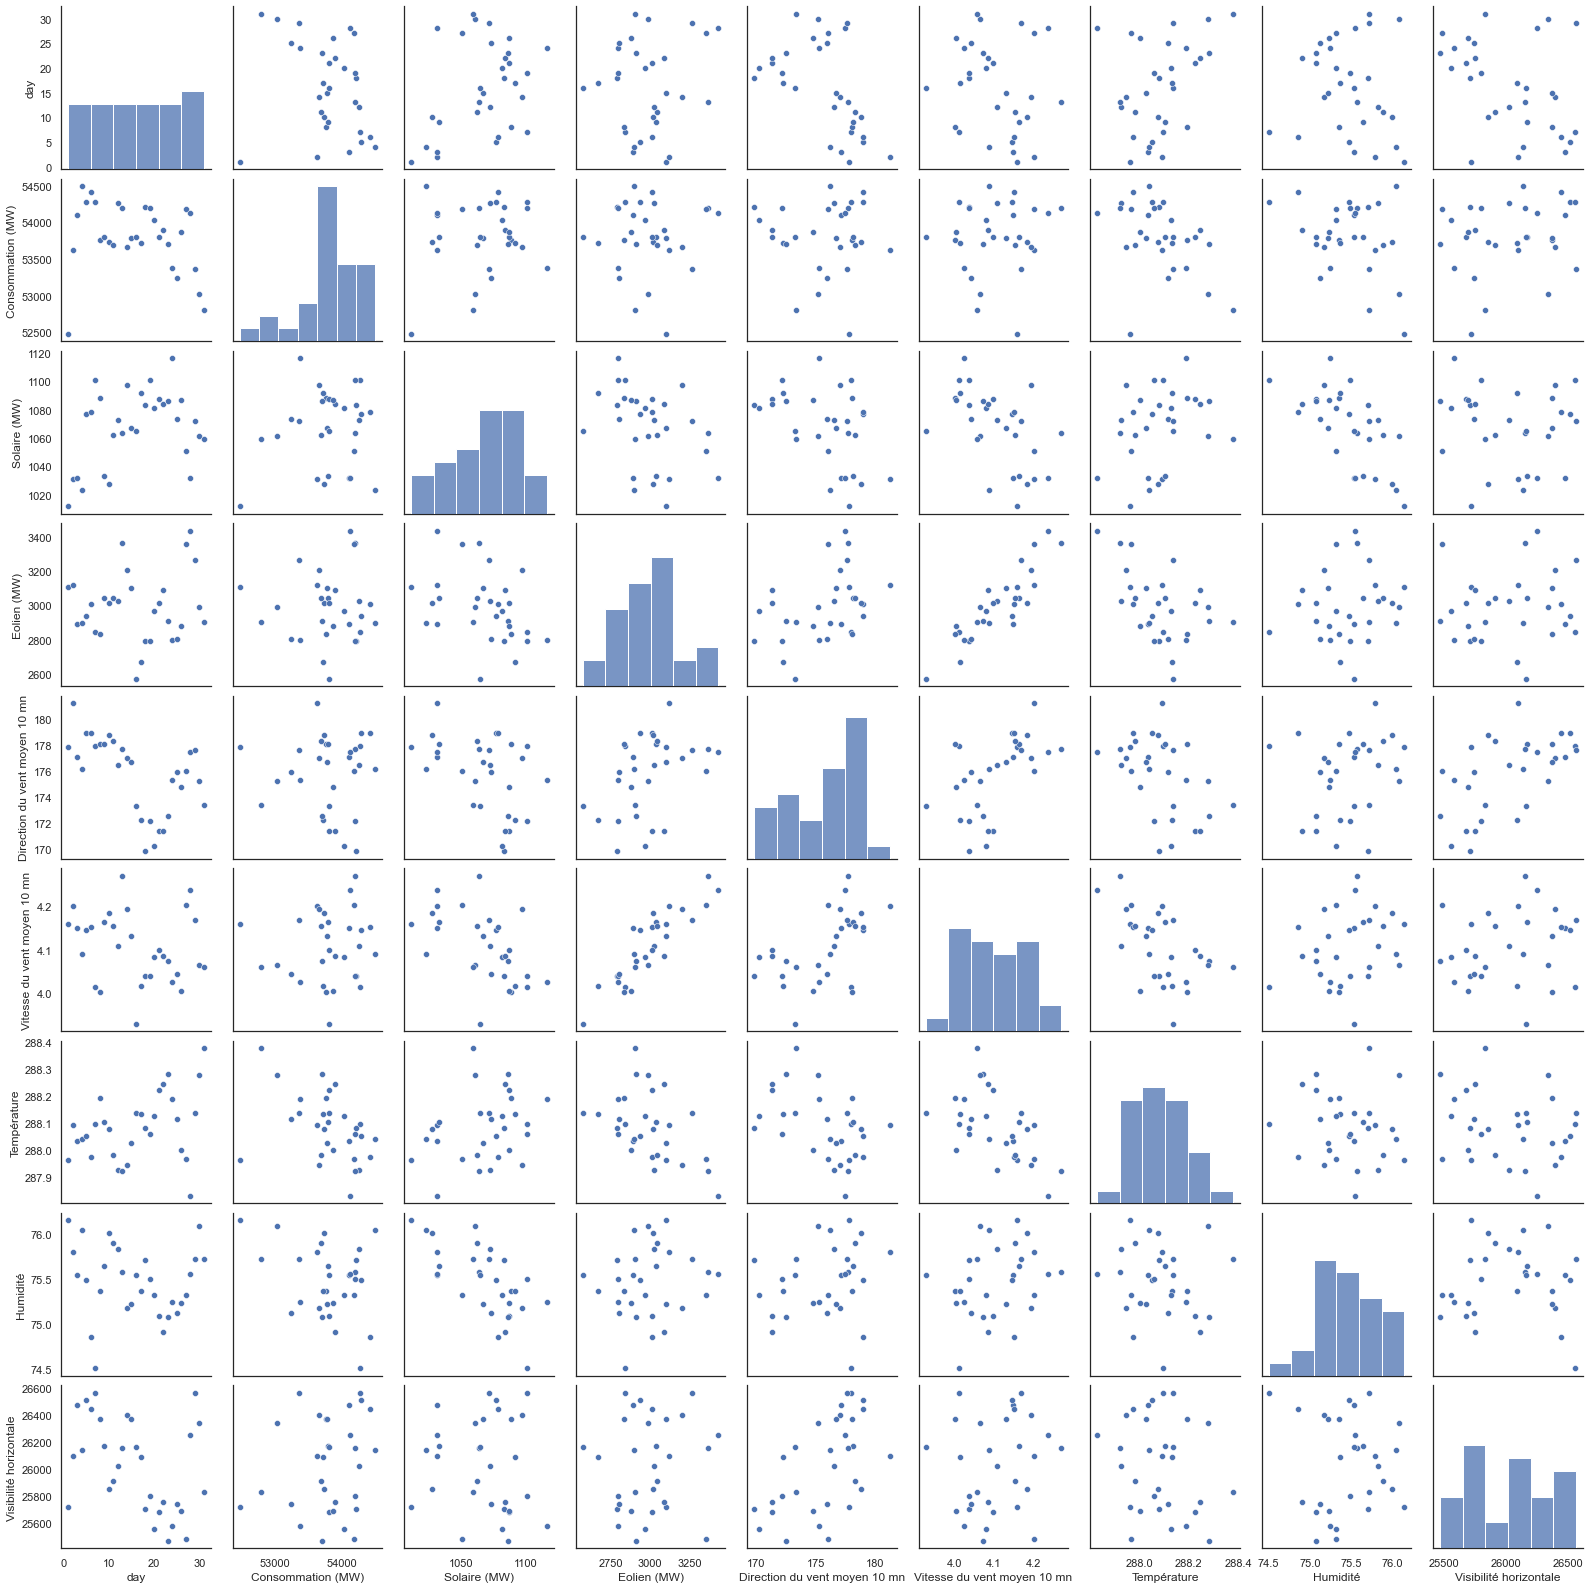

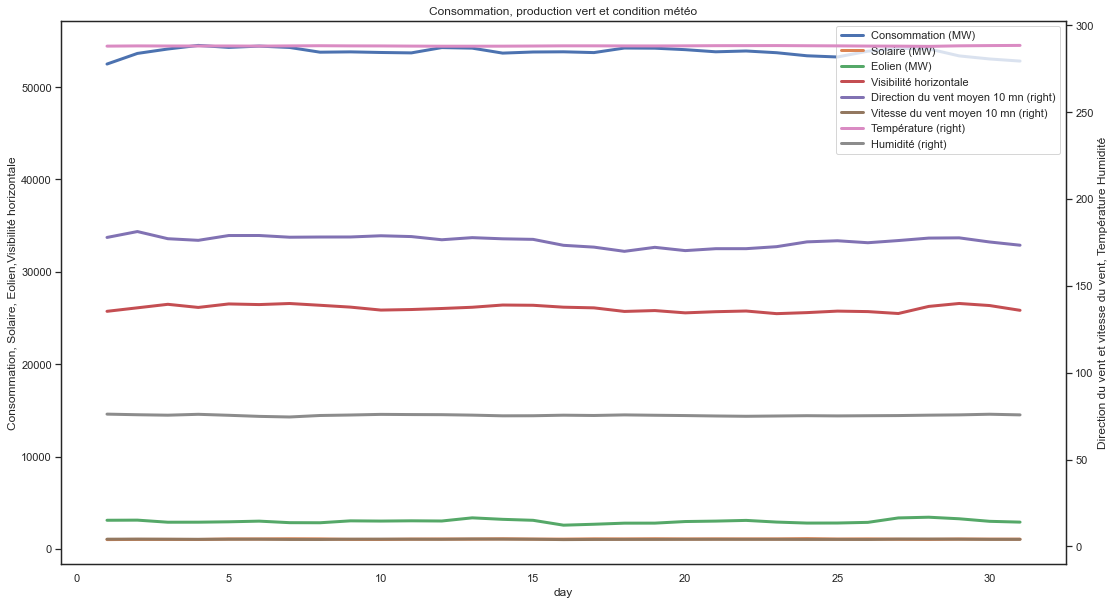

Tableau de corrélation


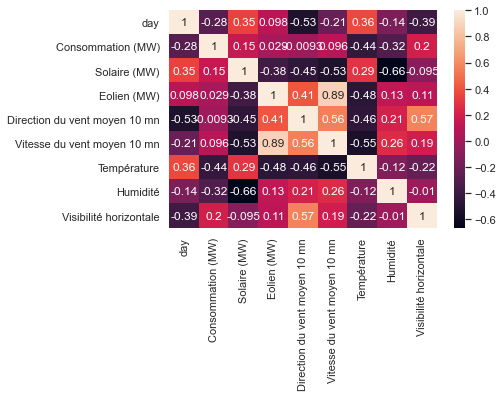

Tableau de p_value
                                  day Consommation (MW) Solaire (MW)  \
day                               0.0            0.2266       0.0923   
Consommation (MW)              0.2266               0.0       0.7411   
Solaire (MW)                   0.0923            0.7411          0.0   
Eolien (MW)                    0.3839            0.8139       0.0292   
Direction du vent moyen 10 mn  0.0044            0.6617       0.0126   
Vitesse du vent moyen 10 mn    0.1185            0.6802       0.0058   
Température                    0.0376            0.1252       0.0691   
Humidité                       0.3452             0.271       0.0019   
Visibilité horizontale         0.0073            0.3086       0.2992   

                              Eolien (MW) Direction du vent moyen 10 mn  \
day                                0.3839                        0.0044   
Consommation (MW)                  0.8139                        0.6617   
Solaire (MW)                       

In [299]:
print('Influence des conditons météo sur la consommation et la production verte par jour du mois')
corr_meteo_data('day')

<p>Les graphiques ne nous donnent pas d'indice sur l'influence des conditions météo sur le comportement de la consommation et de la production.

<p><b>Analyse des corrélation et des p_values :</b>
<p>Les p_values sont supérieures à 5%.
<p>Les résultats obtenus dans le tableau de corrélation et de p_values nous montrent qu'il n'y a pas de dépendance entre les conditions météo avec la consommation et la production.

Influence des conditons météo sur la consommation et la production verte par heure de la journée
Graphique


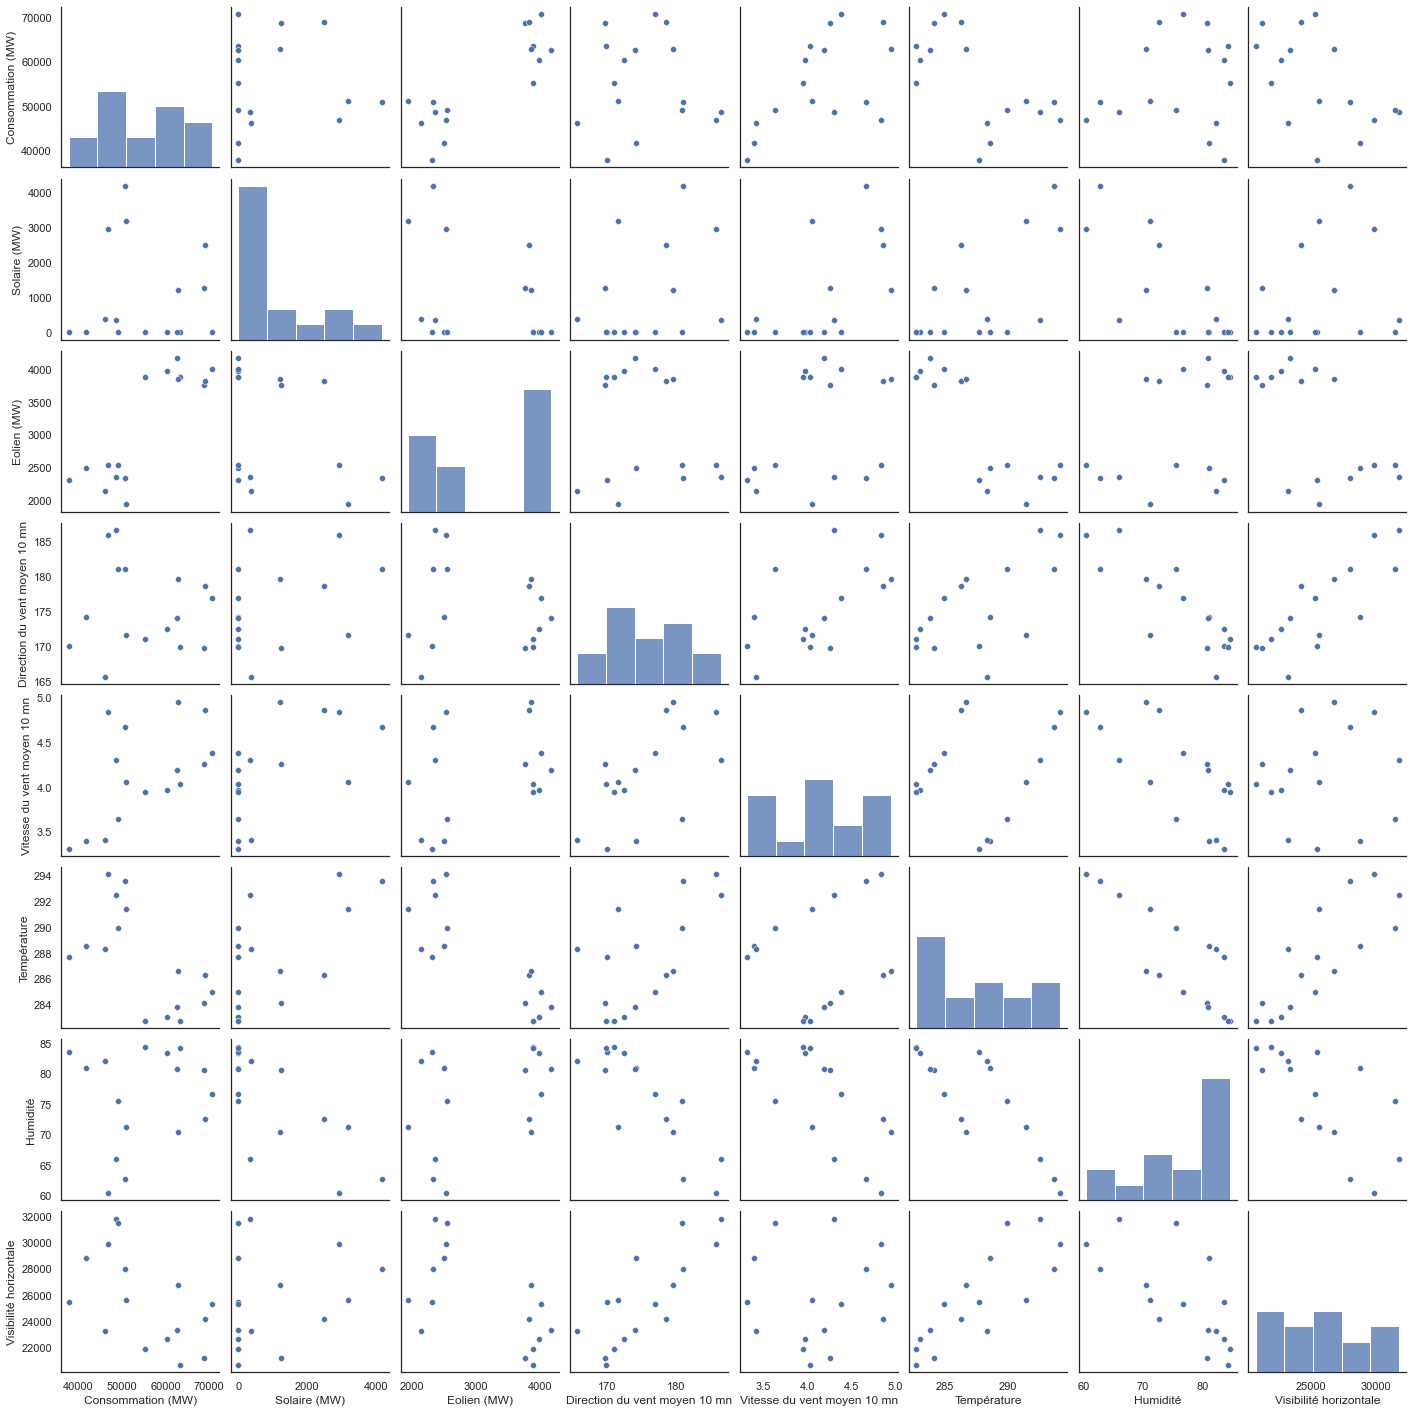

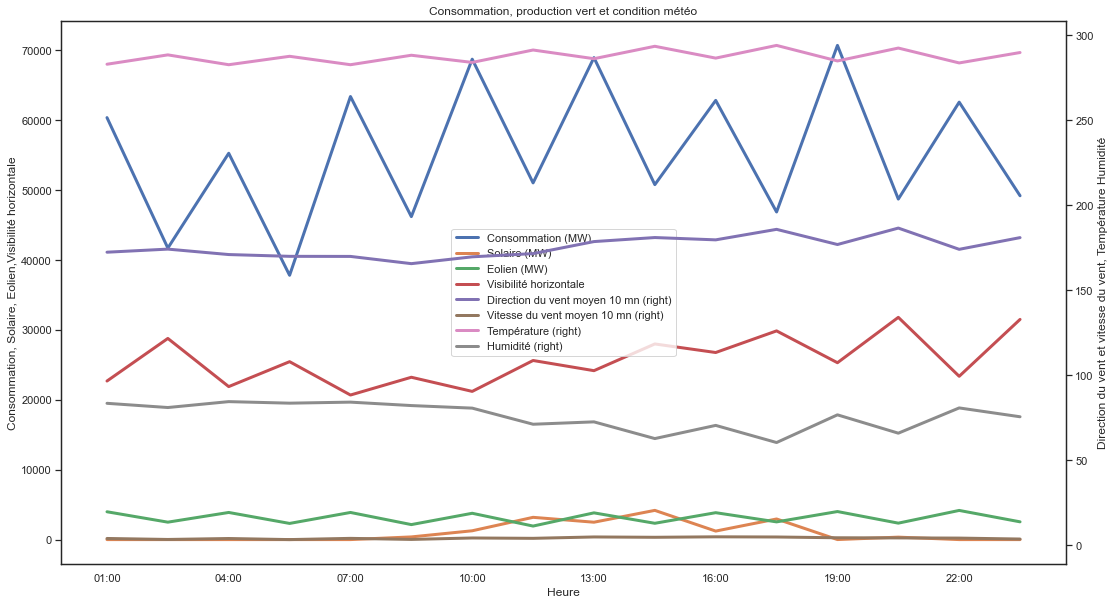

Tableau de corrélation


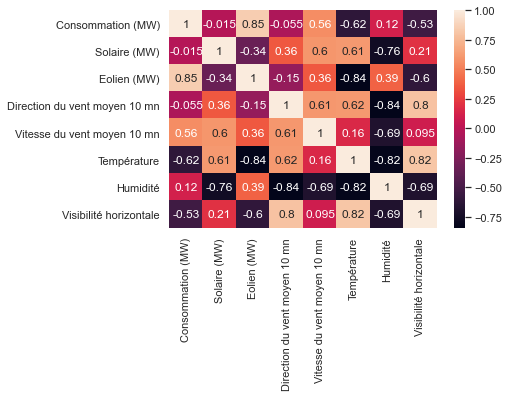

Tableau de p_value
                              Consommation (MW) Solaire (MW) Eolien (MW)  \
Consommation (MW)                           0.0       0.3796      0.0002   
Solaire (MW)                             0.3796          0.0      0.1124   
Eolien (MW)                              0.0002       0.1124         0.0   
Direction du vent moyen 10 mn            0.2382       0.0282      0.0969   
Vitesse du vent moyen 10 mn              0.4155       0.0609      0.8371   
Température                              0.0155       0.0165      0.0009   
Humidité                                 0.1951       0.0015      0.0495   
Visibilité horizontale                    0.015        0.084      0.0036   

                              Direction du vent moyen 10 mn  \
Consommation (MW)                                    0.2382   
Solaire (MW)                                         0.0282   
Eolien (MW)                                          0.0969   
Direction du vent moyen 10 mn               

In [300]:
print('Influence des conditons météo sur la consommation et la production verte par heure de la journée')
corr_meteo_data('Heure')

<p>Les graphiques ne nous donnent pas d'indice sur l'influence des conditions météo sur le comportement de la consommation et de la production.

<p><b>Analyse des corrélation et des p_values :</b>
<p>Les p_values sont supérieures à 5%.
<p>Les résultats obtenus dans le tableau de corrélation et de p_value nous montrent qu'il n'y a pas de dépendance entre les conditions météo avec la consommation et la production.

## Synthèse

<p>Pour avoir des résultats significatifs de l'influence des conditions météo, l'analyse doit être faite sur une saisonnalité d'une année (semaines, mois, trimestres).
<p>Plus la période est élevée, plus la dépendance est grande entre les conditions météo, la consommation et les productions vertes.

<p>Les analyses sur les jours de la semaine, le jour du mois ou à l'année ne nous permettent pas d'observer une dépendance des conditions météo sur la consommation et la prodution.


# XII- Conclusion

<p>Nous avons établi un premier état des lieux de nos données.
<p>Certaines pistes peuvent être écartées, telles que le taux de cession. D'autres semblent plus pertinentes, notamment en lien avec les conditions météorologiques, aussi bien pour la consommation - laquelle dépend fortement des variations de température - que pour les productions vertes qui sont directement impactées par l'environnement.
<p>Les énergies renouvelables et leur implantation serviront ainsi de base pour les modélisations.
<p>Afin d'optimiser leur utilisation en plus des productions maîtrisées - nucléaire en base et thermique+hydraulique en levier -, le focus sera d'abord fait sur les prédictions de consommation.